# **Problem Set 9 - Group 12** 
(Minh-Tri Hoang, Rebekka Schmarewski, Duc-Thinh Phung)

In [1]:
rm(list = ls())

In [2]:
library(data.table)
library(dplyr)
library(pastecs)
library(MASS)
library(Hmisc)
library(MCMCglmm)
library(psych)
library(sandwich)
library(grf) 
library(ggplot2)

set.seed(57) 


Attaching package: 'dplyr'


The following objects are masked from 'package:data.table':

    between, first, last


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union



Attaching package: 'pastecs'


The following objects are masked from 'package:dplyr':

    first, last


The following objects are masked from 'package:data.table':

    first, last



Attaching package: 'MASS'


The following object is masked from 'package:dplyr':

    select


Loading required package: lattice

Loading required package: survival

Loading required package: Formula

Loading required package: ggplot2


Attaching package: 'Hmisc'


The following objects are masked from 'package:dplyr':

    src, summarize


The following objects are masked from 'package:base':

    format.pval, units


Loading required package: Matrix

Loading required package: coda

Loading required package: ape


Atta

In [3]:
synthetic_data <- read.csv("D:/data/synthetic_data.csv")

dgp <- function(n) { 

  data <- synthetic_data[sample(nrow(synthetic_data), n), ]
  data <- rename(data, W = Z)
  data <- arrange(data, desc(W))
  df <- data[, -c(1)]
  var_name <- names(df)
  stats <- as.data.frame(t(stat.desc(df)))
  cat_var <- c()
  num_var <- c()
  sim_data <- data$schoolid

  for (i in 1:ncol(df)) {
    if (class(df[, i]) == "integer") {
        # print(paste("[Categorical]", var_name[i]))
        cat_var <- c(cat_var, var_name[i])
        x <- sort(unique(df[, i]))
        freq <- as.data.frame(table(df[, i]))[2]
        sim <- sample(x, nrow(df), replace = TRUE, prob = freq$Freq)
    }
    else {
        # print(paste("[Numeric]", var_name[i]))
          num_var <- c(num_var, var_name[i])
          sim <- rtnorm(n = stats$nbr.val[i], mean = stats$mean[i],
                    sd = stats$std.dev[i], lower = stats$min[i], upper = stats$max[i])
      }
    sim_data <- data.frame(sim_data, a = sim)
    }
    
  names(sim_data) <- names(data)
  eps <- rnorm(nrow(sim_data), 0, 1)
  eta <- rnorm(nrow(sim_data), 0, 2)
    
  for (i in 1:length(data$W[data$W == 1])) {
      sim_data$tau[i] <- 1 + ifelse(sim_data$X1[i] < mean(sim_data$X1[i]), 1, 0) - 
      2 * ifelse(sim_data$X2[i] < mean(sim_data$X2[i]), 1, 0) - eta[i]
    
      sim_data$Y[i] <- 1 + sim_data$X1[i] - 2 * sim_data$X2[i] + sim_data$W[i] -
      3 * sim_data$X1[i] * sim_data$W[i]  - 4 * sim_data$X2[i] * sim_data$W[i] + eps[i] 
  }
  
  sim_data$Y.0 <- sim_data$Y
  sim_data$Y.1 <- sim_data$Y
  
  #Potential outcomes Y(0) and Y(1) for treated and untreated group:
  #Treated group W=1:
  #Y(1)_i - Y(0)_i = tau(x)_i #note: we don't observe Y(0)_i 
  #but we know it since we built the dgp and 
  #therefore know everything, also the potential outcome 
  #of the treated group(W=1) if not treated (Y(0))
  #Y (i.e. observed outcome) = W * Y(1) + (1-W) * Y(0) 
  #                          = W * Y(1) + 1 * Y(0) - W * Y(0) 
  #                          = W * [Y(1) - Y(0)] + Y(0) 
  #                          = W * tau(x) + Y(0)
  #Y(0) = Y - W * tau(x)
  #Y(1) = Y(0) + tau(x)

  #we fill up the rows for Y(0) and Y(1) for W=1  

  sim_data$Y.0[sim_data$W == 1] <- sim_data$Y[sim_data$W == 1] - sim_data$tau[sim_data$W == 1] * sim_data$W[sim_data$W == 1]
  sim_data$Y.1[sim_data$W == 1] <- sim_data$Y.0[sim_data$W == 1] + sim_data$tau[sim_data$W == 1]

  #Untreated group W=0
  # Unconfoundedness assumption: mean potential outcome of actually (un-)treated group doesnt depend on whether it is treated or not
  # E[Y(0) | W = 1] = E[Y(0) | W = 0] = E[Y(0)] &
  # E[Y(1) | W = 1] = E[Y(1) | W = 0] = E[Y(1)] 

  #we fill up the rows for Y(0) and Y(1) for W=0 by adding some randomness to Y()|W=1

  sim_data$Y.0[sim_data$W == 0] <- rep(mean(sim_data$Y.0[sim_data$W == 1]),times=length(sim_data$W[sim_data$W == 0]))  + 
                                   rnorm(length(sim_data$W[sim_data$W == 0]), 0, 1)
  sim_data$Y.1[sim_data$W == 0] <- rep(mean(sim_data$Y.1[sim_data$W == 1]),times=length(sim_data$W[sim_data$W == 0])) + 
                                   rnorm(length(sim_data$W[sim_data$W == 0]), 0, 1)
    
  sim_data$tau[sim_data$W == 0] <- sim_data$Y.1[sim_data$W == 0] - sim_data$Y.0[sim_data$W == 0]
  sim_data$Y[sim_data$W == 0] <- sim_data$W[sim_data$W == 0] * sim_data$Y.1[sim_data$W == 0] +
                                 (1 - sim_data$W[sim_data$W == 0]) * sim_data$Y.0[sim_data$W == 0]

  return(sim_data)
}

data.all <- dgp(nrow(synthetic_data))

In [4]:
data.all <- arrange(data.all, desc(W))
head(data.all[, c("W", "Y", "Y.1", "Y.0", "tau")])
tail(data.all[, c("W", "Y", "Y.1", "Y.0", "tau")])

,W,Y,Y.1,Y.0,tau
,<int>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,-2.088140,-2.088140,-2.475497,0.3873561
2,1,15.488414,15.488414,12.386243,3.1021710
3,1,0.438810,0.438810,-4.860953,5.2997632
4,1,1.309839,1.309839,-2.931481,4.2413195
5,1,3.962206,3.962206,2.362849,1.5993571
6,1,-9.840830,-9.840830,-10.739501,0.8986714


,W,Y,Y.1,Y.0,tau
,<int>,<dbl>,<dbl>,<dbl>,<dbl>
10386,0,-0.3672648,-0.4643564,-0.3672648,-0.09709158
10387,0,1.3228644,1.0828484,1.3228644,-0.24001599
10388,0,1.3591682,1.2343969,1.3591682,-0.12477124
10389,0,1.2547790,0.3731712,1.2547790,-0.88160779
10390,0,1.5132530,1.6047273,1.5132530,0.09147427
10391,0,1.7948879,1.1328588,1.7948879,-0.66202907


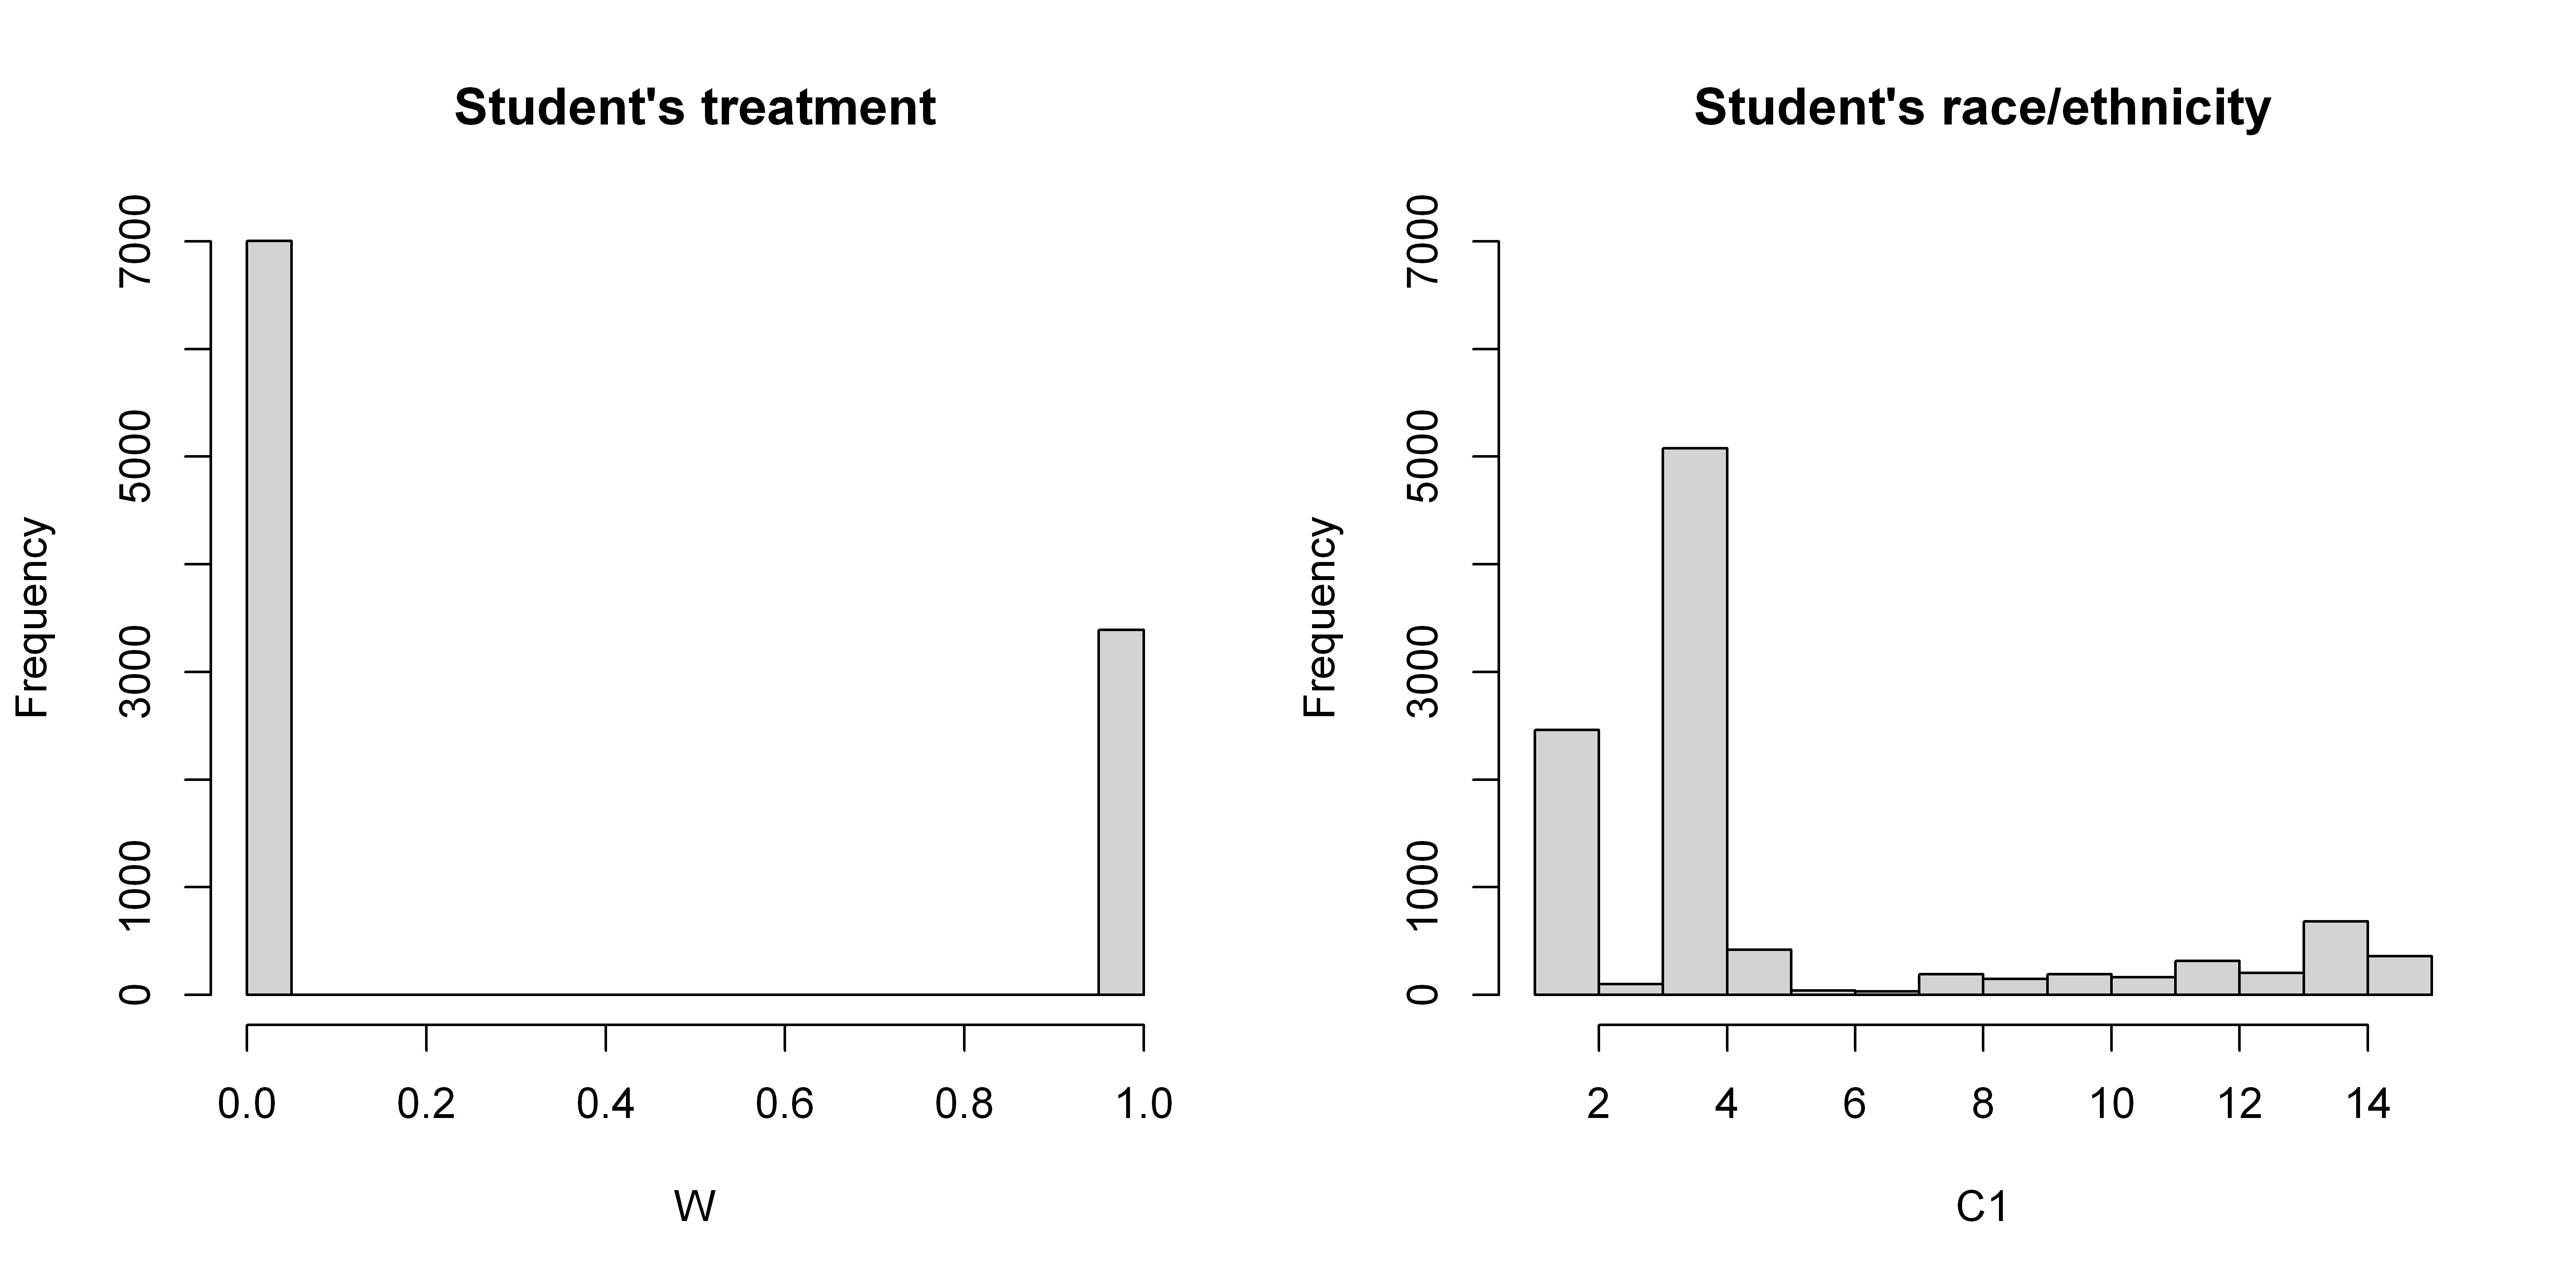

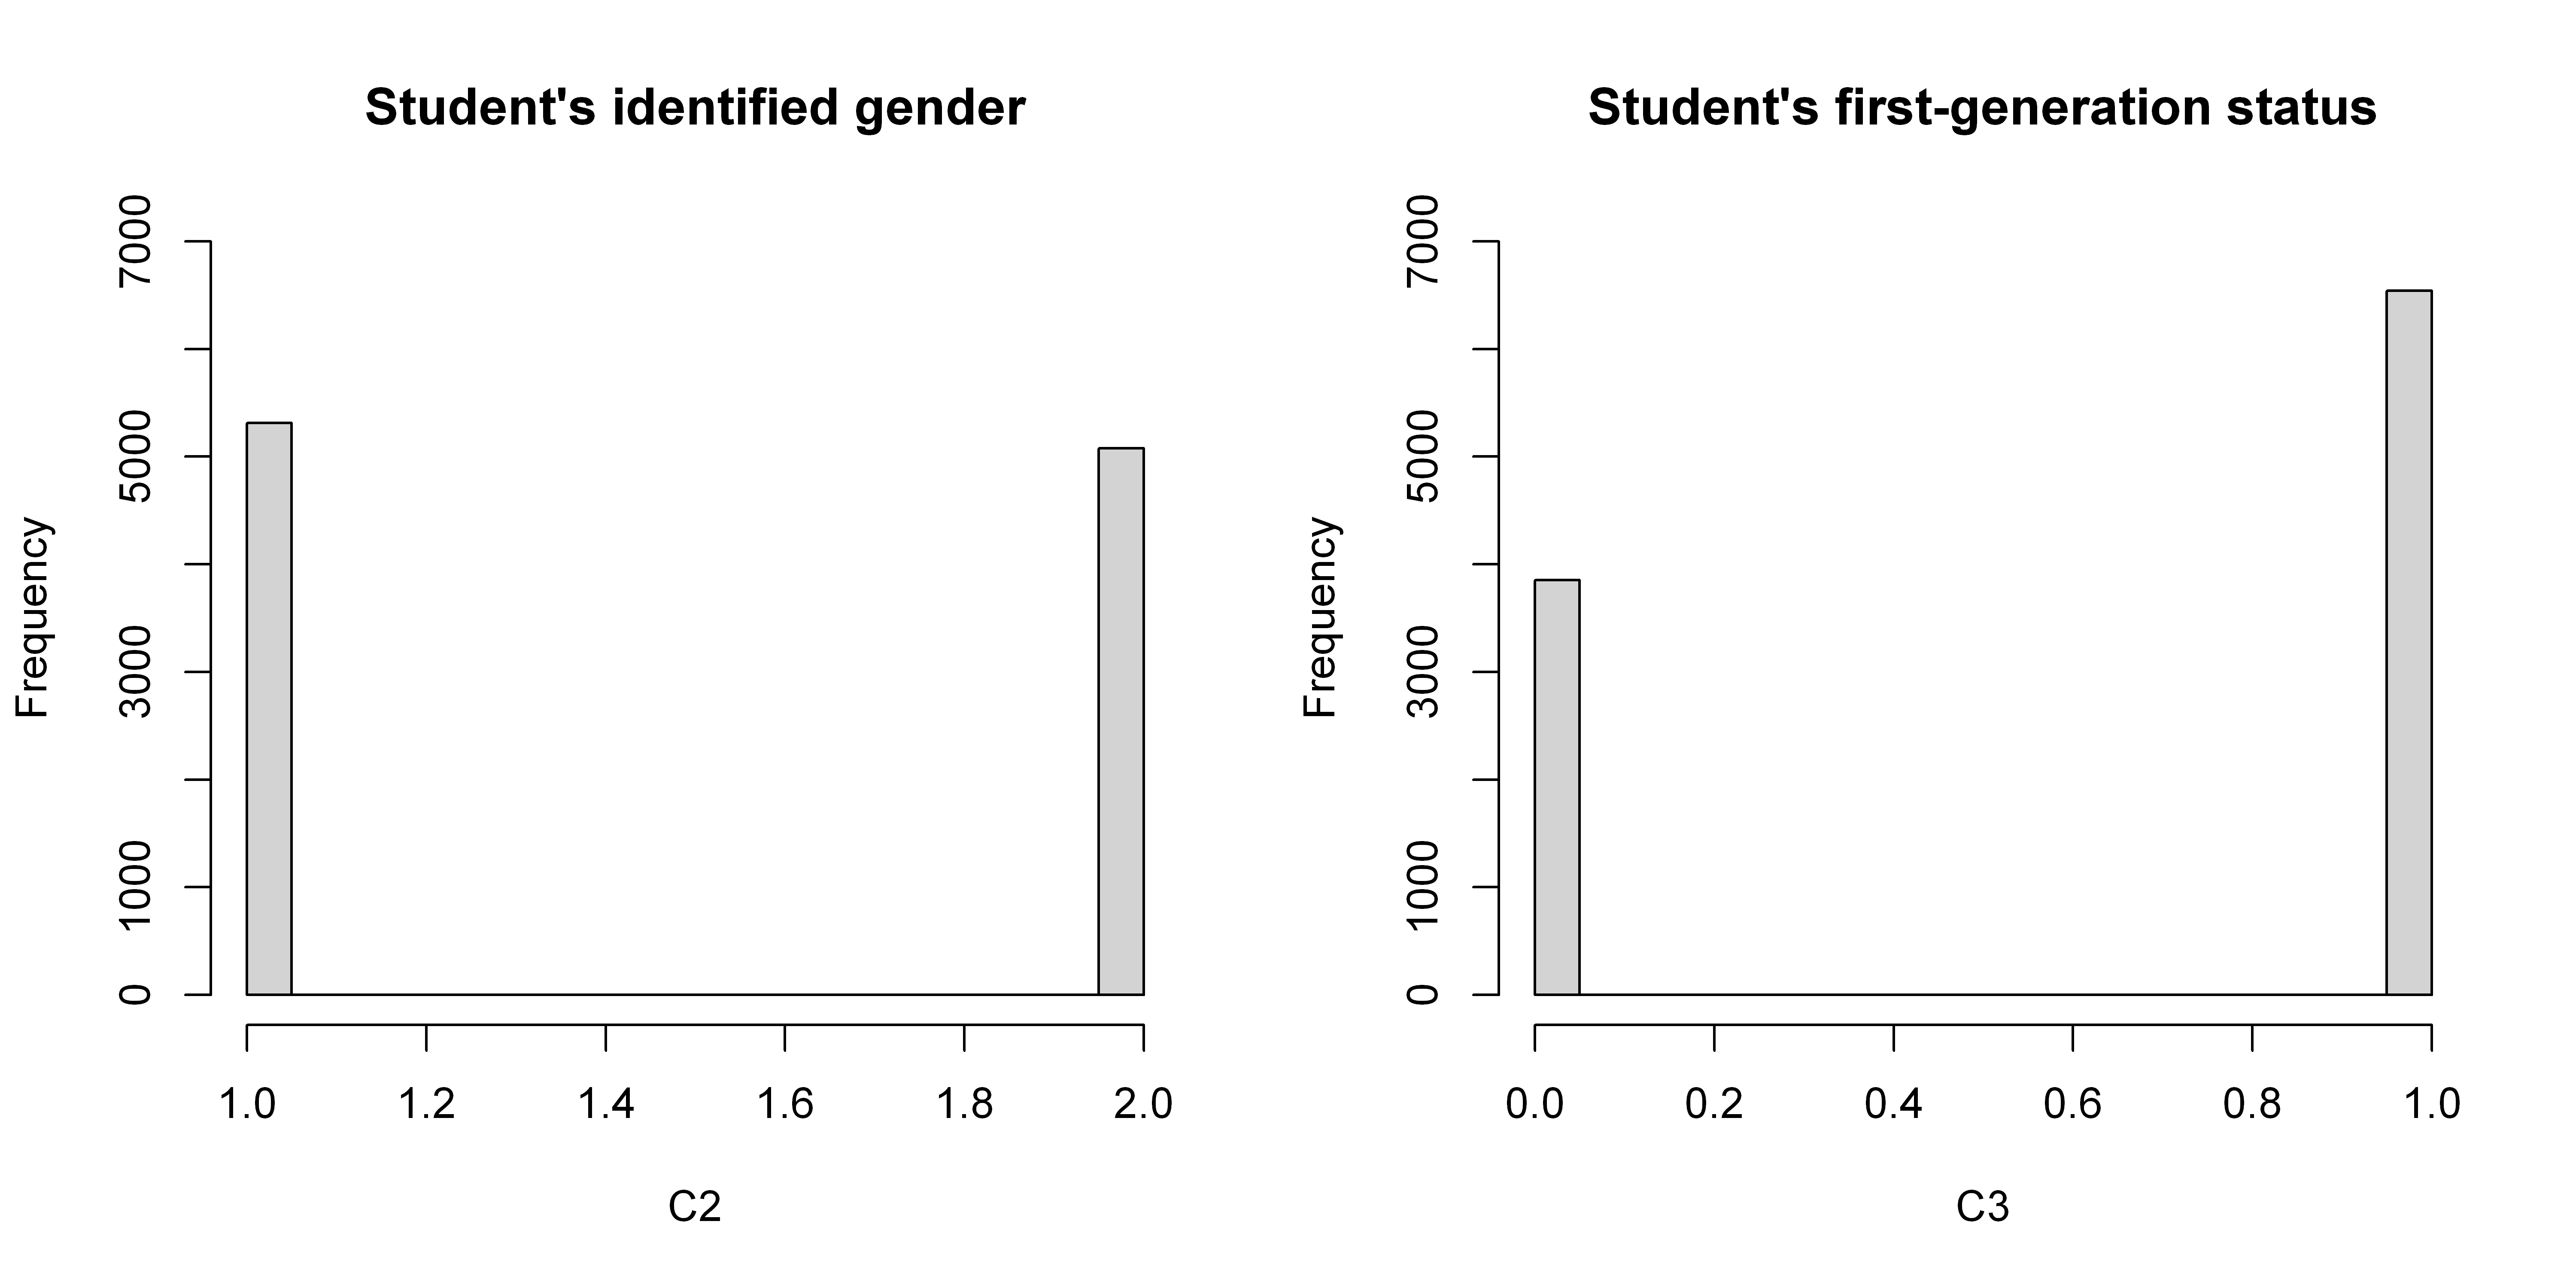

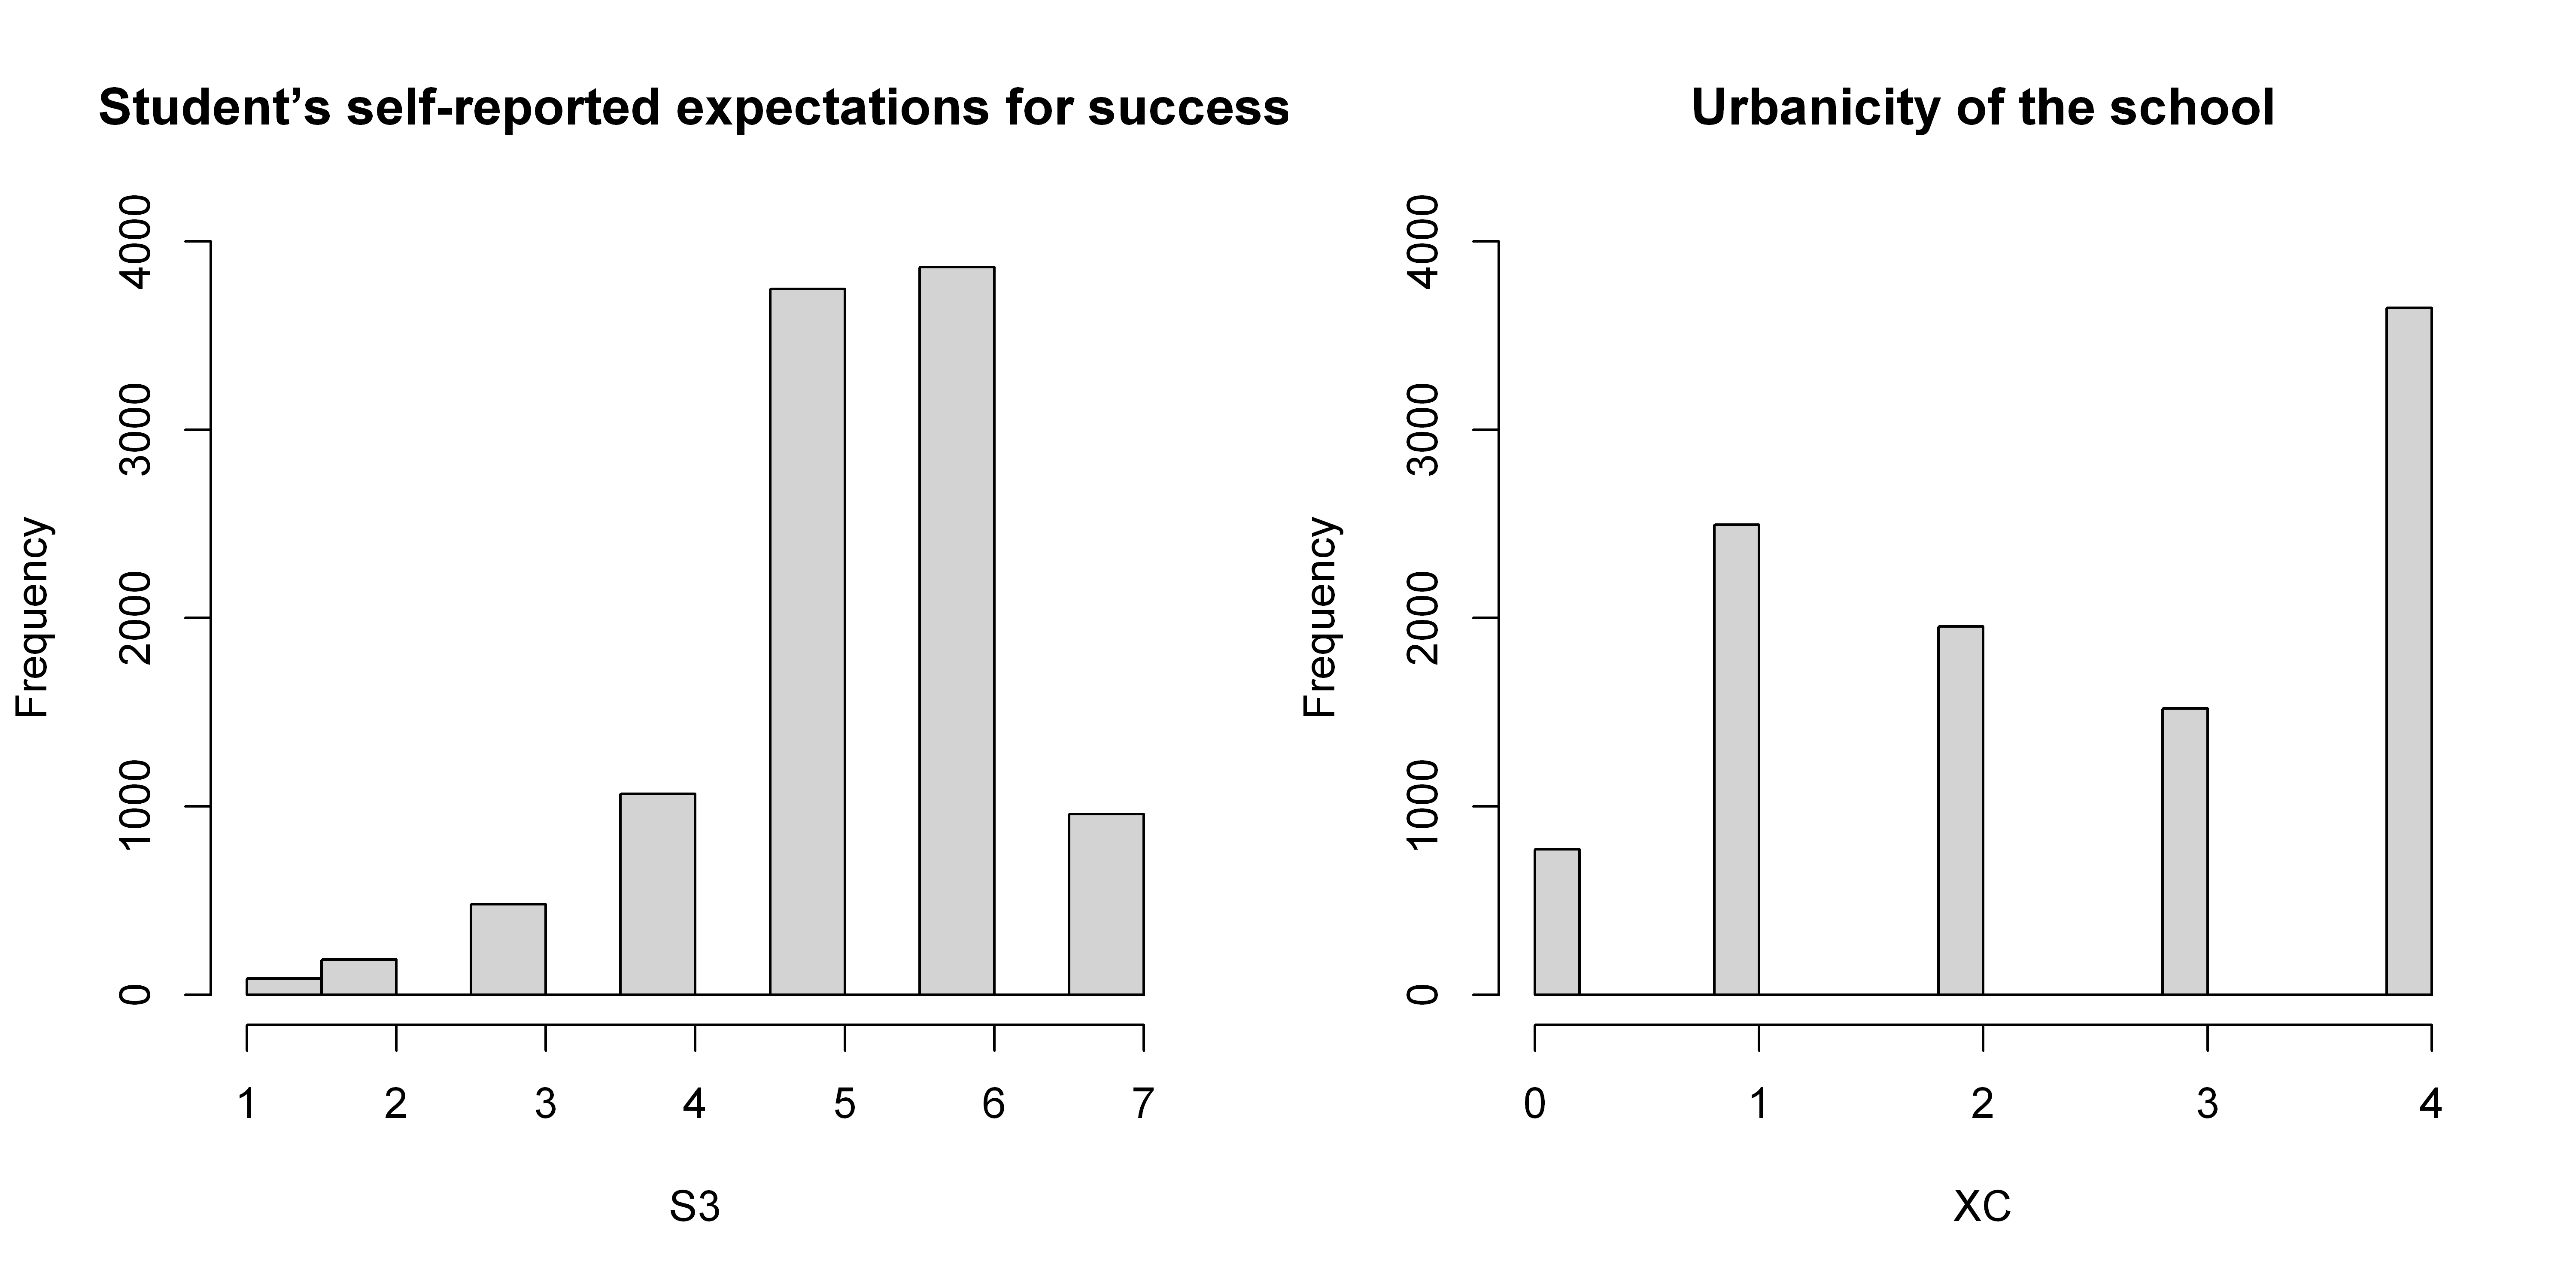

In [5]:
options(repr.plot.res = 600, repr.plot.height = 5, repr.plot.width = 10)
par("mfcol"=c(1, 2))
hist(data.all$W, main = "Student's treatment", xlim = c(0, 1), xlab = "W", ylim = c(0, 7000))
hist(data.all$C1, main = "Student's race/ethnicity", xlim = c(1, 15), xlab = "C1", ylim = c(0, 7000))
hist(data.all$C2, main = "Student's identified gender", xlim = c(1, 2), xlab = "C2", ylim = c(0, 7000))
hist(data.all$C3, main = "Student's first-generation status", xlim = c(0, 1), xlab = "C3", ylim = c(0, 7000))
hist(data.all$S3, main = "Student’s self-reported expectations for success", xlim = c(1, 7), xlab = "S3", ylim = c(0, 4000)) 
hist(data.all$XC, main = "Urbanicity of the school", xlim = c(0, 4), xlab = "XC", ylim = c(0, 4000))
par("mfcol"=c(1, 2))

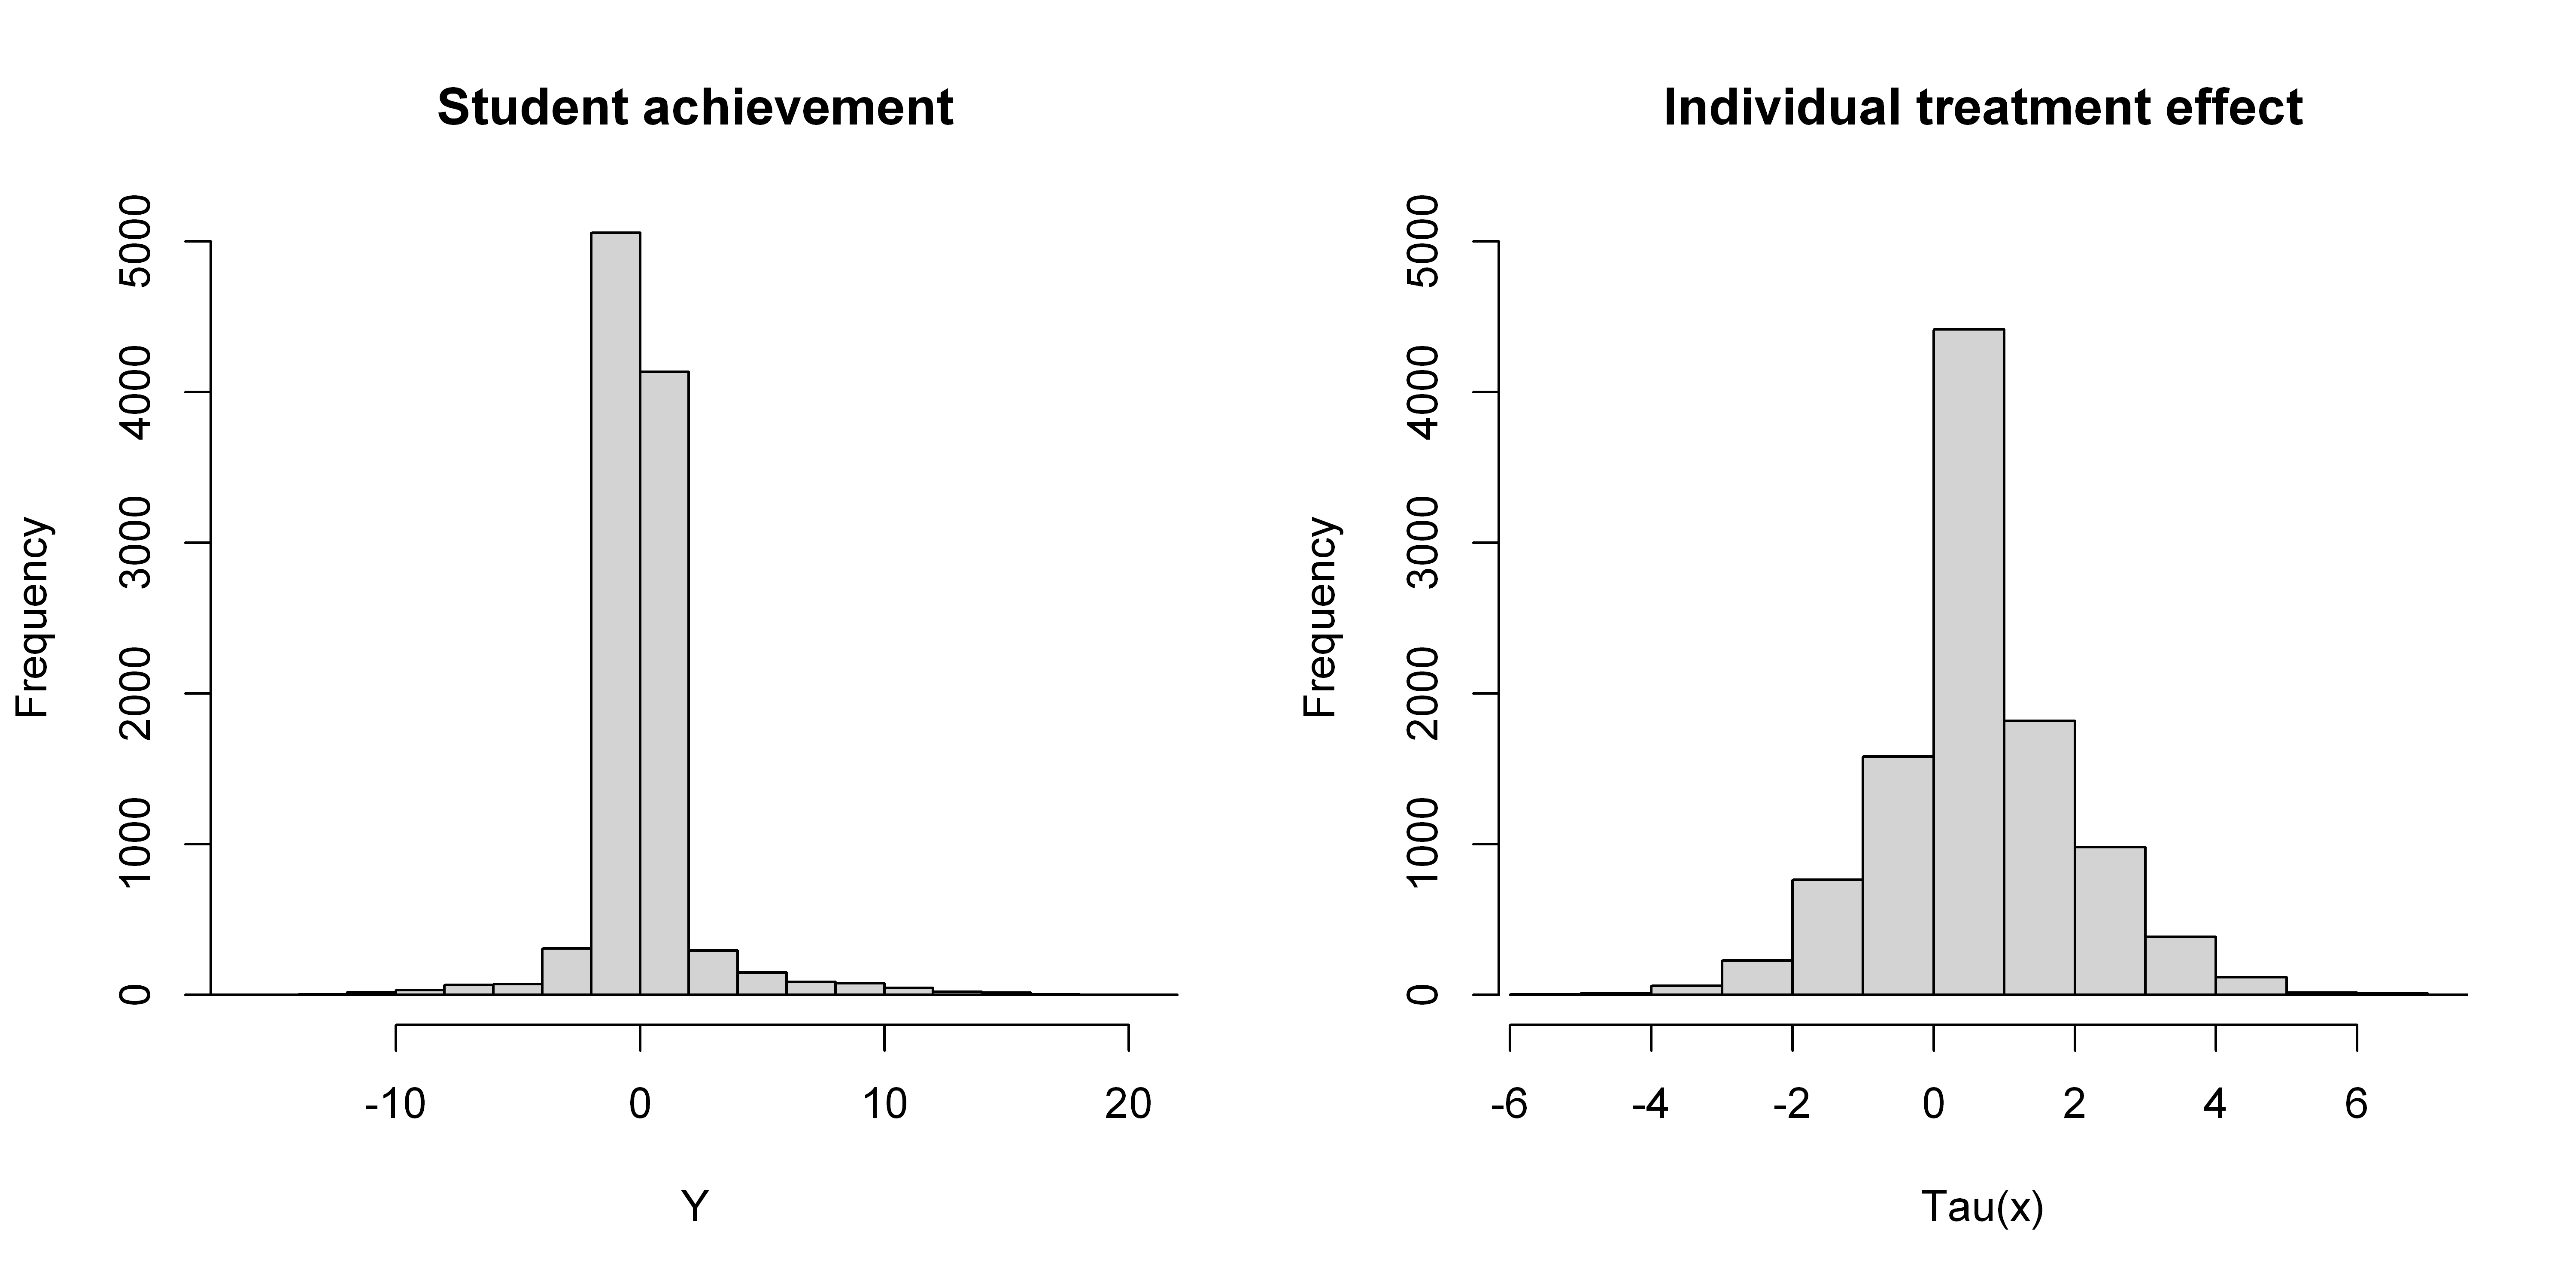

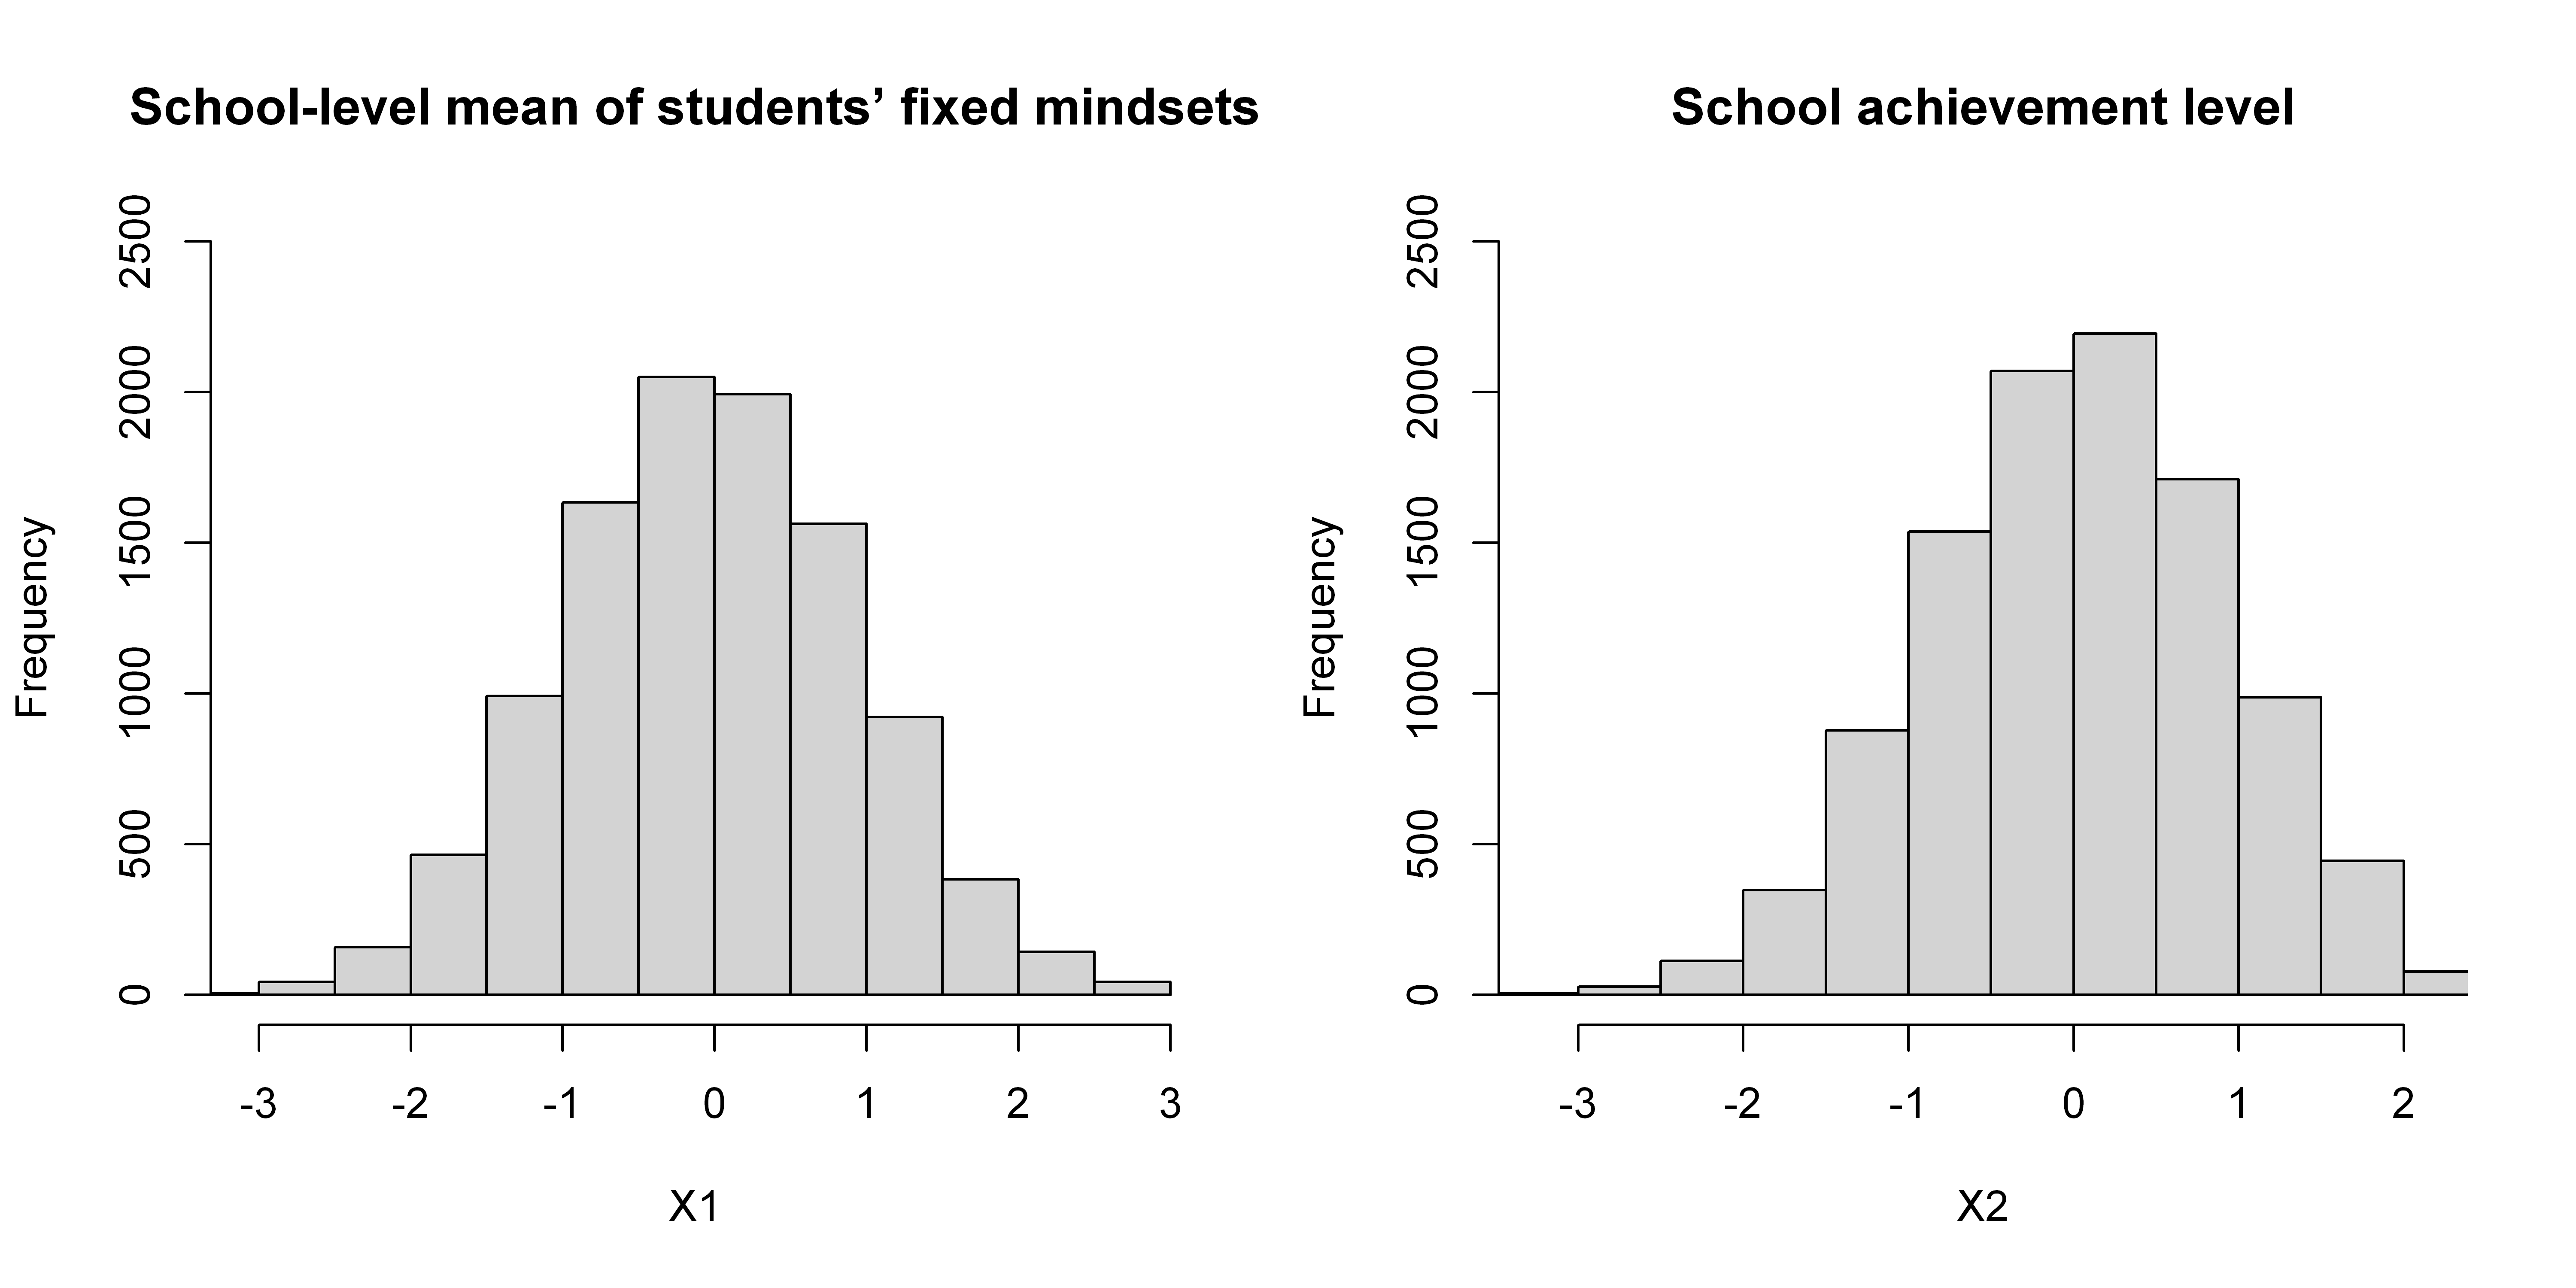

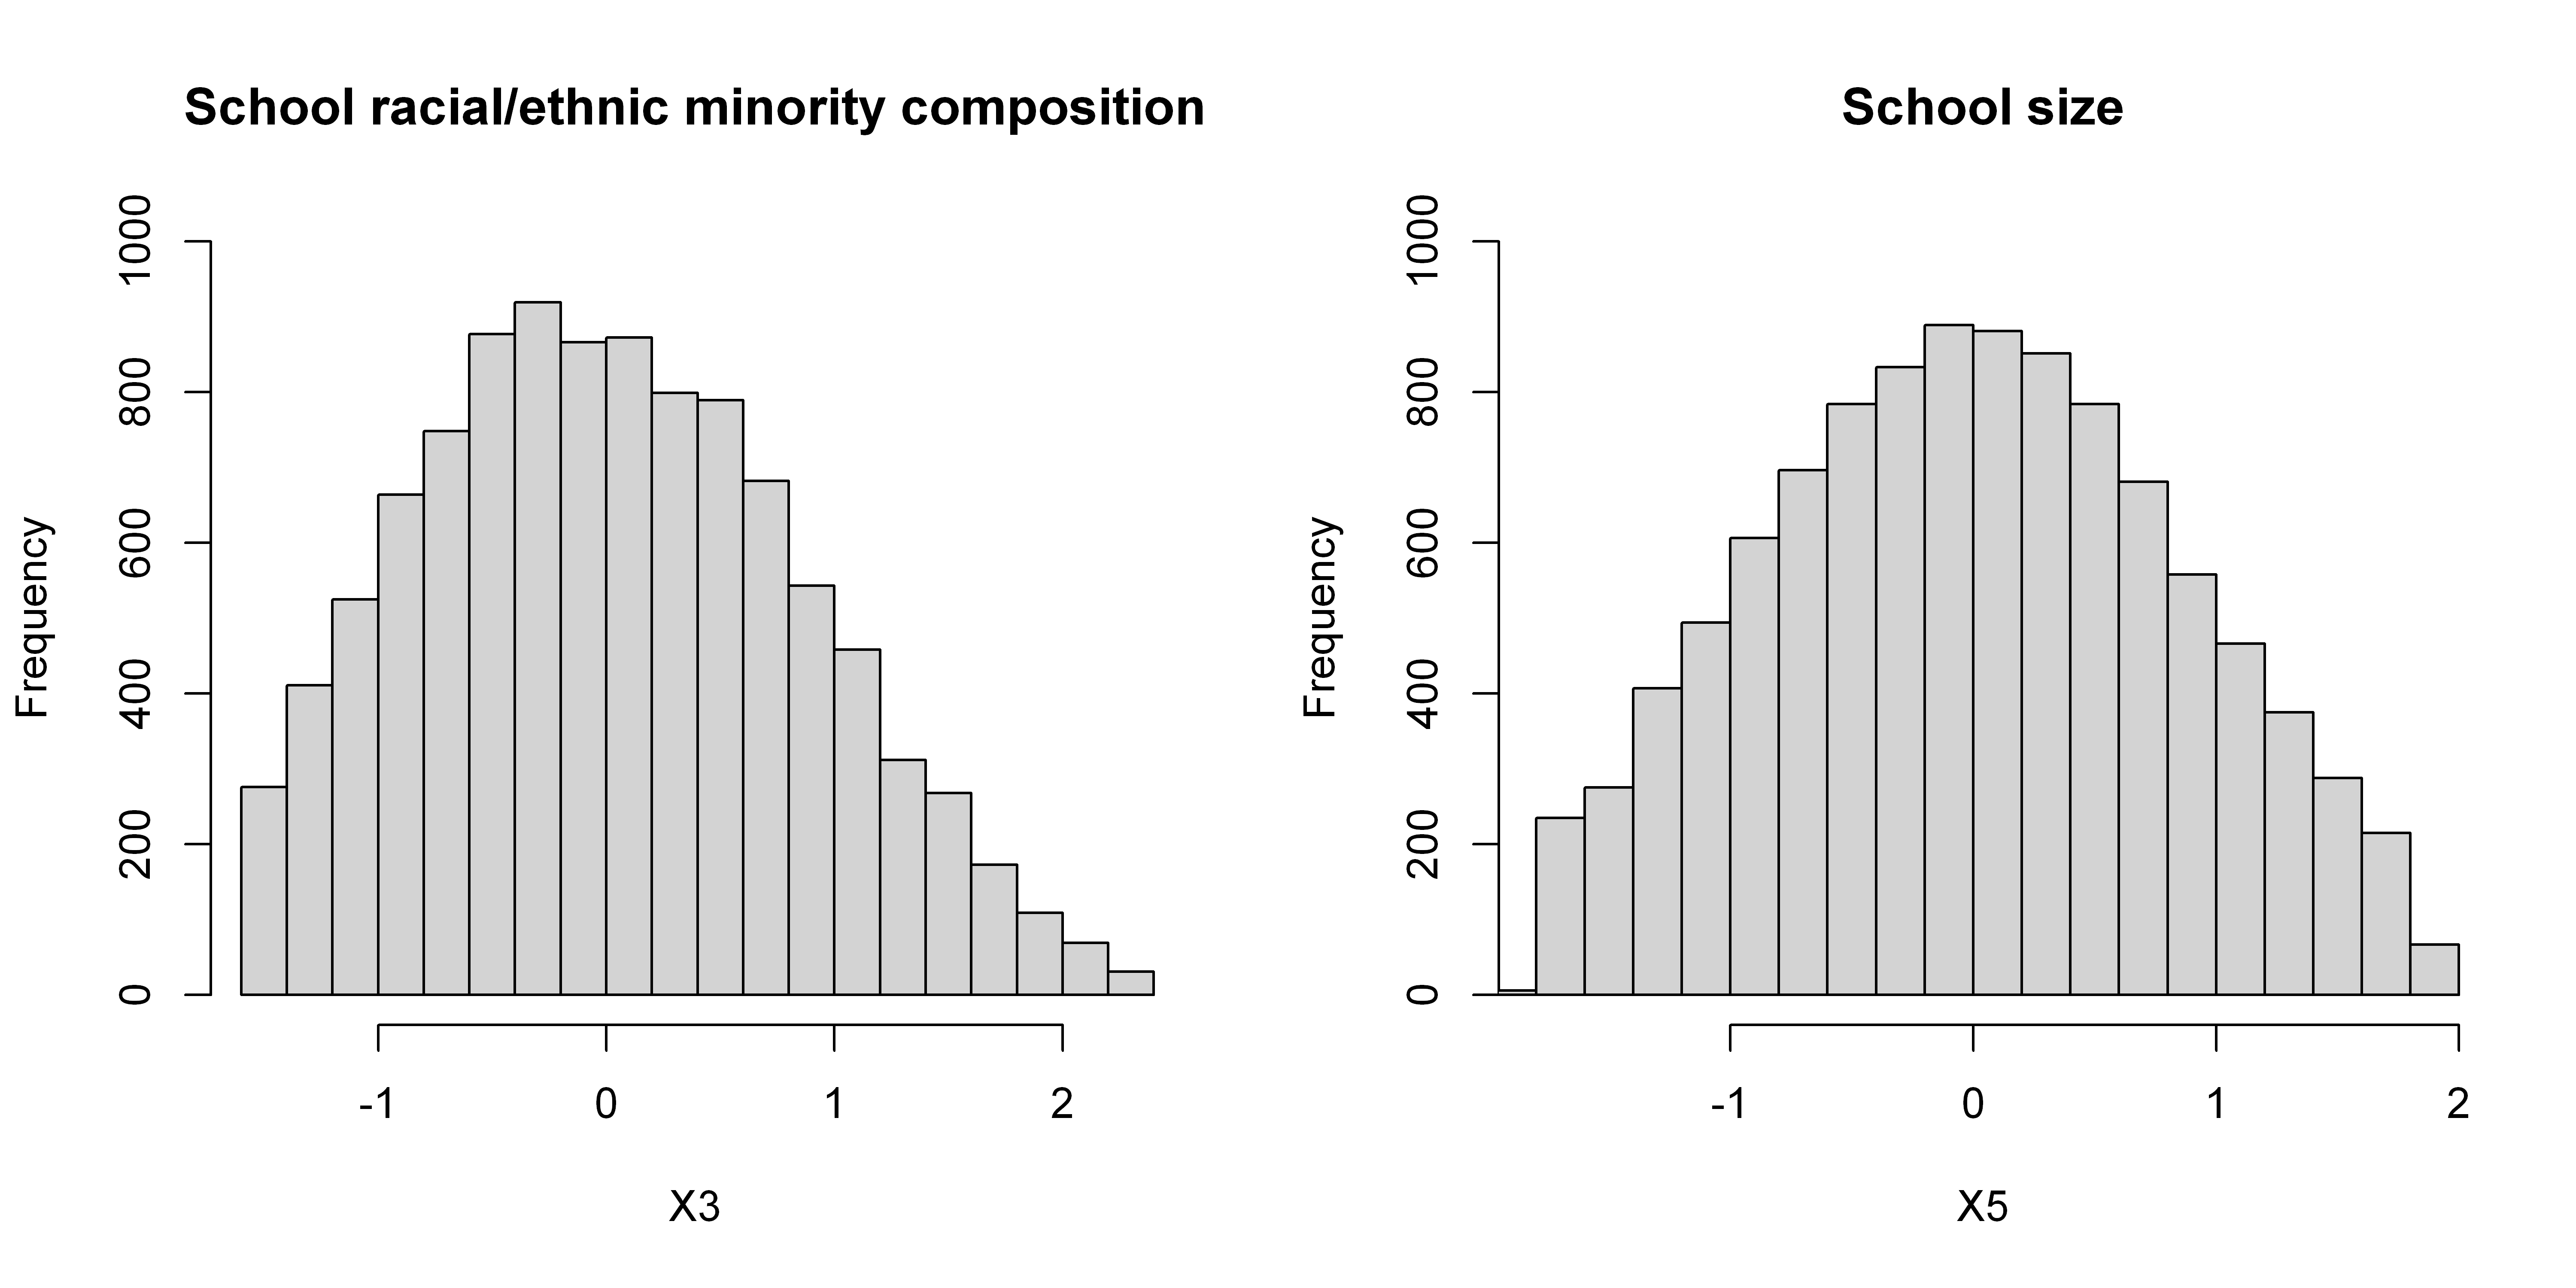

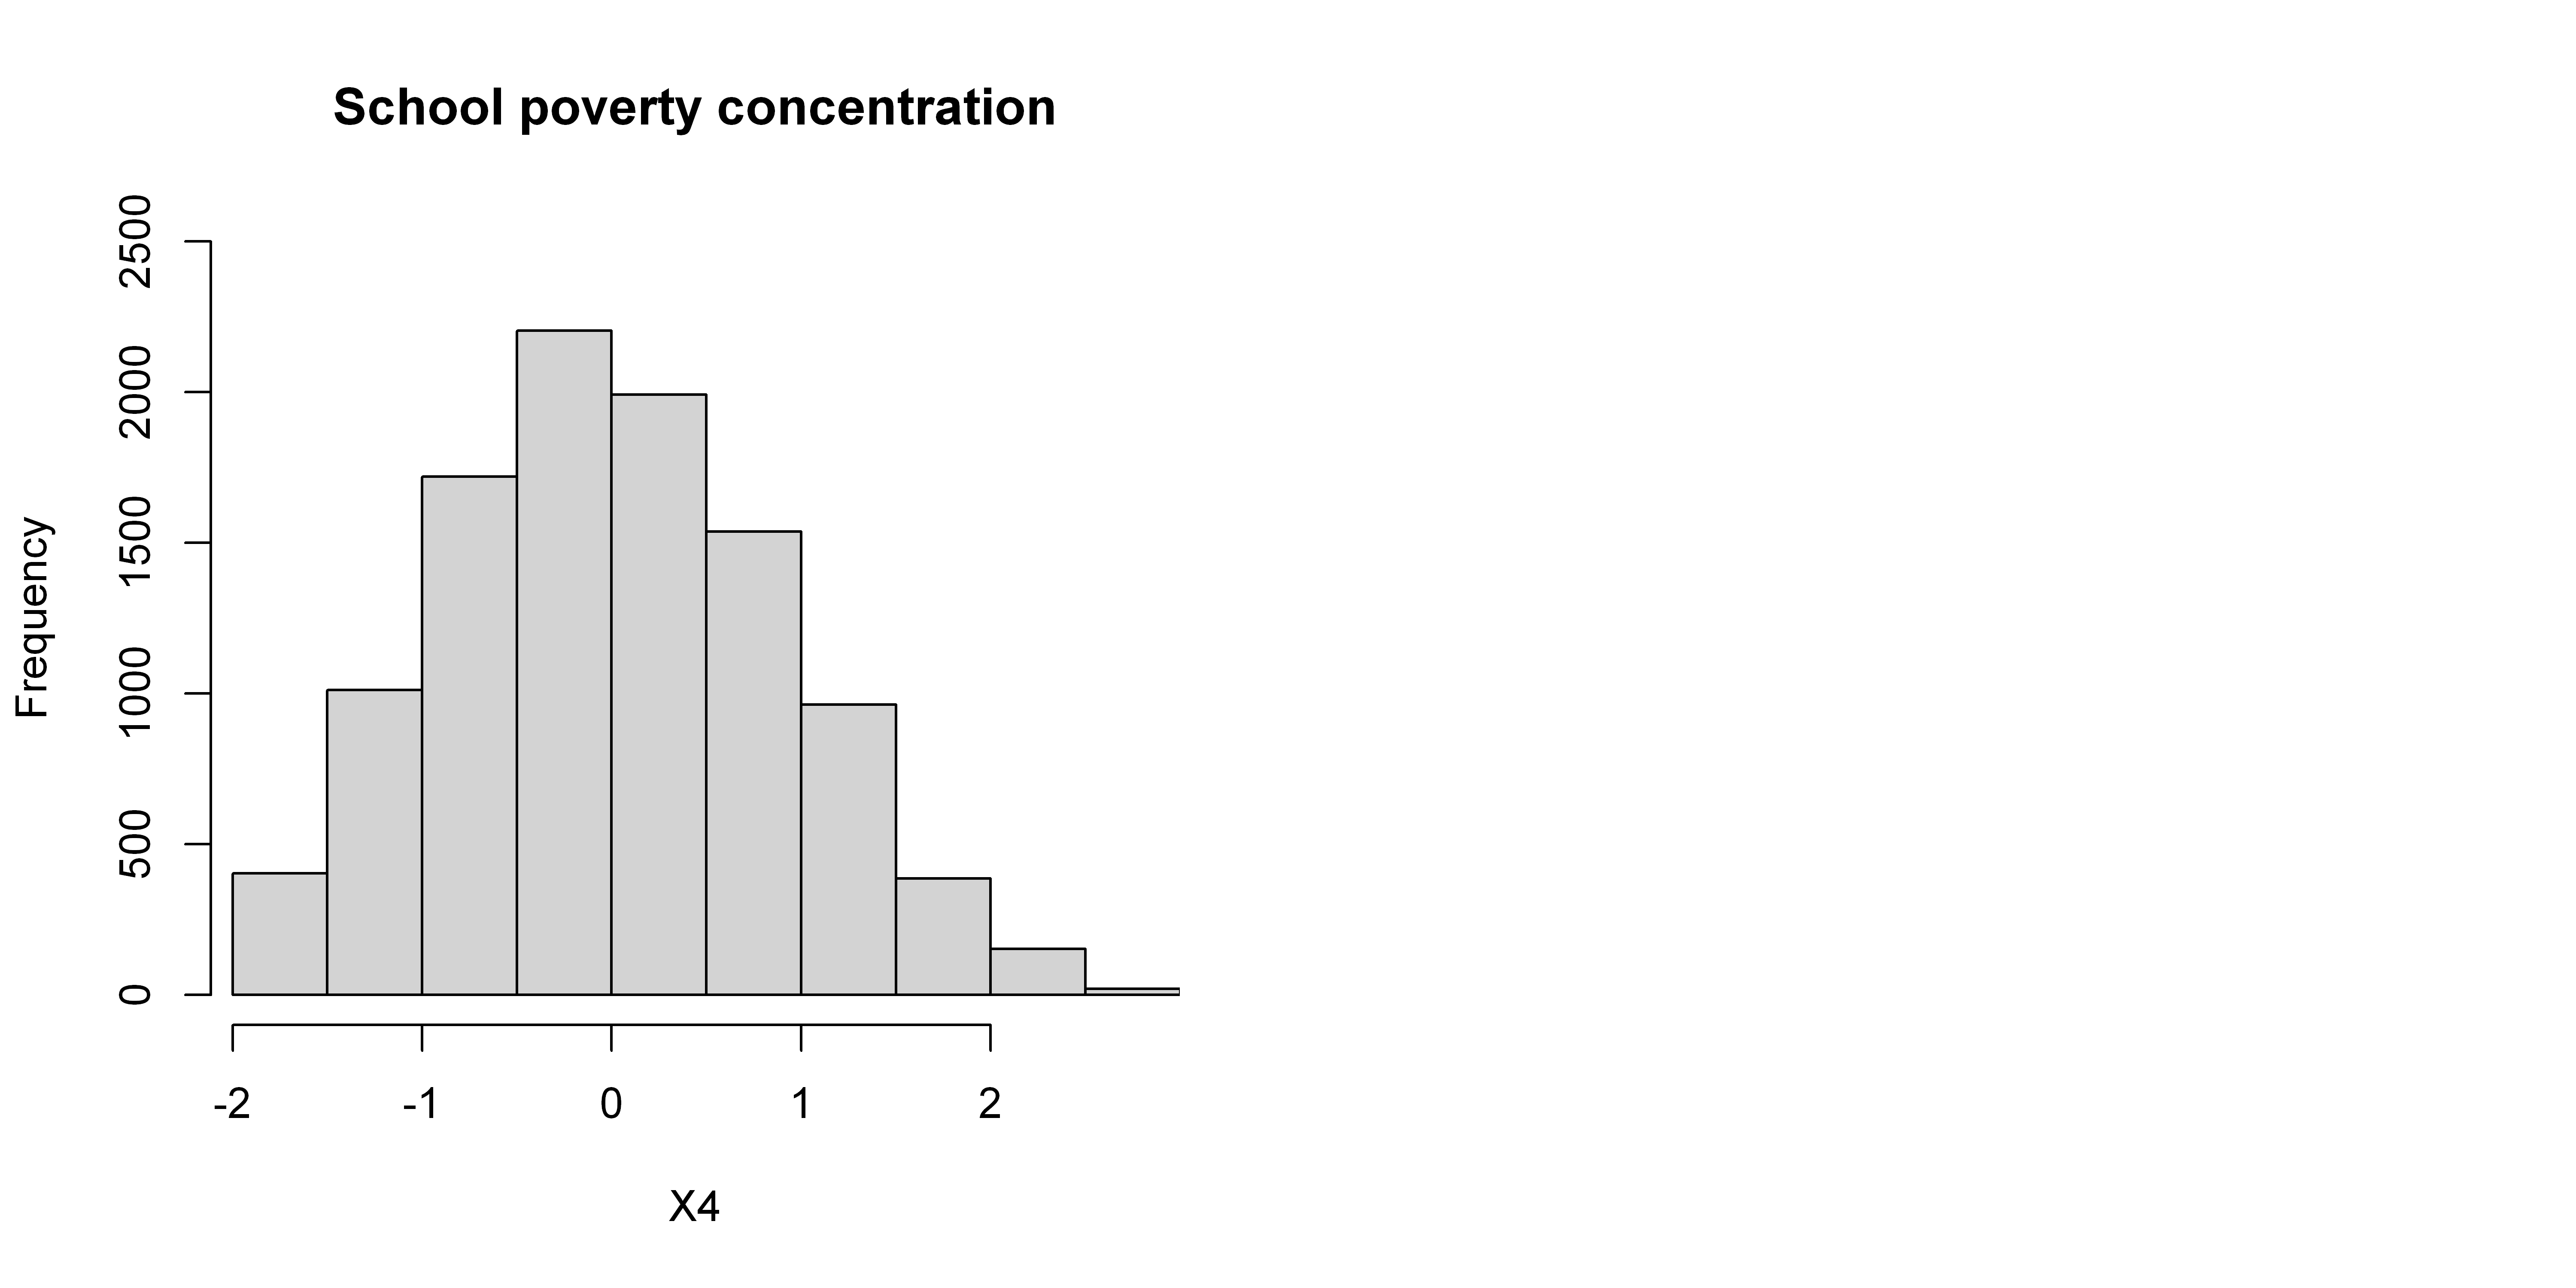

In [6]:
options(repr.plot.res = 600, repr.plot.height = 5, repr.plot.width = 10)
par("mfcol"=c(1, 2))
hist(data.all$Y, main = "Student achievement", xlim = c(min(data.all$Y), max(data.all$Y)), xlab = "Y", ylim = c(0, 5000))
hist(data.all$tau, main = "Individual treatment effect", xlim = c(min(data.all$tau), max(data.all$tau)), xlab = "Tau(x)", ylim = c(0, 5000))
hist(data.all$X1, main = "School-level mean of students’ fixed mindsets", xlim = c(min(data.all$X1), max(data.all$X1)), xlab = "X1", ylim = c(0, 2500))
hist(data.all$X2, main = "School achievement level", xlim = c(min(data.all$X2), max(data.all$X2)), xlab = "X2", ylim = c(0, 2500))
hist(data.all$X3, main = "School racial/ethnic minority composition", xlim = c(min(data.all$X3), max(data.all$X3)), xlab = "X3", ylim = c(0, 1000))
hist(data.all$X5, main = "School size", xlim = c(min(data.all$X5), max(data.all$X5)), xlab = "X5", ylim = c(0, 1000))
hist(data.all$X4, main = "School poverty concentration", xlim = c(min(data.all$X4), max(data.all$X4)), xlab = "X4", ylim = c(0, 2500))
par("mfcol"=c(1, 2))

In [7]:
defaultW <- getOption("warn") 
options(warn = -1) 
data.Y <- data.all[, c("Y", "Y.1", "Y.0", "W")]
data.Y$group[data.Y$W == 1] <- "Treatment"
data.Y$group[data.Y$W == 0] <- "Control"

In [8]:
paste("Correlation between potential outcome Y(0) and treatment assignment W:", round(cor(data.all$Y.0, data.all$W), 3))
paste("Correlation between potential outcome Y(1) and treatment assignment W:", round(cor(data.all$Y.1, data.all$W), 3))
paste("Correlation between observed outcome Y and treatment assignment W:", round(cor(data.all$Y, data.all$W), 3))

[1] "Correlation between potential outcome Y(0) and treatment assignment W: -0.001"

[1] "Correlation between potential outcome Y(1) and treatment assignment W: 0"

[1] "Correlation between observed outcome Y and treatment assignment W: 0.13"

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



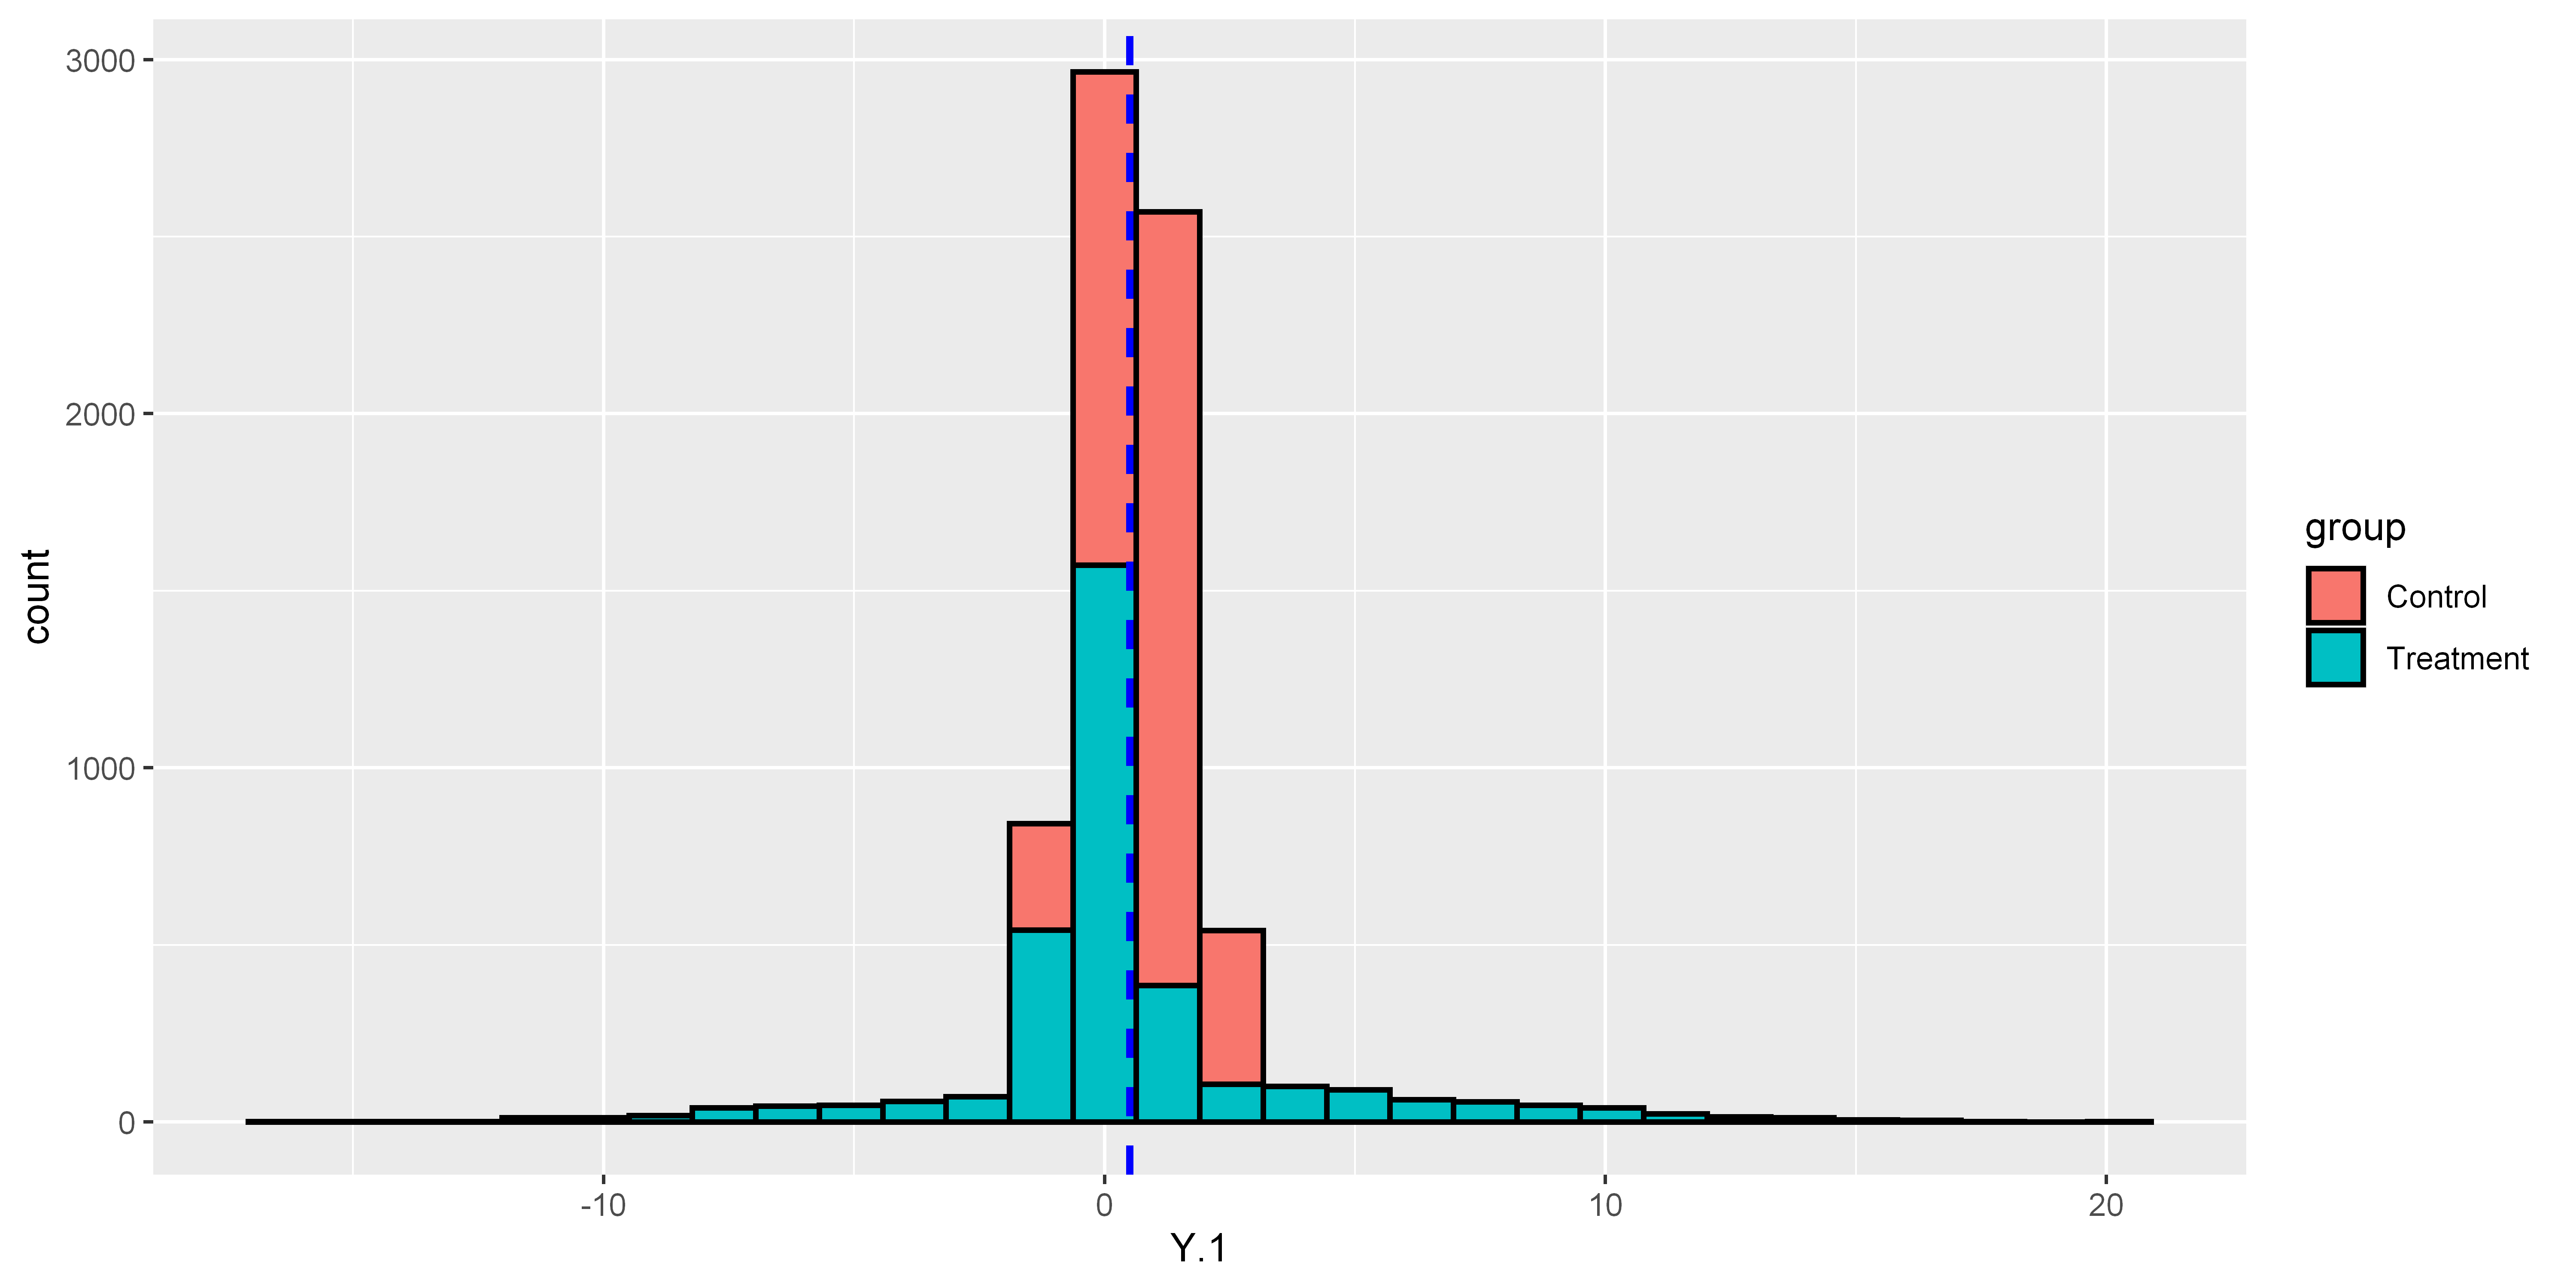

In [9]:
ggplot(data.Y, aes(x = Y.1, fill = group)) + 
geom_histogram(colour = "black", lwd = 0.75, linetype = 1, position = "identity") + 
geom_vline(aes(xintercept = mean(Y.1[group == "Treatment"])), col='black',size=1, linetype='dashed') + 
geom_vline(aes(xintercept = mean(Y.1[group == "Control"])), col='blue',size=1, linetype='dashed')

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



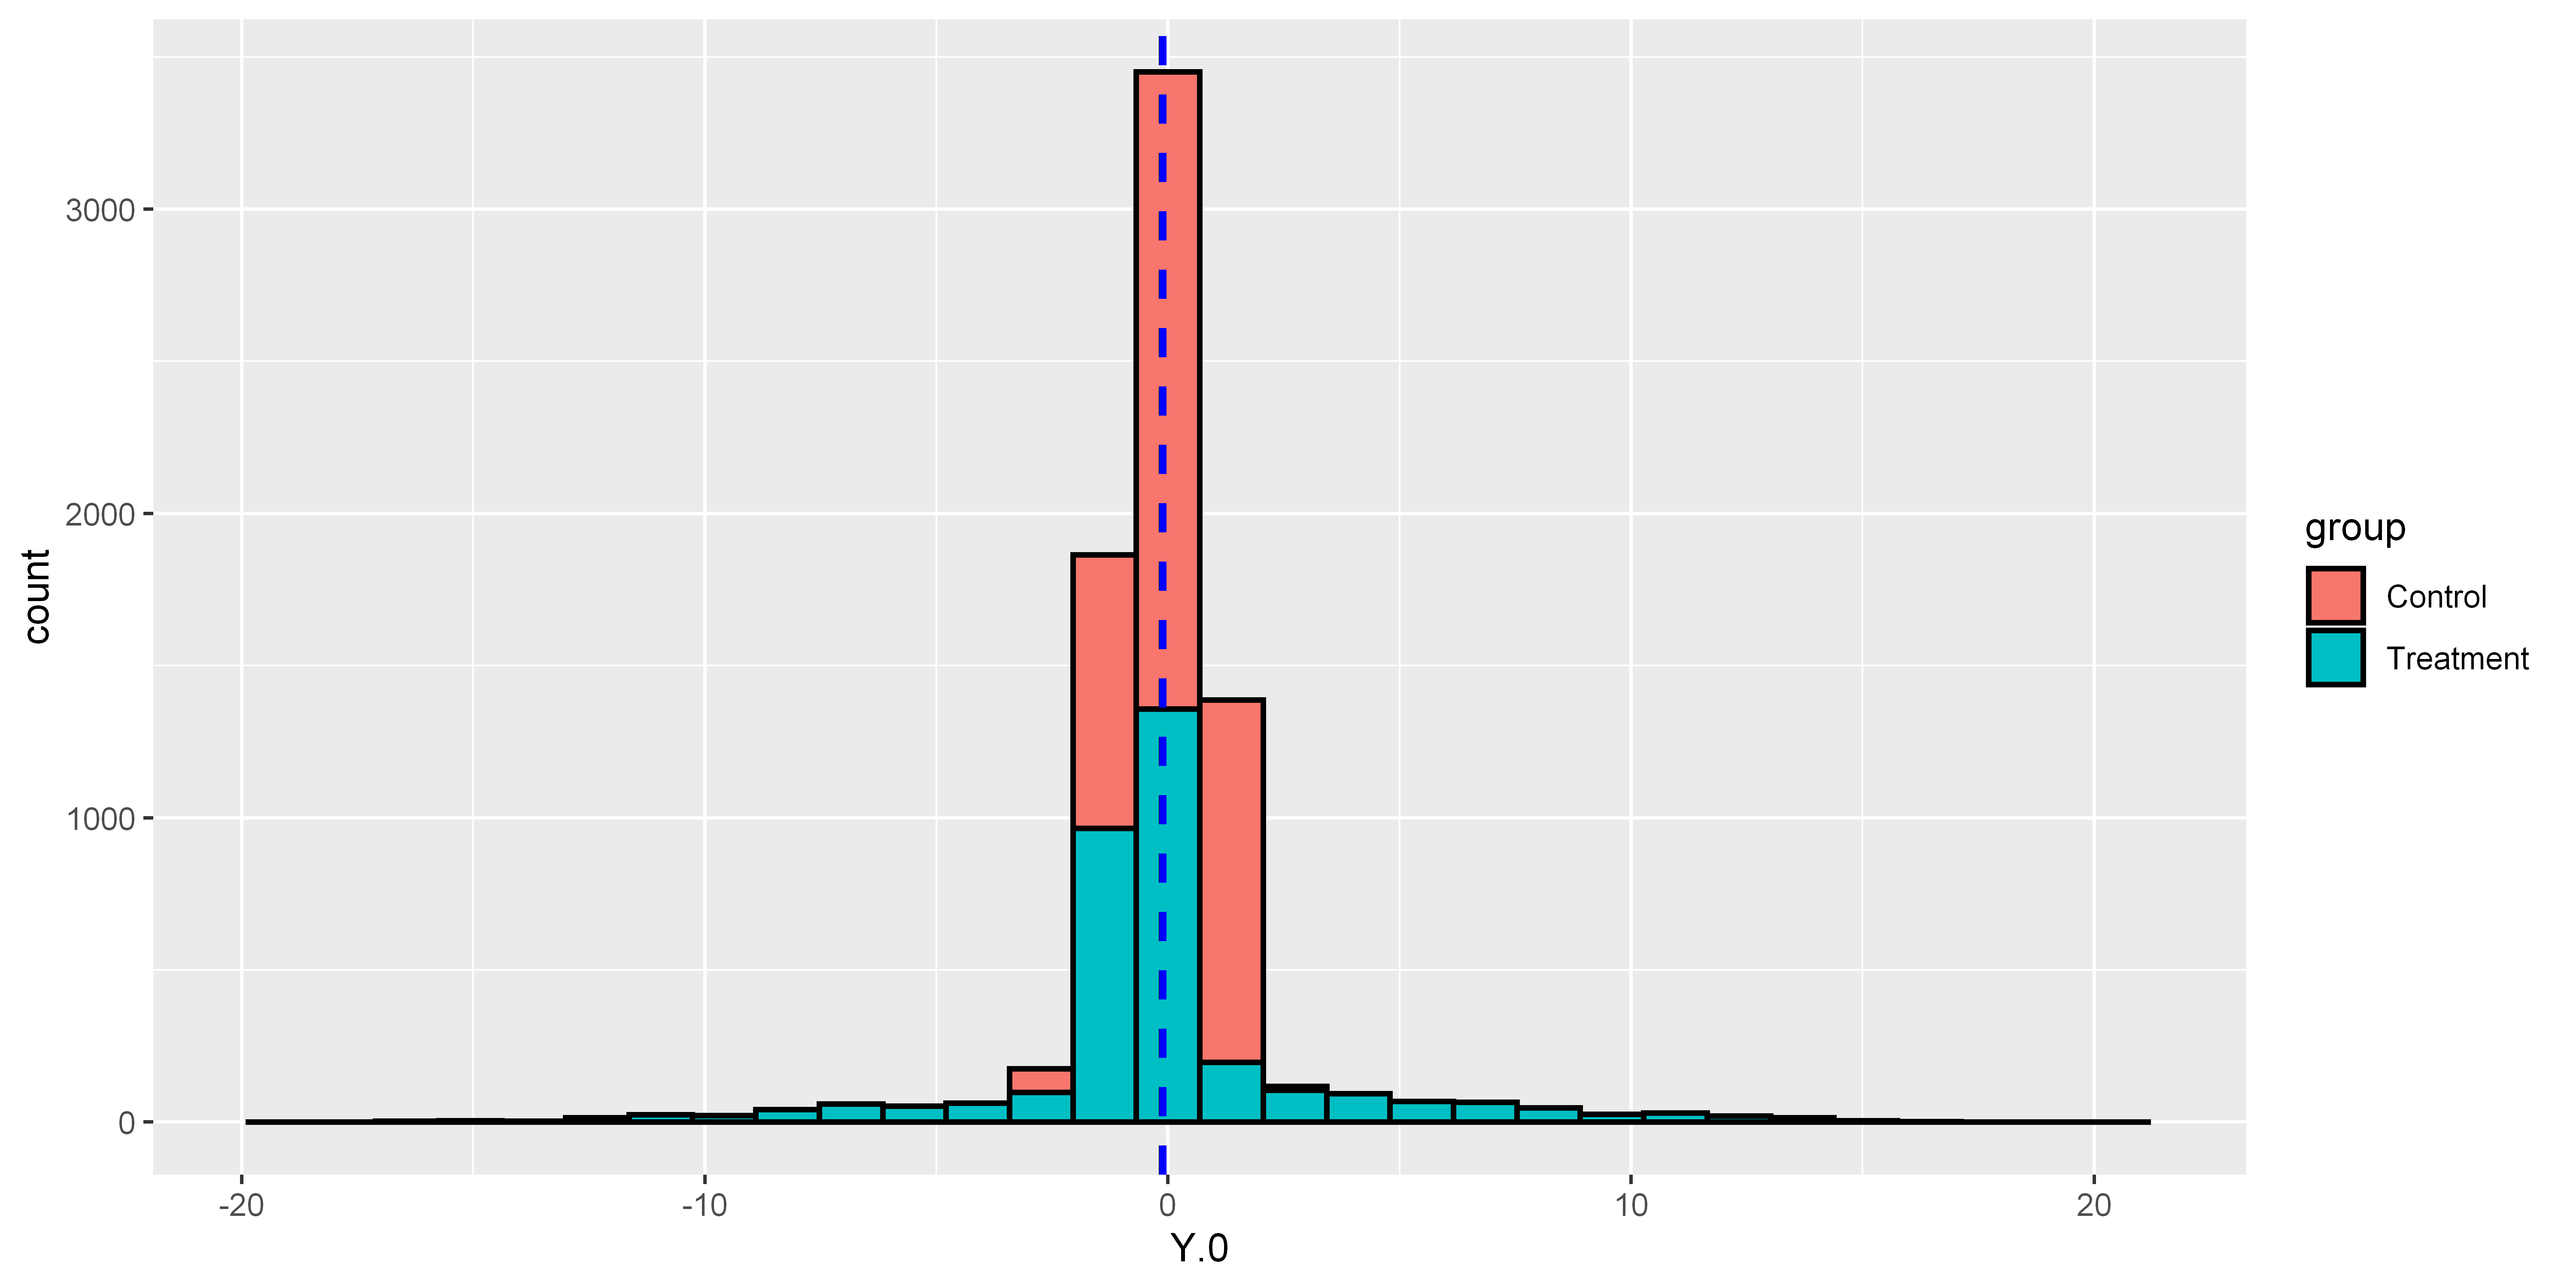

In [10]:
ggplot(data.Y, aes(x = Y.0, fill = group)) + 
geom_histogram(colour = "black", lwd = 0.75, linetype = 1, position = "identity") + 
geom_vline(aes(xintercept = mean(Y.0[group == "Treatment"])), col='black',size=1, linetype='dashed') + 
geom_vline(aes(xintercept = mean(Y.0[group == "Control"])), col='blue',size=1, linetype='dashed')

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



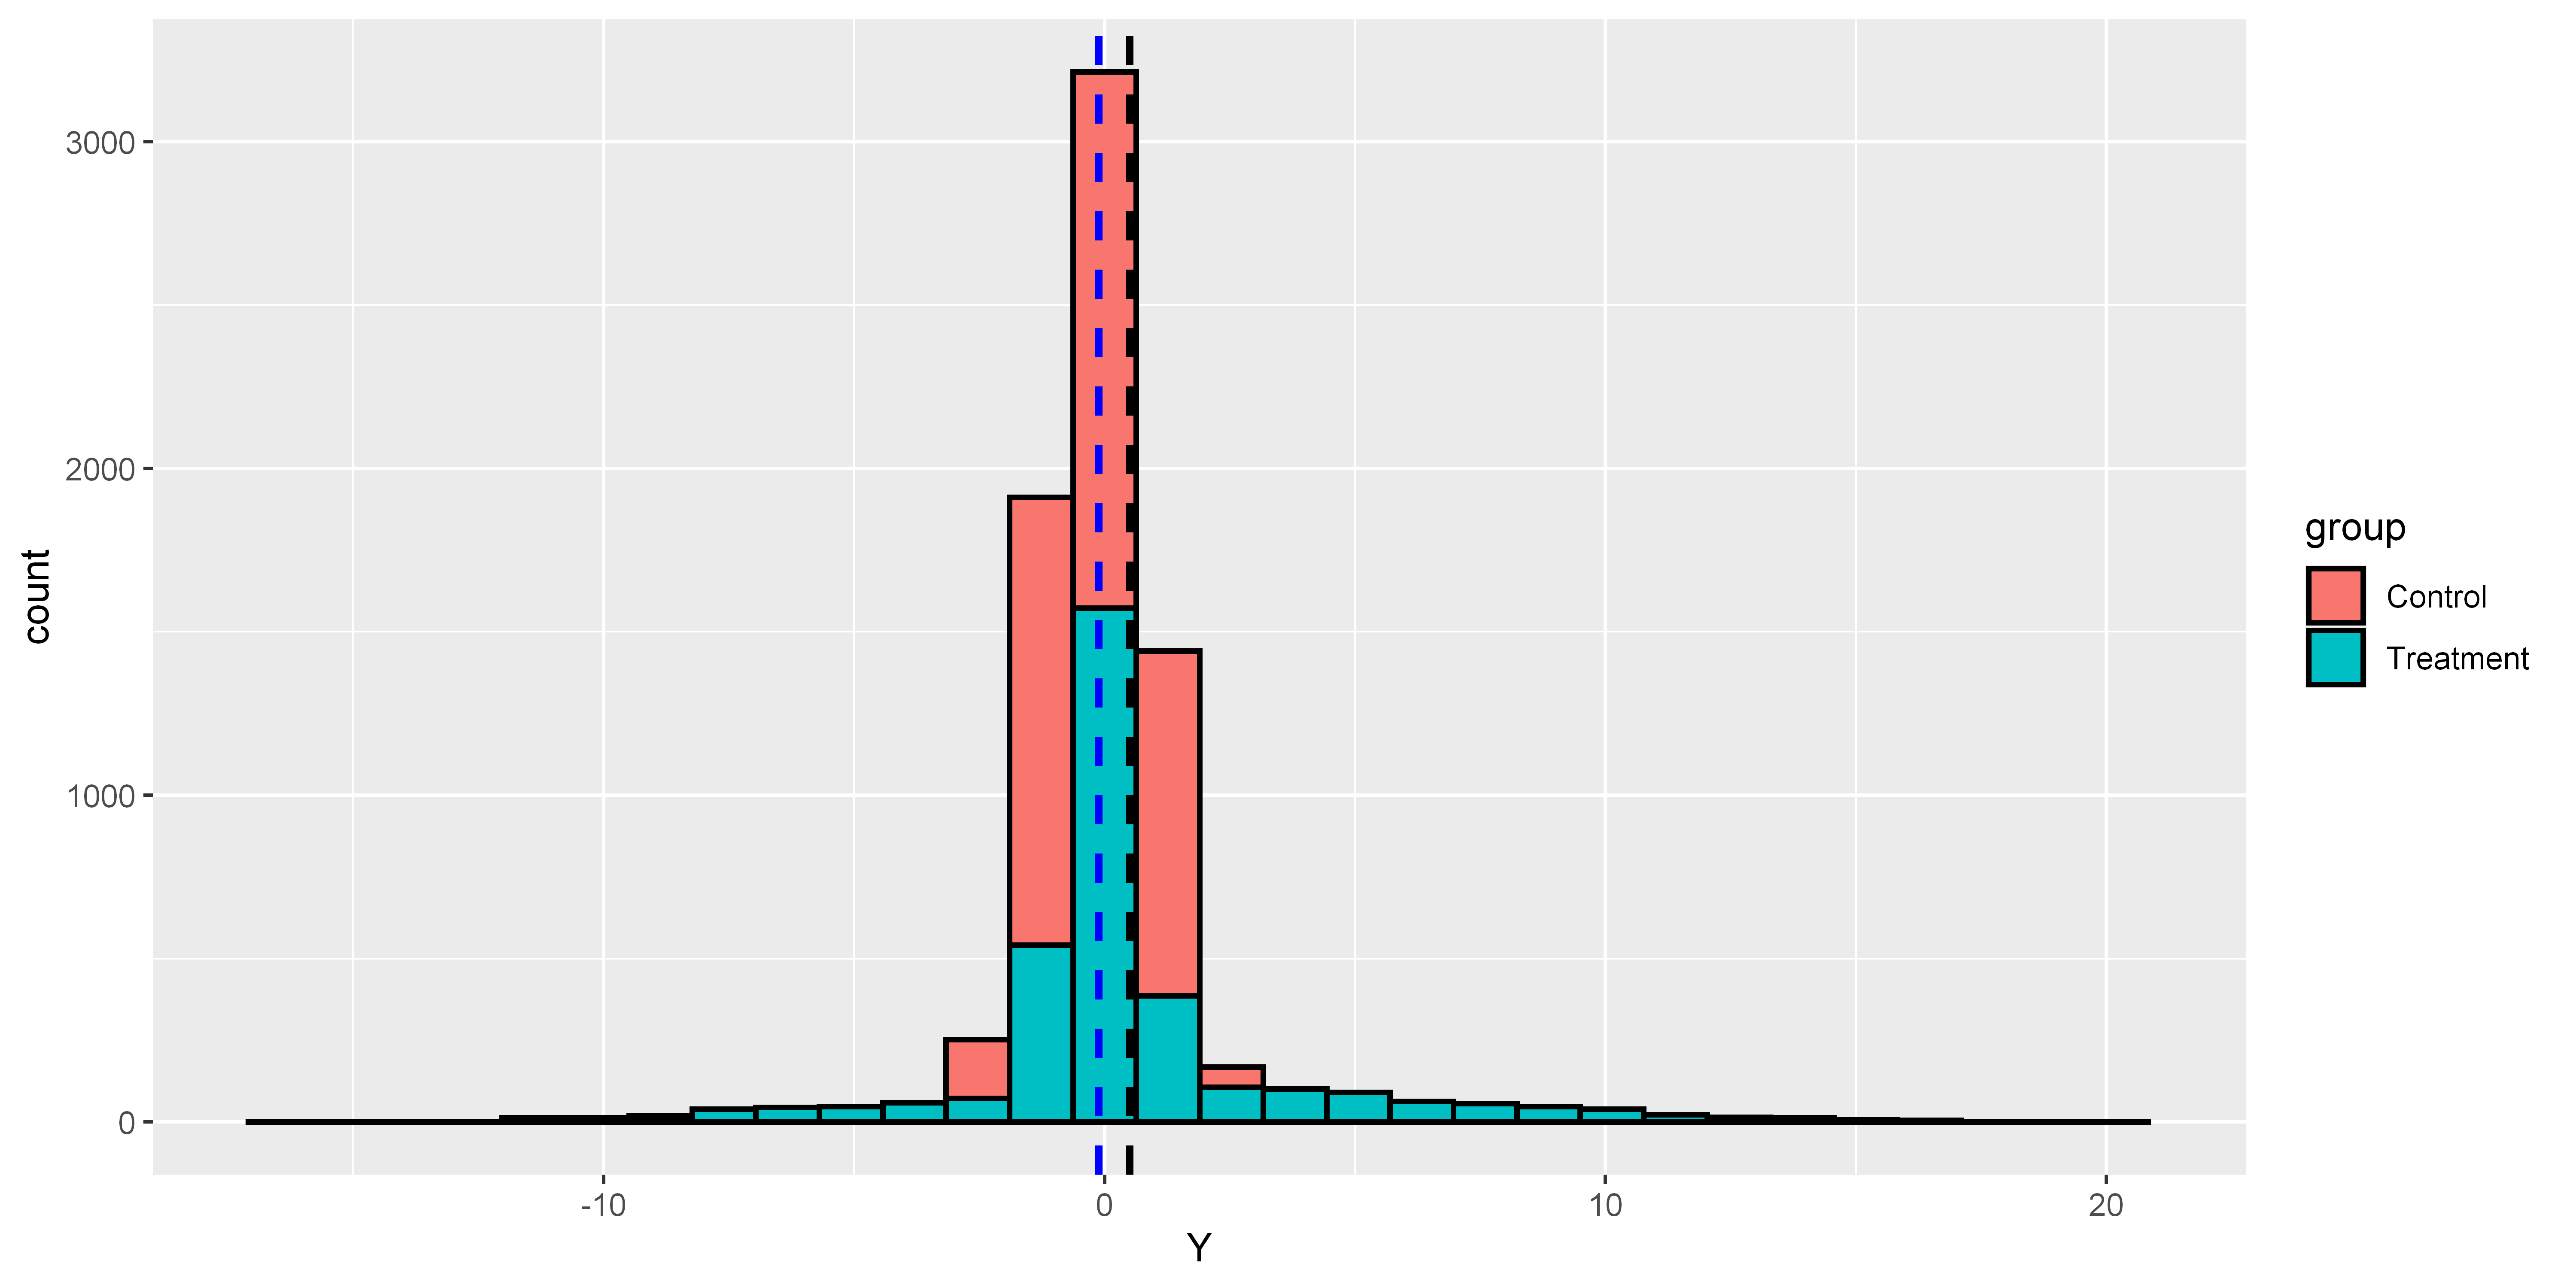

In [11]:
ggplot(data.Y, aes(x = Y, fill = group)) + 
geom_histogram(colour = "black", lwd = 0.75, linetype = 1, position = "identity") + 
geom_vline(aes(xintercept = mean(Y[group == "Treatment"])), col='black', size=1, linetype='dashed') + 
geom_vline(aes(xintercept = mean(Y[group == "Control"])), col='blue', size=1, linetype='dashed')

**Exercise 1.2**

**Causal Random Forest**

(**Cluster-robust causal forests**, following Susan Athey and Stefan Wager (2019))

**grf** algorithm:

Trains a causal forest that can be used to estimate conditional average treatment effects tau(X). When the treatment assignment W is binary and unconfounded, we have tau(X) = E[Y(1) - Y(0) | X = x], where Y(0) and Y(1) are potential outcomes corresponding to the two possible treatment states. When W is continuous, we effectively estimate an average partial effect Cov[Y, W | X = x] / Var[W | X = x], and interpret it as a treatment effect given unconfoundedness.

1. Predict Y from X using Random Forest, collect Y.hat
2. Predict W from X using Random Forest, collect W.hat = P[W | X = x]
3. Note: school ids are treated as clusters, draw the same # of observations per cluster

Conditional Average Treatment Effect:

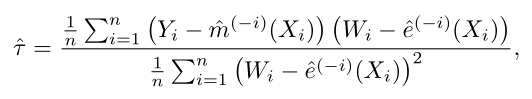

In [12]:
defaultW <- getOption("warn") 
options(warn = -1) 

X <- data.all[, c("X1", "X2")]
Y <- data.all$Y
W <- data.all$W
school.id <- as.numeric(data.all$schoolid)

Y.forest <- regression_forest(X, Y, clusters = school.id, equalize.cluster.weights = TRUE)
Y.hat <- predict(Y.forest)$predictions
W.forest <- regression_forest(X, W, clusters = school.id, equalize.cluster.weights = TRUE)
W.hat <- predict(W.forest)$predictions

cf.raw <- causal_forest(X, Y, W,
                       Y.hat = Y.hat, W.hat = W.hat,
                       clusters = school.id,
                       equalize.cluster.weights = TRUE)
ATE <- average_treatment_effect(cf.raw)

**Linear Regression**

Conditional Average Treatment Effect

In [13]:
ols <- lm(Y ~ W + ., data=data.frame(Y, W, X))
fit <- summary(ols)
se <- sqrt(diag(vcov(fit)))
summary(ols)


Call:
lm(formula = Y ~ W + ., data = data.frame(Y, W, X))

Residuals:
     Min       1Q   Median       3Q      Max 
-14.8788  -0.9988  -0.1405   0.7685  18.1221 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) -0.10641    0.02512  -4.237 2.29e-05 ***
W            0.62557    0.04395  14.234  < 2e-16 ***
X1          -0.19620    0.02141  -9.165  < 2e-16 ***
X2          -0.65773    0.02292 -28.702  < 2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 2.1 on 10387 degrees of freedom
Multiple R-squared:  0.09597,	Adjusted R-squared:  0.09571 
F-statistic: 367.6 on 3 and 10387 DF,  p-value: < 2.2e-16


**Compare the results from a linear regression estimate of the treatment effect and the causal (random) forest to answer question 1 from above.**

Was the mindset intervention effective in improving student achievement?

In [14]:
paste("(True) Average Treatment Effect:", round(mean(data.all$tau), 3))
paste("Causal forest: 95% CI for the ATE:", round(ATE[1], 3),
       "+/-", round(qnorm(0.975)*ATE[2], 3))
paste("Linear regression: 95% CI for the ATE:", round(ols$coefficients[2], 3),
      "+/-", round(qnorm(0.975)*se[2], 3))

[1] "(True) Average Treatment Effect: 0.614"

[1] "Causal forest: 95% CI for the ATE: 0.637 +/- 0.144"

[1] "Linear regression: 95% CI for the ATE: 0.626 +/- 0.086"

In [15]:
tau_hat <- predict(cf.raw)$predictions
data.tau.hat <- data.frame(tau_hat)
data.tau.hat$group <- "(Predicted) TE"
names(data.tau.hat) <- c("tau", "group")

data.tau.true <- data.frame(data.all$tau)
data.tau.true$group <- "(True) TE"
names(data.tau.true) <- c("tau", "group")

data.tau <- rbind(data.tau.hat, data.tau.true)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



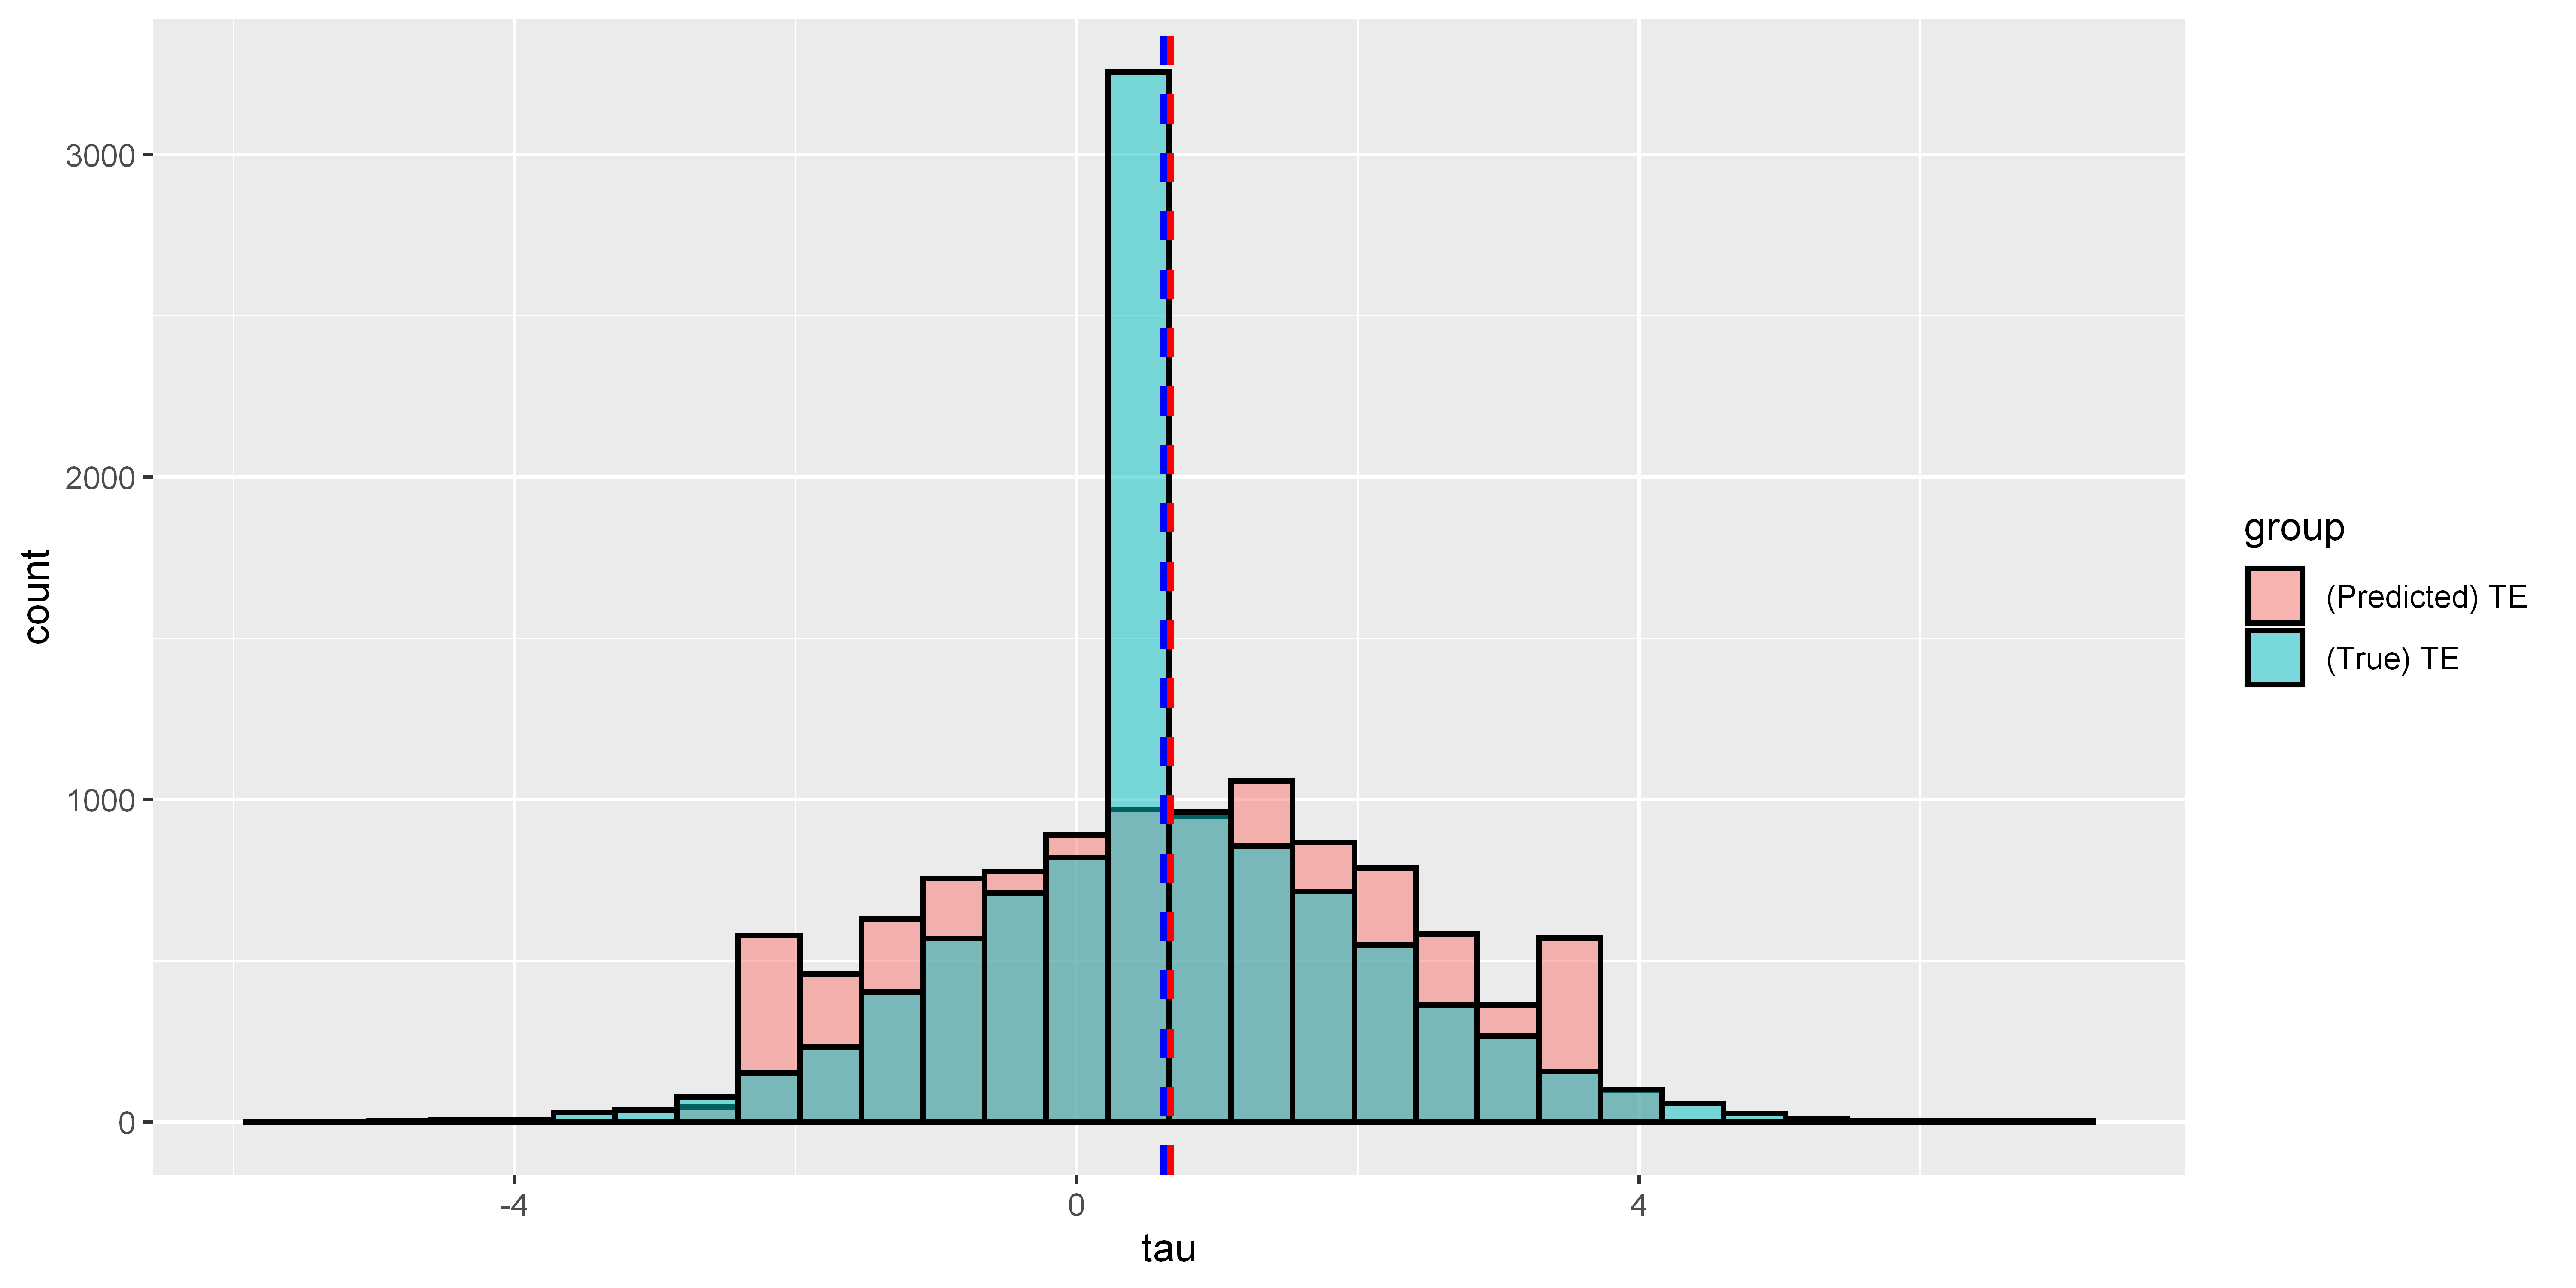

In [16]:
ggplot(data.tau, aes(x = tau, fill = group)) + 
geom_histogram(colour = "black", lwd = 0.75, linetype = 1, position = "identity", alpha = 0.5) + 
geom_vline(aes(xintercept = mean(tau[group == "(Predicted) TE"])),col='red',size=1, linetype='dashed') + 
geom_vline(aes(xintercept = mean(tau[group == "(True) TE"])),col='blue',size=1, linetype='dashed')

# **Exercise 2:**

**Induce moderation of the treatment effect and evaluate the relative performance of causal (random) forests
and a linear model with simple interactions for four different sample sizes.**

In [17]:
defaultW <- getOption("warn") 
options(warn = -1) 

data.tau.sample.size <- data.frame(t(rep(NA, 6)))
names(data.tau.sample.size) <- c("sample.size", "ATE.true", "ATE.hat.cf", "ATE.hat.cf.range", "ATE.hat.ols", "ATE.hat.ols.range")
row <- 0

for (sample_size in c(200, 400, 600, 1000)) {
    row <- row + 1
    data.all <- dgp(sample_size)

    X <- data.all[, c("X1", "X2", "X3", "X4", "X5")]
    Y <- data.all$Y
    W <- data.all$W
    school.id <- as.numeric(data.all$schoolid)

    Y.forest <- regression_forest(X, Y, clusters = school.id, equalize.cluster.weights = TRUE)
    Y.hat <- predict(Y.forest)$predictions
    W.forest <- regression_forest(X, W, clusters = school.id, equalize.cluster.weights = TRUE)
    W.hat <- predict(W.forest)$predictions

    cf.raw <- causal_forest(X, Y, W,
                       Y.hat = Y.hat, W.hat = W.hat,
                       clusters = school.id,
                       equalize.cluster.weights = TRUE)
    ATE <- average_treatment_effect(cf.raw)
    ATE.cf.range <- paste("+/-", round(qnorm(0.975)*ATE[2], 3))

    ols <- lm(Y ~ W + X1*W + X2*W + ., data=data.frame(Y, W, X))
    fit <- summary(ols)
    se <- sqrt(diag(vcov(fit)))
    ATE.ols.range <- paste("+/-", round(qnorm(0.975)*se[2], 3))
    
    data.tau.sample.size[row, ]  <- c(sample_size, round(mean(data.all$tau), 3), round(ATE[1], 3), ATE.cf.range,  
                                      round(ols$coefficients[2], 3), ATE.ols.range)
}

In [18]:
data.tau.sample.size

,sample.size,ATE.true,ATE.hat.cf,ATE.hat.cf.range,ATE.hat.ols,ATE.hat.ols.range
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,200,0.805,0.991,+/- 1.061,1.046,+/- 0.583
2,400,1.702,1.323,+/- 0.821,1.73,+/- 0.425
3,600,0.299,0.346,+/- 0.577,0.536,+/- 0.327
4,1000,2.728,2.594,+/- 0.418,2.899,+/- 0.235


**Exercise 2.1: Sequentially introduce higher level interactions in the DGP to reproduce a scenario outlined in question 2.**

In [19]:
synthetic_data <- read.csv("D:/data/synthetic_data.csv")
set.seed(57) 

dgp2 <- function(n) { 

  data <- synthetic_data[sample(nrow(synthetic_data), n), ]
  data <- rename(data, W = Z)
  data <- arrange(data, desc(W))
  df <- data[, -c(1)]
  var_name <- names(df)
  stats <- as.data.frame(t(stat.desc(df)))
  cat_var <- c()
  num_var <- c()
  sim_data <- data$schoolid

  for (i in 1:ncol(df)) {
    if (class(df[, i]) == "integer") {
    cat_var <- c(cat_var, var_name[i])
    x <- sort(unique(df[, i]))
    freq <- as.data.frame(table(df[, i]))[2]
    sim <- sample(x, nrow(df), replace = TRUE, prob = freq$Freq)
    }
    else {
      num_var <- c(num_var, var_name[i])
      sim <- rtnorm(n = stats$nbr.val[i], mean = stats$mean[i],
                    sd = stats$std.dev[i], lower = stats$min[i], upper = stats$max[i])
      }
    sim_data <- data.frame(sim_data, a = sim)
    }
    
  names(sim_data) <- names(data)
  eps <- rnorm(nrow(sim_data), 0, 1)
  eta <- rnorm(nrow(sim_data), 0, 2)
    
  for (i in 1:length(data$W[data$W == 1])) {
      sim_data$tau[i] <- 1 + 3 * ifelse(sim_data$X1[i] < mean(sim_data$X1[i]), 1, 0) - 
      2 * ifelse(sim_data$X2[i] < mean(sim_data$X2[i]), 1, 0) + 
      1 * ifelse(sim_data$X3[i] < mean(sim_data$X3[i]), 1, 0) - eta[i] 
    
      sim_data$Y[i] <- 1 + sim_data$X1[i] - 1/2 * sim_data$X2[i] + 
      1/3 * sim_data$X3[i] - 1/4 * sim_data$X4[i] + 1/5 * sim_data$X5[i] + sim_data$W[i] + 
      sim_data$X1[i] * sim_data$W[i] - 2 * sim_data$X2[i] * sim_data$W[i] + 3 * sim_data$X3[i] * sim_data$W[i] + eps[i] 
  }
  
  sim_data$Y.0 <- sim_data$Y
  sim_data$Y.1 <- sim_data$Y
    
  sim_data$Y.0[sim_data$W == 1] <- sim_data$Y[sim_data$W == 1] - sim_data$tau[sim_data$W == 1] * sim_data$W[sim_data$W == 1]
  sim_data$Y.1[sim_data$W == 1] <- sim_data$Y.0[sim_data$W == 1] + sim_data$tau[sim_data$W == 1]
  sim_data$Y.0[sim_data$W == 0] <- rep(mean(sim_data$Y.0[sim_data$W == 1]),times=length(sim_data$W[sim_data$W == 0]))  + 
                                   rnorm(length(sim_data$W[sim_data$W == 0]), 0, 1)
  sim_data$Y.1[sim_data$W == 0] <- rep(mean(sim_data$Y.1[sim_data$W == 1]),times=length(sim_data$W[sim_data$W == 0])) + 
                                   rnorm(length(sim_data$W[sim_data$W == 0]), 0, 1)
  sim_data$tau[sim_data$W == 0] <- sim_data$Y.1[sim_data$W == 0] - sim_data$Y.0[sim_data$W == 0]
  sim_data$Y[sim_data$W == 0] <- sim_data$W[sim_data$W == 0] * sim_data$Y.1[sim_data$W == 0] +
                                 (1 - sim_data$W[sim_data$W == 0]) * sim_data$Y.0[sim_data$W == 0]

  return(sim_data)
}

In [20]:
defaultW <- getOption("warn") 
options(warn = -1) 

data.tau.sample.size <- data.frame(t(rep(NA, 6)))
names(data.tau.sample.size) <- c("sample.size", "ATE.true", "ATE.hat.cf", "ATE.hat.cf.range", "ATE.hat.ols", "ATE.hat.ols.range")
row <- 0

for (sample_size in c(200, 400, 600, 1000)) {
    row <- row + 1
    data.all <- dgp2(sample_size)

    X <- data.all[, c("X1", "X2", "X3", "X4", "X5")]
    Y <- data.all$Y
    W <- data.all$W
    school.id <- as.numeric(data.all$schoolid)

    Y.forest <- regression_forest(X, Y, clusters = school.id, equalize.cluster.weights = TRUE)
    Y.hat <- predict(Y.forest)$predictions
    W.forest <- regression_forest(X, W, clusters = school.id, equalize.cluster.weights = TRUE)
    W.hat <- predict(W.forest)$predictions

    cf.raw <- causal_forest(X, Y, W,
                       Y.hat = Y.hat, W.hat = W.hat,
                       clusters = school.id,
                       equalize.cluster.weights = TRUE)
    ATE <- average_treatment_effect(cf.raw)
    ATE.cf.range <- paste("+/-", round(qnorm(0.975)*ATE[2], 3))

    ols <- lm(Y ~ W + X1*W + X2*W + X3*W + X4*W + X5*W + ., data=data.frame(Y, W, X))
    fit <- summary(ols)
    se <- sqrt(diag(vcov(fit)))
    ATE.ols.range <- paste("+/-", round(qnorm(0.975)*se[2], 3))
    
    data.tau.sample.size[row, ]  <- c(sample_size, round(mean(data.all$tau), 3), round(ATE[1], 3), ATE.cf.range,  
                                      round(ols$coefficients[2], 3), ATE.ols.range)
}

In [21]:
data.tau.sample.size

,sample.size,ATE.true,ATE.hat.cf,ATE.hat.cf.range,ATE.hat.ols,ATE.hat.ols.range
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,200,-1.414,-0.756,+/- 1.067,-2,+/- 0.644
2,400,0.238,0.272,+/- 0.347,0.281,+/- 0.286
3,600,0.293,0.696,+/- 0.802,0.701,+/- 0.271
4,1000,-0.171,-0.15,+/- 0.281,-0.122,+/- 0.192


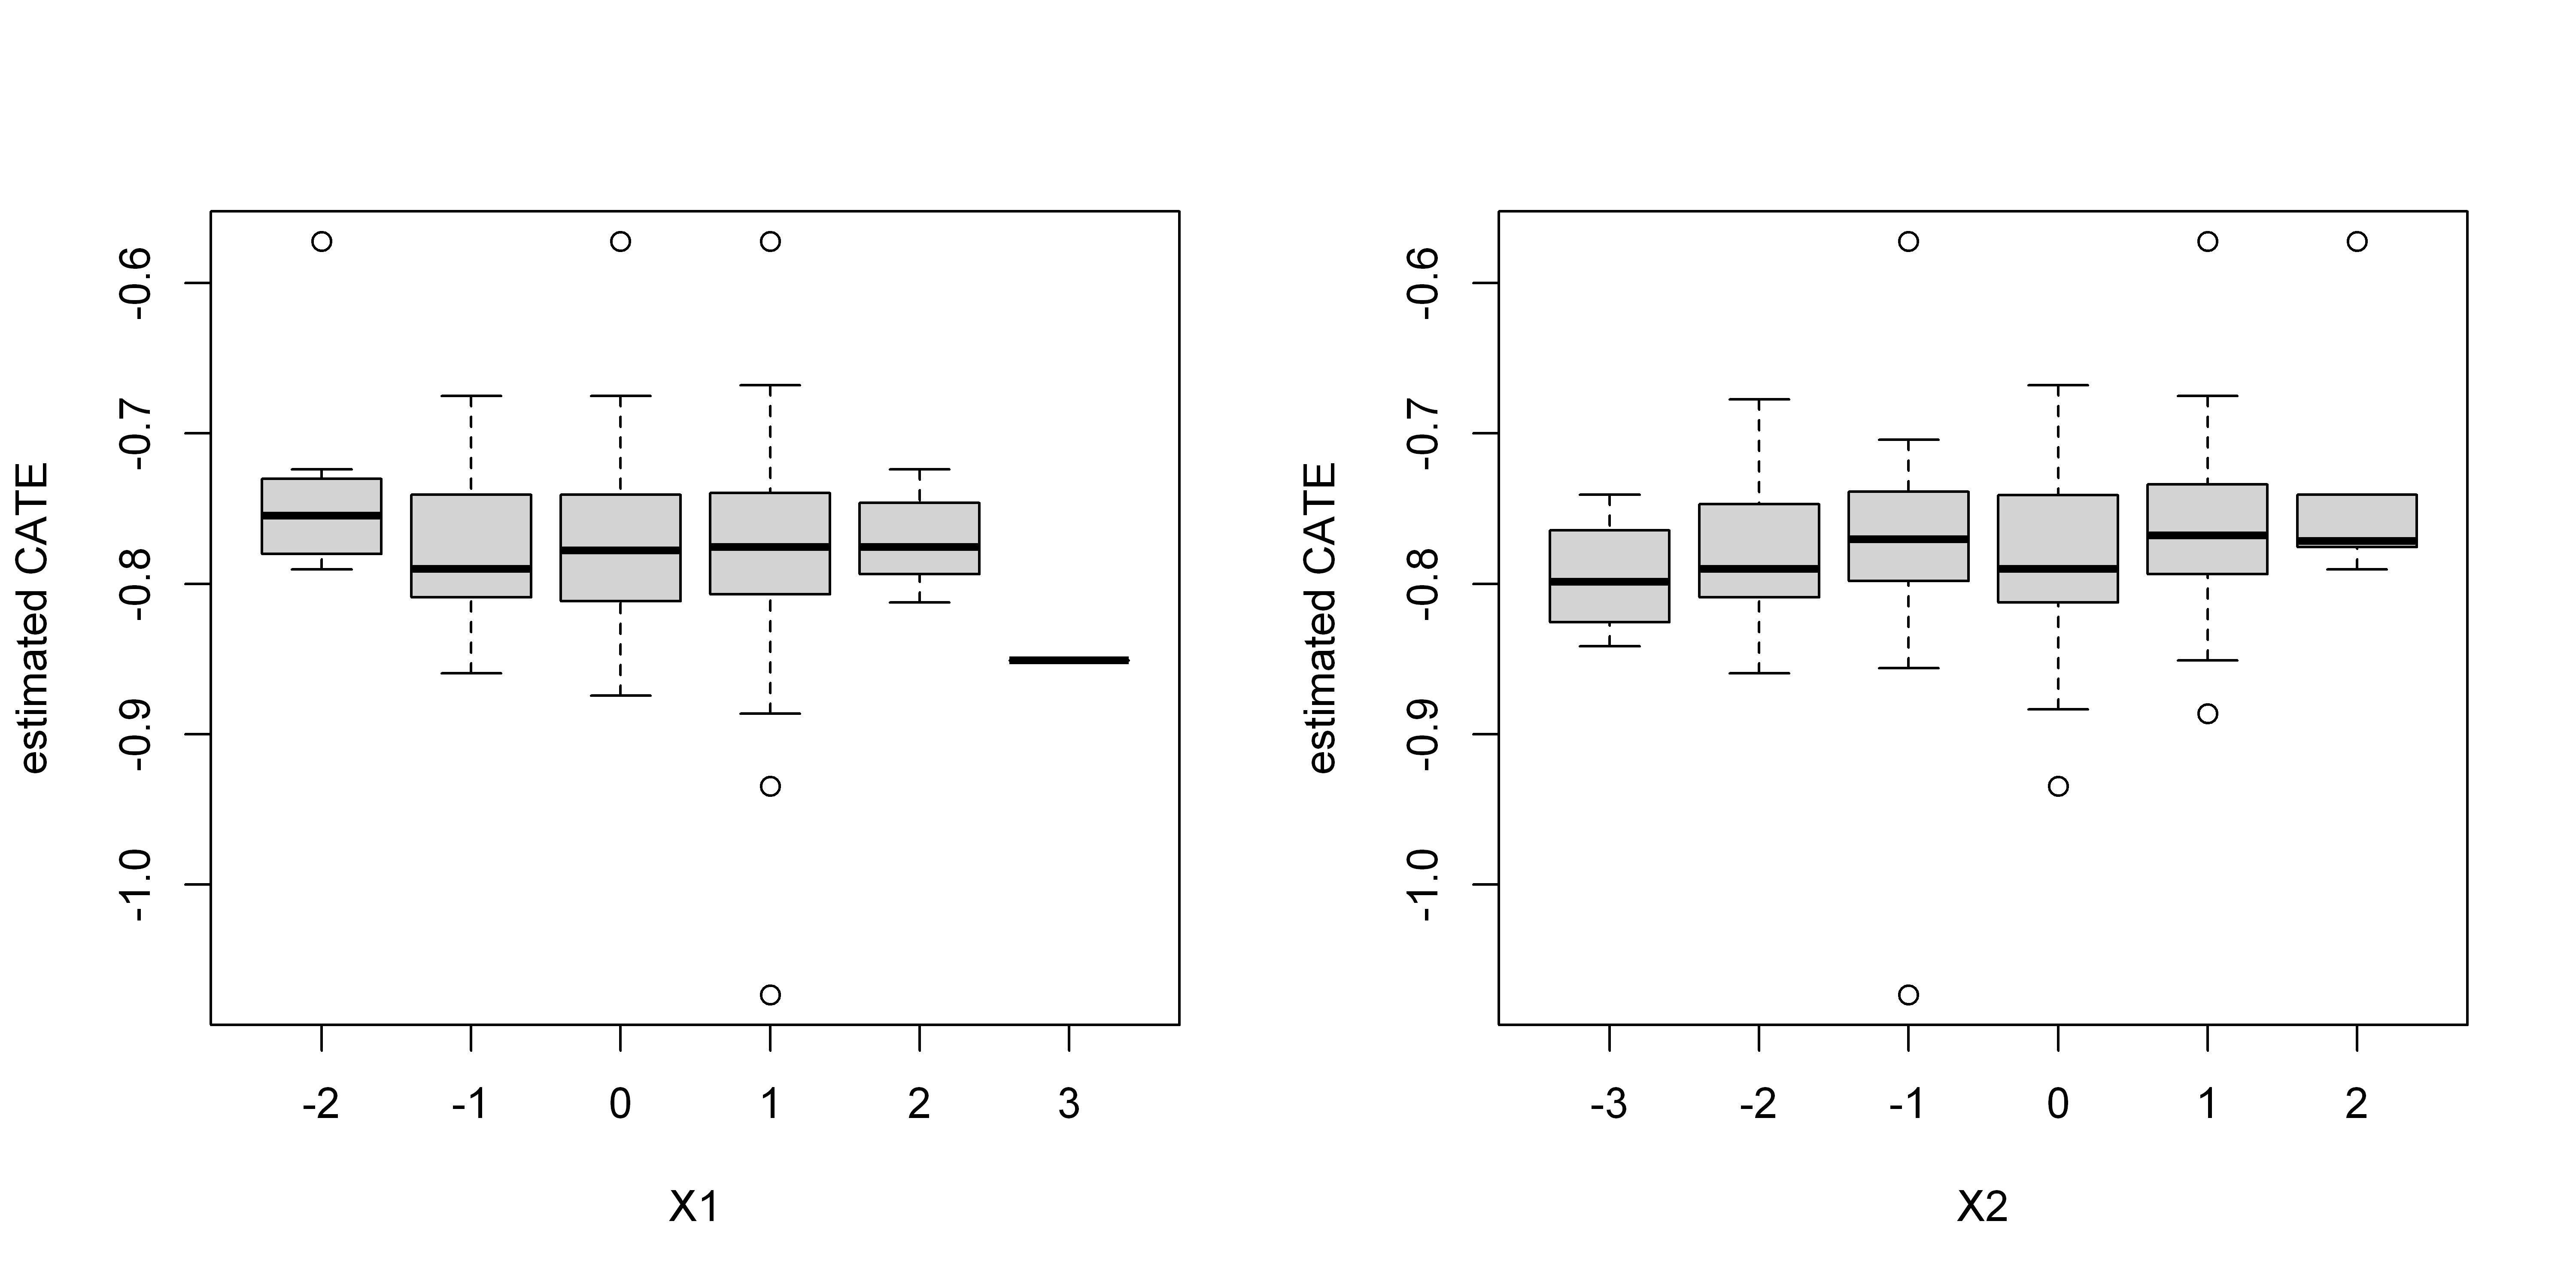

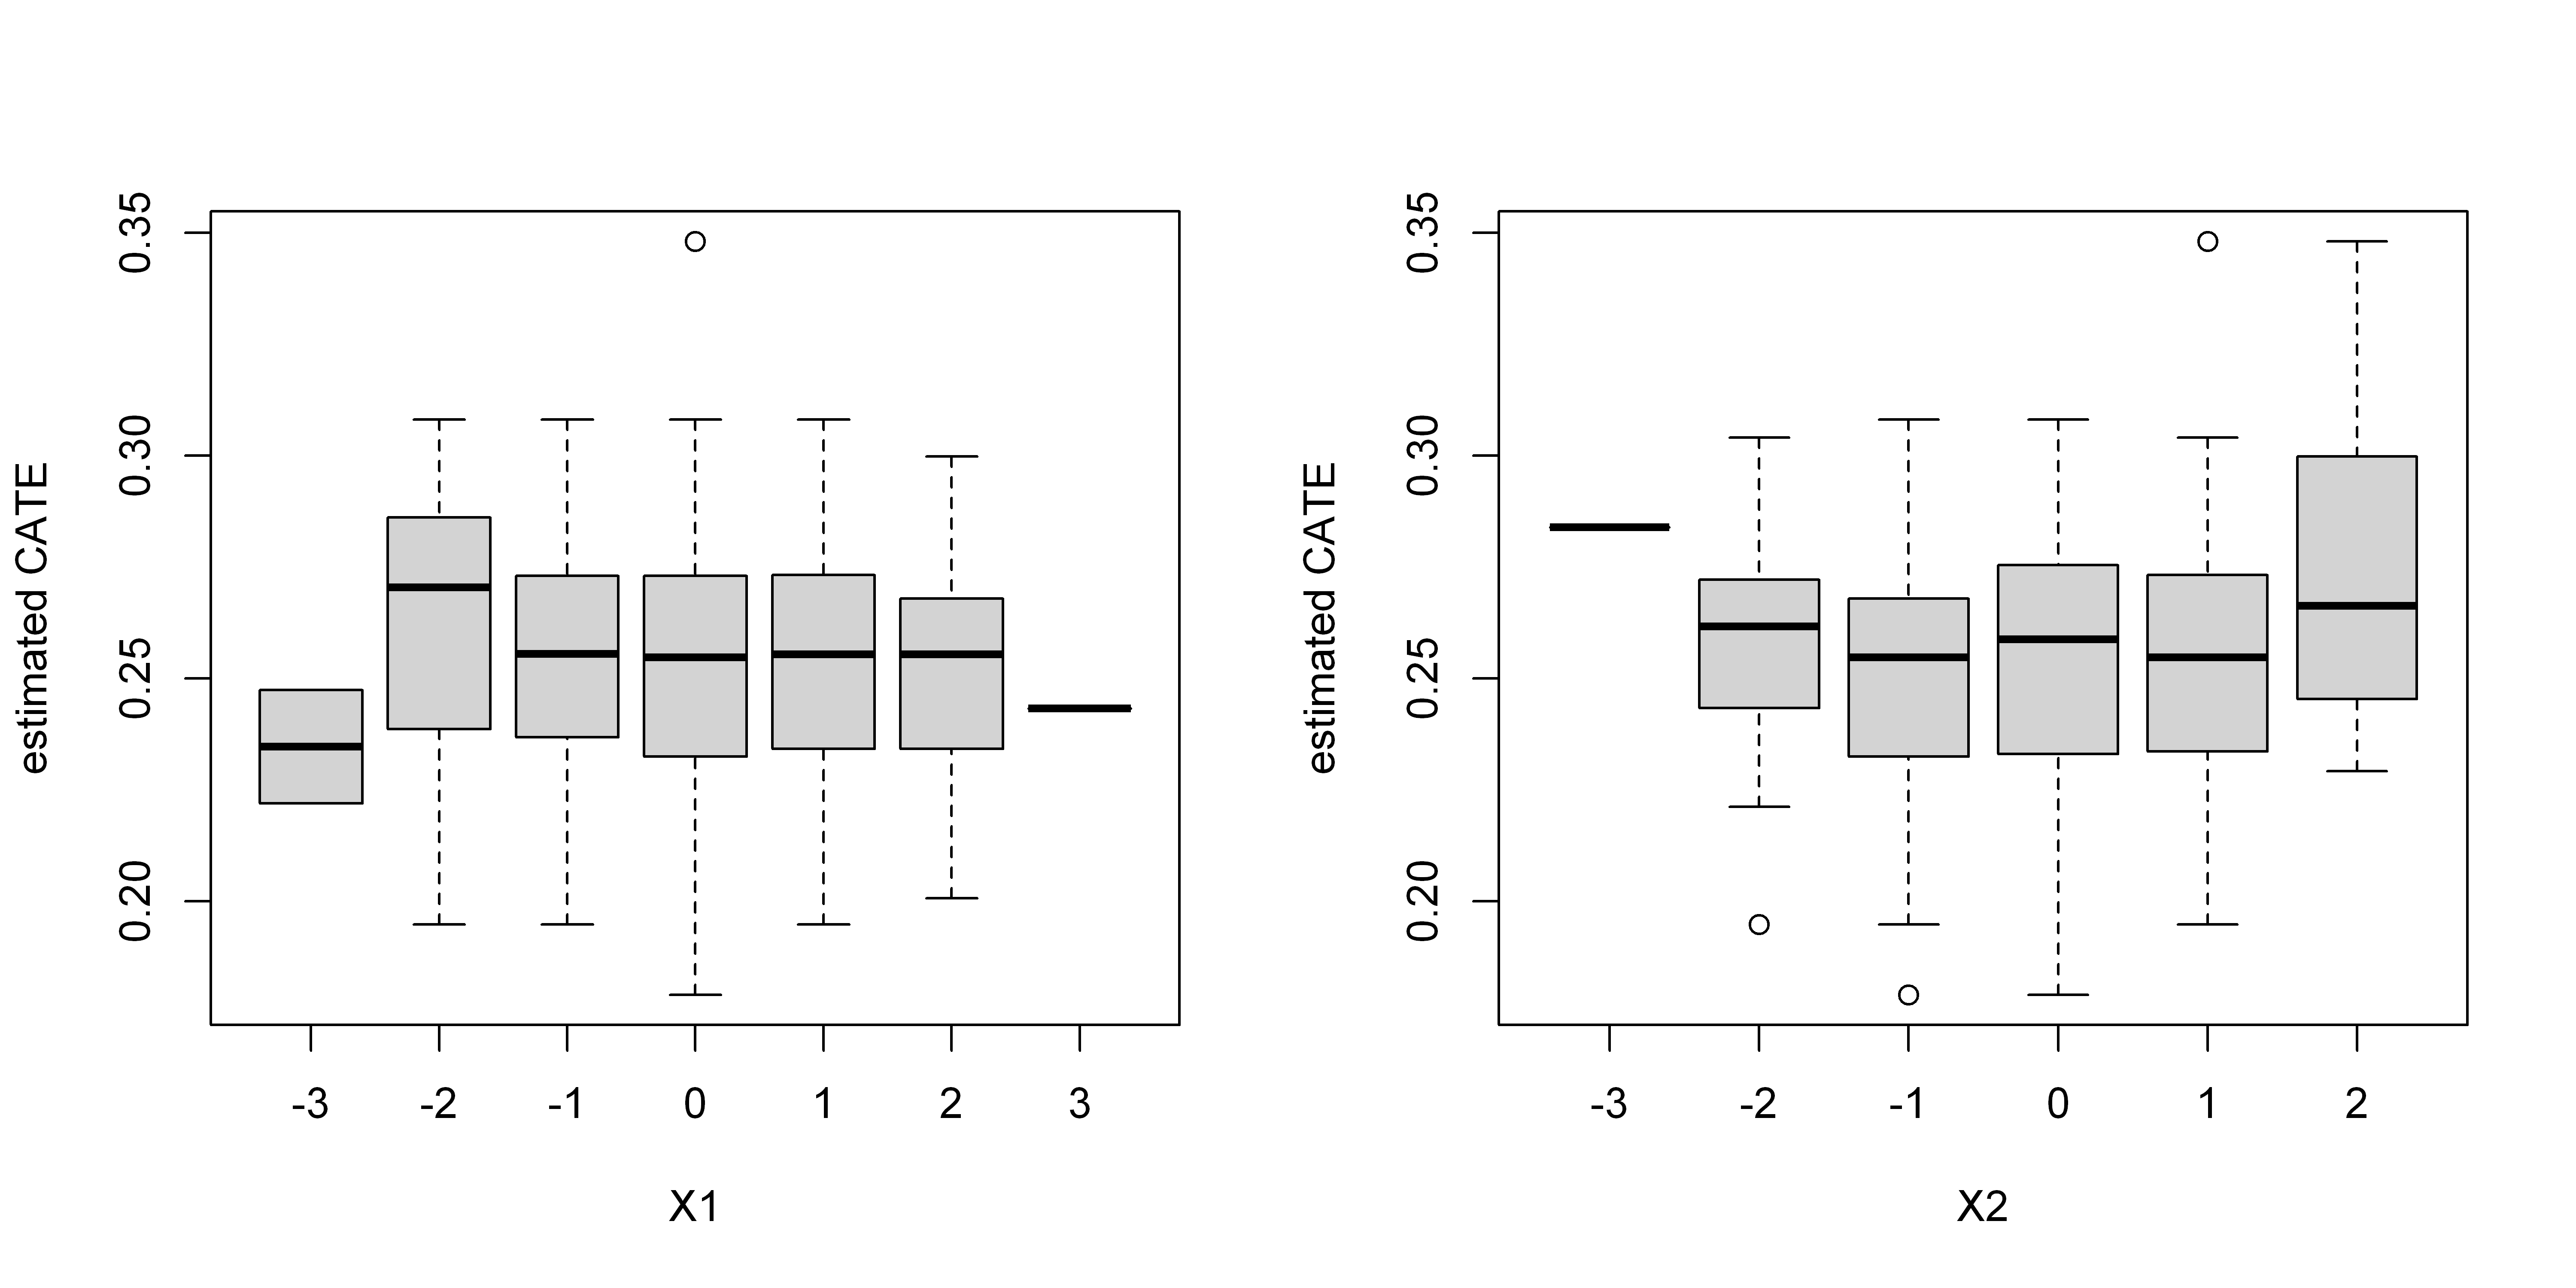

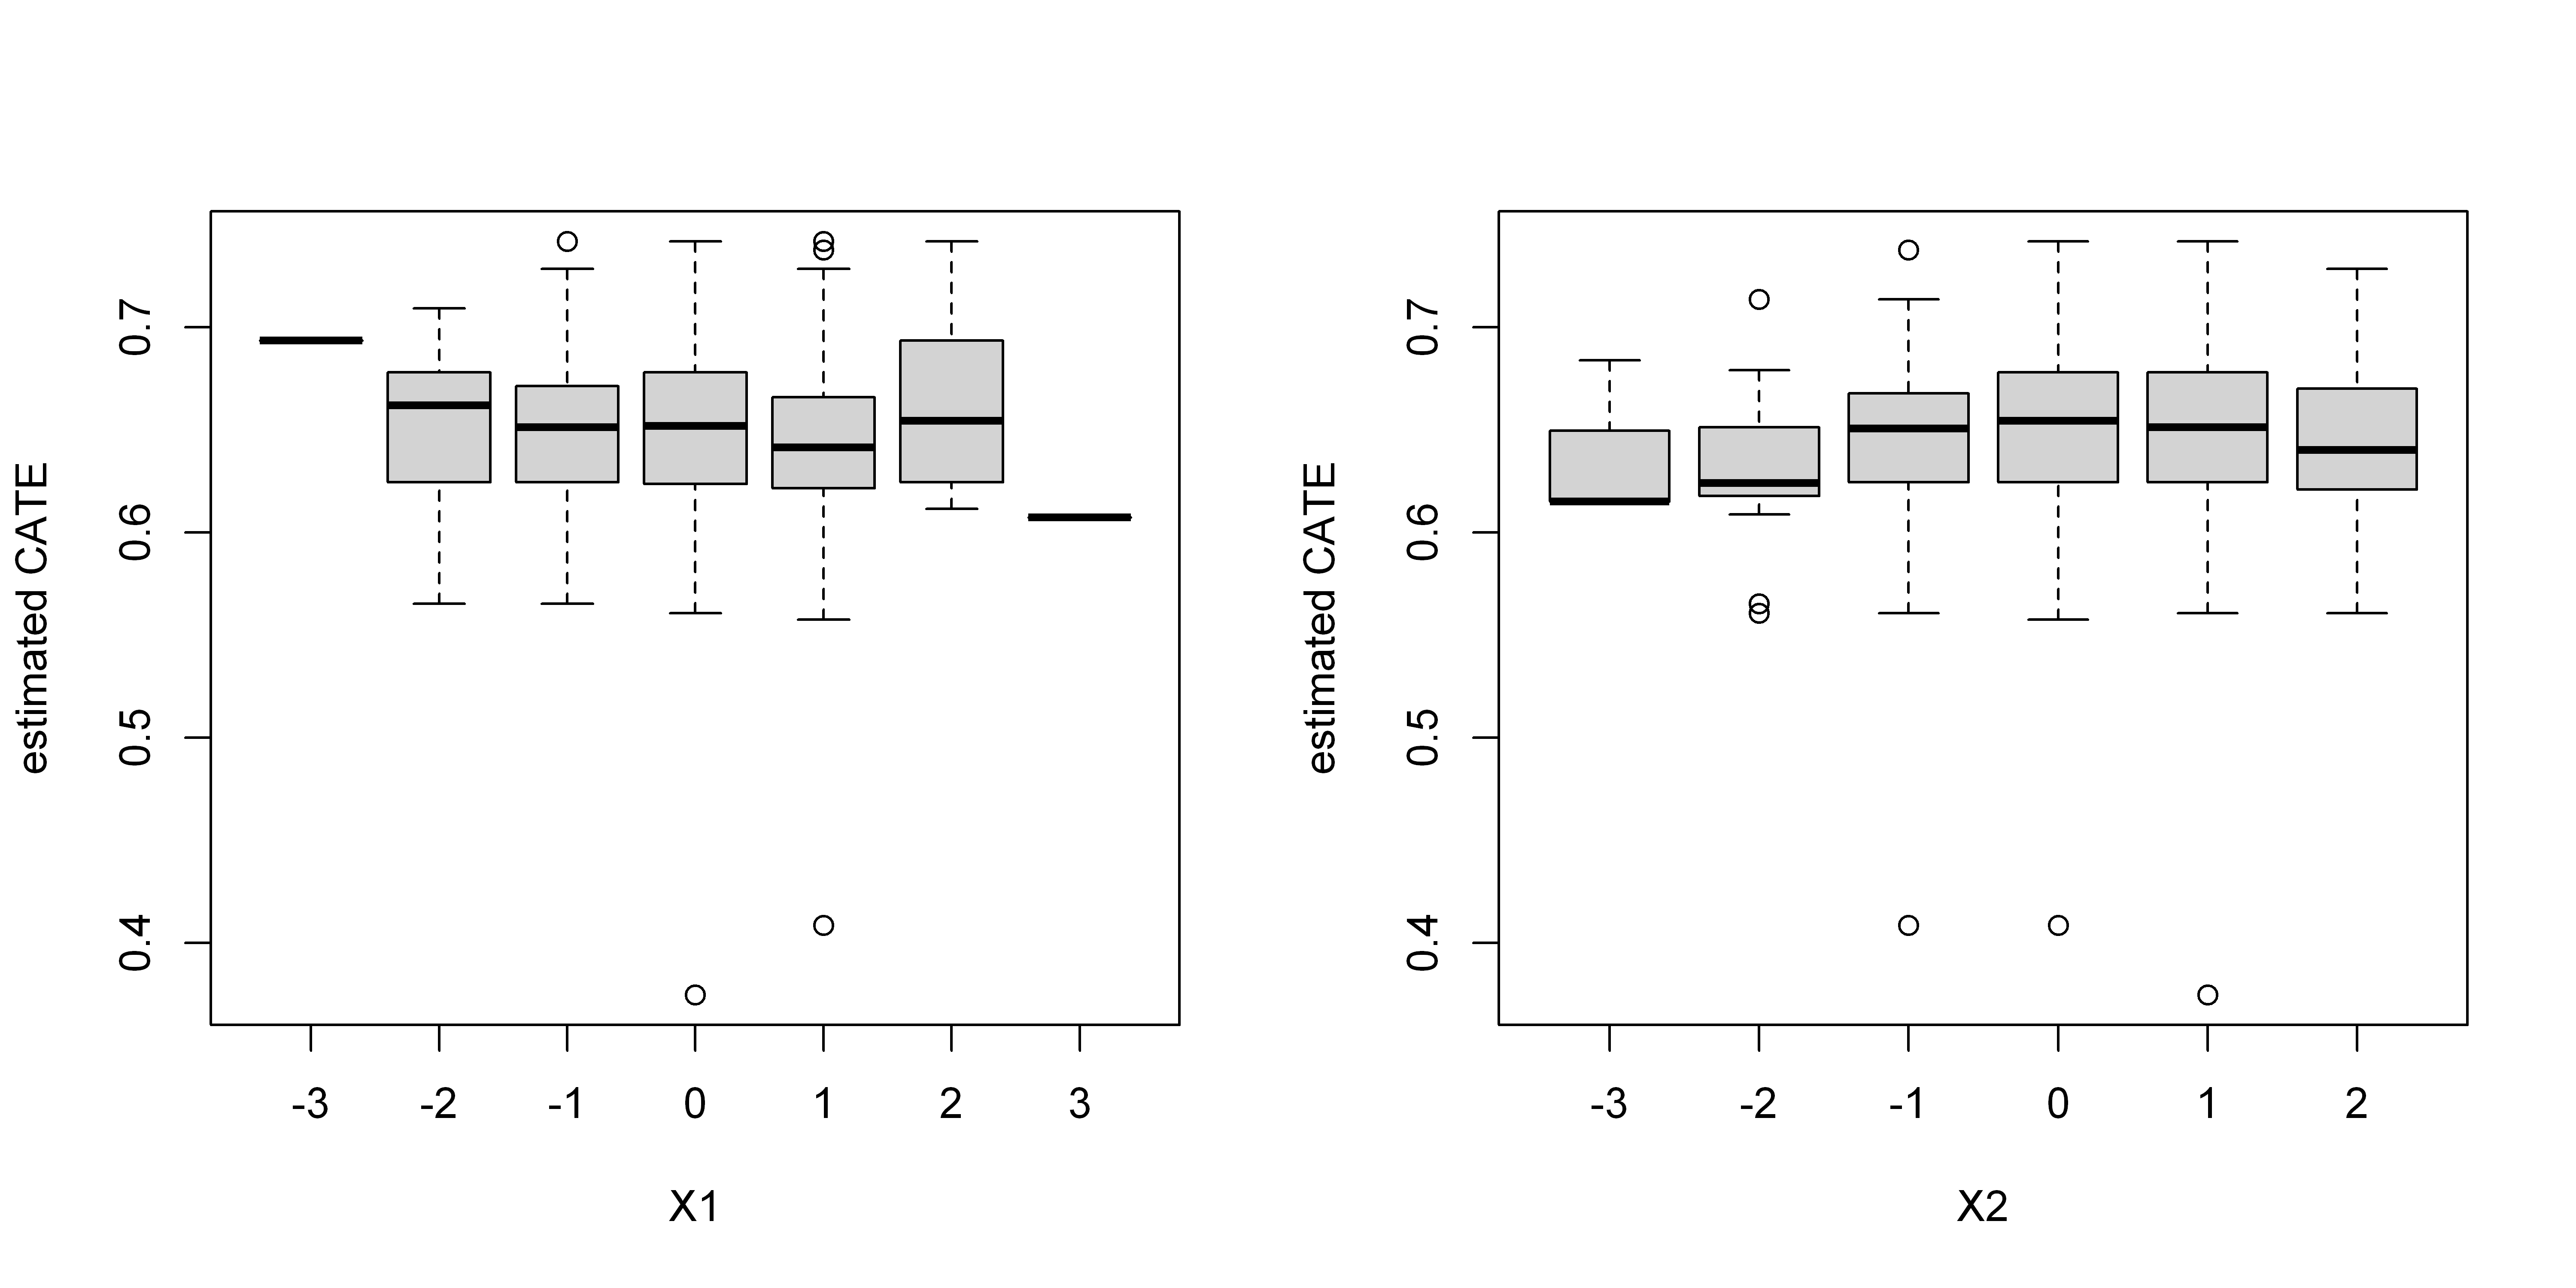

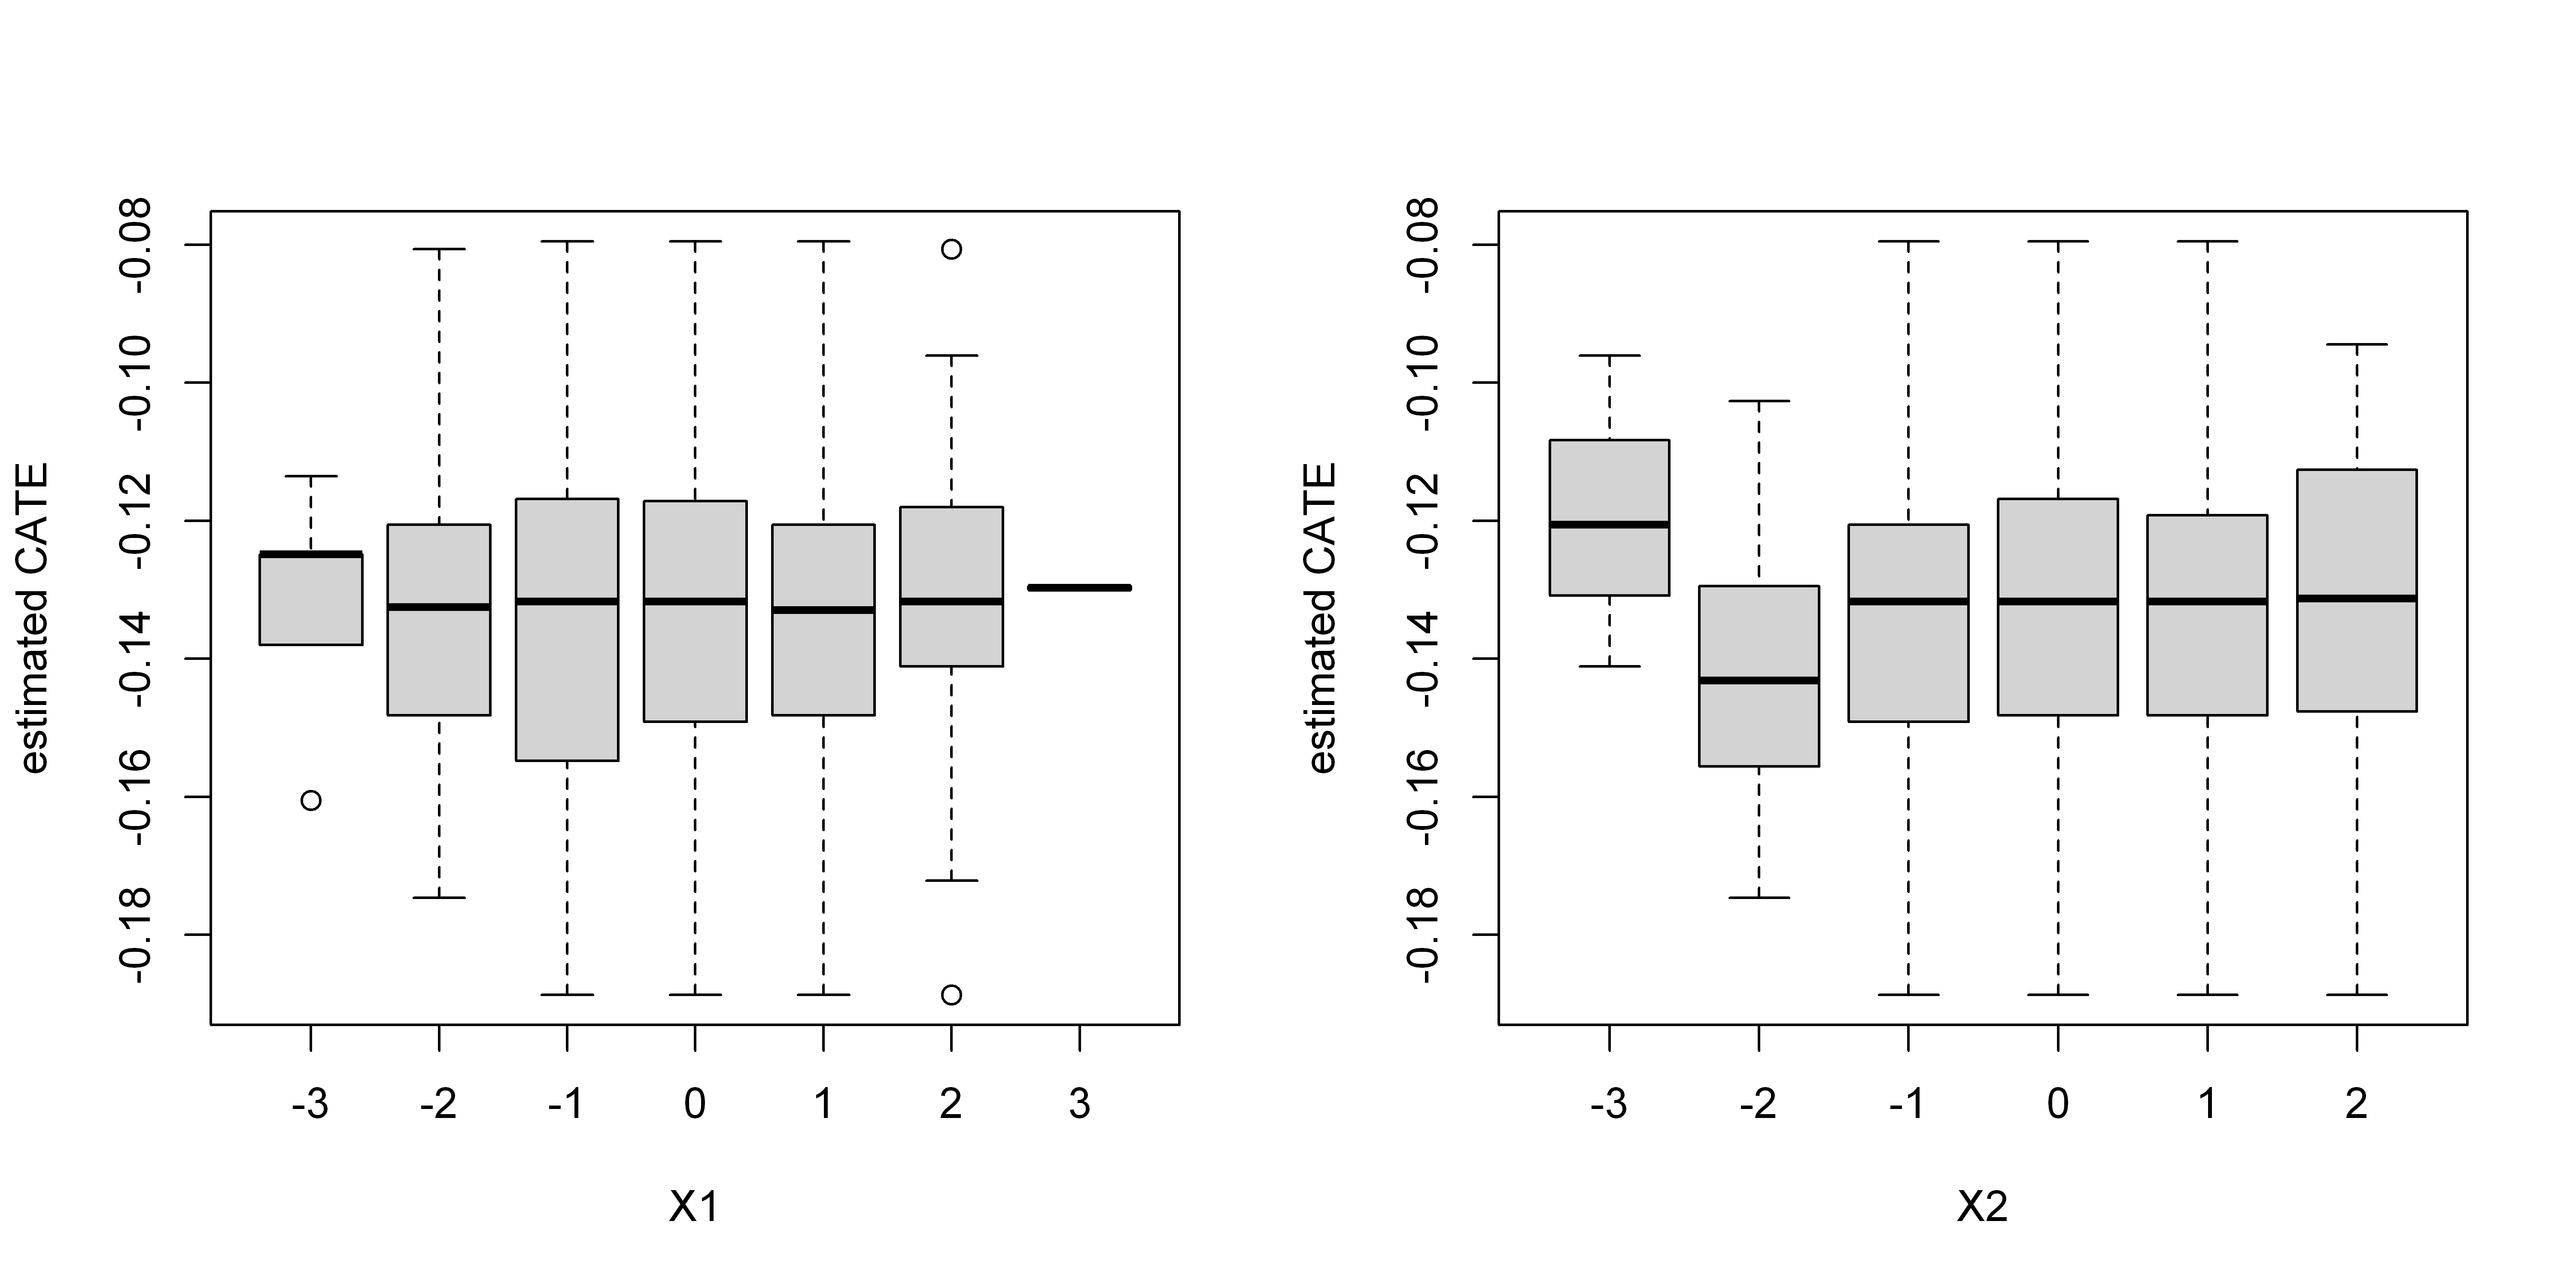

In [22]:
set.seed(57) 

for (sample_size in c(200, 400, 600, 1000)) {
    row <- row + 1
    data.all <- dgp2(sample_size)

    X <- data.all[, c("X1", "X2", "X3", "X4", "X5")]
    Y <- data.all$Y
    W <- data.all$W
    school.id <- as.numeric(data.all$schoolid)

    Y.forest <- regression_forest(X, Y, clusters = school.id, equalize.cluster.weights = TRUE)
    Y.hat <- predict(Y.forest)$predictions
    W.forest <- regression_forest(X, W, clusters = school.id, equalize.cluster.weights = TRUE)
    W.hat <- predict(W.forest)$predictions

    cf <- causal_forest(X, Y, W,
                       Y.hat = Y.hat, W.hat = W.hat,
                       clusters = school.id,
                       equalize.cluster.weights = TRUE)
    tau.hat.cf <- predict(cf)$predictions
    
    options(repr.plot.res = 600, repr.plot.height = 5, repr.plot.width = 10)
    par("mfcol"=c(1, 2))
    boxplot(tau.hat.cf ~ round(X$X1), xlab = "X1", ylab = "estimated CATE")
    boxplot(tau.hat.cf ~ round(X$X2), xlab = "X2", ylab = "estimated CATE")
}

**Exercise 2.2: Introduce other interactions to evaluate the scenario in question 3.**

In [23]:
synthetic_data <- read.csv("D:/data/synthetic_data.csv")
set.seed(57) 

dgp3 <- function(n) { 

  data <- synthetic_data[sample(nrow(synthetic_data), n), ]
  data <- rename(data, W = Z)
  data <- arrange(data, desc(W))
  df <- data[, -c(1)]
  var_name <- names(df)
  stats <- as.data.frame(t(stat.desc(df)))
  cat_var <- c()
  num_var <- c()
  sim_data <- data$schoolid

  for (i in 1:ncol(df)) {
    if (class(df[, i]) == "integer") {
    cat_var <- c(cat_var, var_name[i])
    x <- sort(unique(df[, i]))
    freq <- as.data.frame(table(df[, i]))[2]
    sim <- sample(x, nrow(df), replace = TRUE, prob = freq$Freq)
    }
    else {
      num_var <- c(num_var, var_name[i])
      sim <- rtnorm(n = stats$nbr.val[i], mean = stats$mean[i],
                    sd = stats$std.dev[i], lower = stats$min[i], upper = stats$max[i])
      }
    sim_data <- data.frame(sim_data, a = sim)
    }
    
  names(sim_data) <- names(data)
  eps <- rnorm(nrow(sim_data), 0, 1)
  eta <- rnorm(nrow(sim_data), 0, 2)
    
  for (i in 1:length(data$W[data$W == 1])) {
      sim_data$tau[i] <- 1 + 3 * ifelse(sim_data$X1[i] < mean(sim_data$X1[i]), 1, 0) - 
      2 * ifelse(sim_data$X2[i] < mean(sim_data$X2[i]), 1, 0) + 
      1 * ifelse(sim_data$X3[i] < mean(sim_data$X3[i]), 1, 0) - 
      4 * ifelse(sim_data$X4[i] < mean(sim_data$X4[i]), 1, 0) +
      5 * ifelse(sim_data$X5[i] < mean(sim_data$X5[i]), 1, 0) - eta[i] 
    
      sim_data$Y[i] <- 1 + sim_data$X1[i] - 1/2 * sim_data$X2[i] + 
      1/3 * sim_data$X3[i] - 1/4 * sim_data$X4[i] + 1/5 * sim_data$X5[i] + sim_data$W[i] + 
      sim_data$X1[i] * sim_data$W[i] - 2 * sim_data$X2[i] * sim_data$W[i] + 3 * sim_data$X3[i] * sim_data$W[i] -
      4 * sim_data$X4[i] * sim_data$W[i] - 5 * sim_data$X5[i] * sim_data$W[i] + eps[i] 
  }
  
  sim_data$Y.0 <- sim_data$Y
  sim_data$Y.1 <- sim_data$Y
    
  sim_data$Y.0[sim_data$W == 1] <- sim_data$Y[sim_data$W == 1] - sim_data$tau[sim_data$W == 1] * sim_data$W[sim_data$W == 1]
  sim_data$Y.1[sim_data$W == 1] <- sim_data$Y.0[sim_data$W == 1] + sim_data$tau[sim_data$W == 1]
  sim_data$Y.0[sim_data$W == 0] <- rep(mean(sim_data$Y.0[sim_data$W == 1]),times=length(sim_data$W[sim_data$W == 0]))  + 
                                   rnorm(length(sim_data$W[sim_data$W == 0]), 0, 1)
  sim_data$Y.1[sim_data$W == 0] <- rep(mean(sim_data$Y.1[sim_data$W == 1]),times=length(sim_data$W[sim_data$W == 0])) + 
                                   rnorm(length(sim_data$W[sim_data$W == 0]), 0, 1)
  sim_data$tau[sim_data$W == 0] <- sim_data$Y.1[sim_data$W == 0] - sim_data$Y.0[sim_data$W == 0]
  sim_data$Y[sim_data$W == 0] <- sim_data$W[sim_data$W == 0] * sim_data$Y.1[sim_data$W == 0] +
                                 (1 - sim_data$W[sim_data$W == 0]) * sim_data$Y.0[sim_data$W == 0]

  return(sim_data)
}

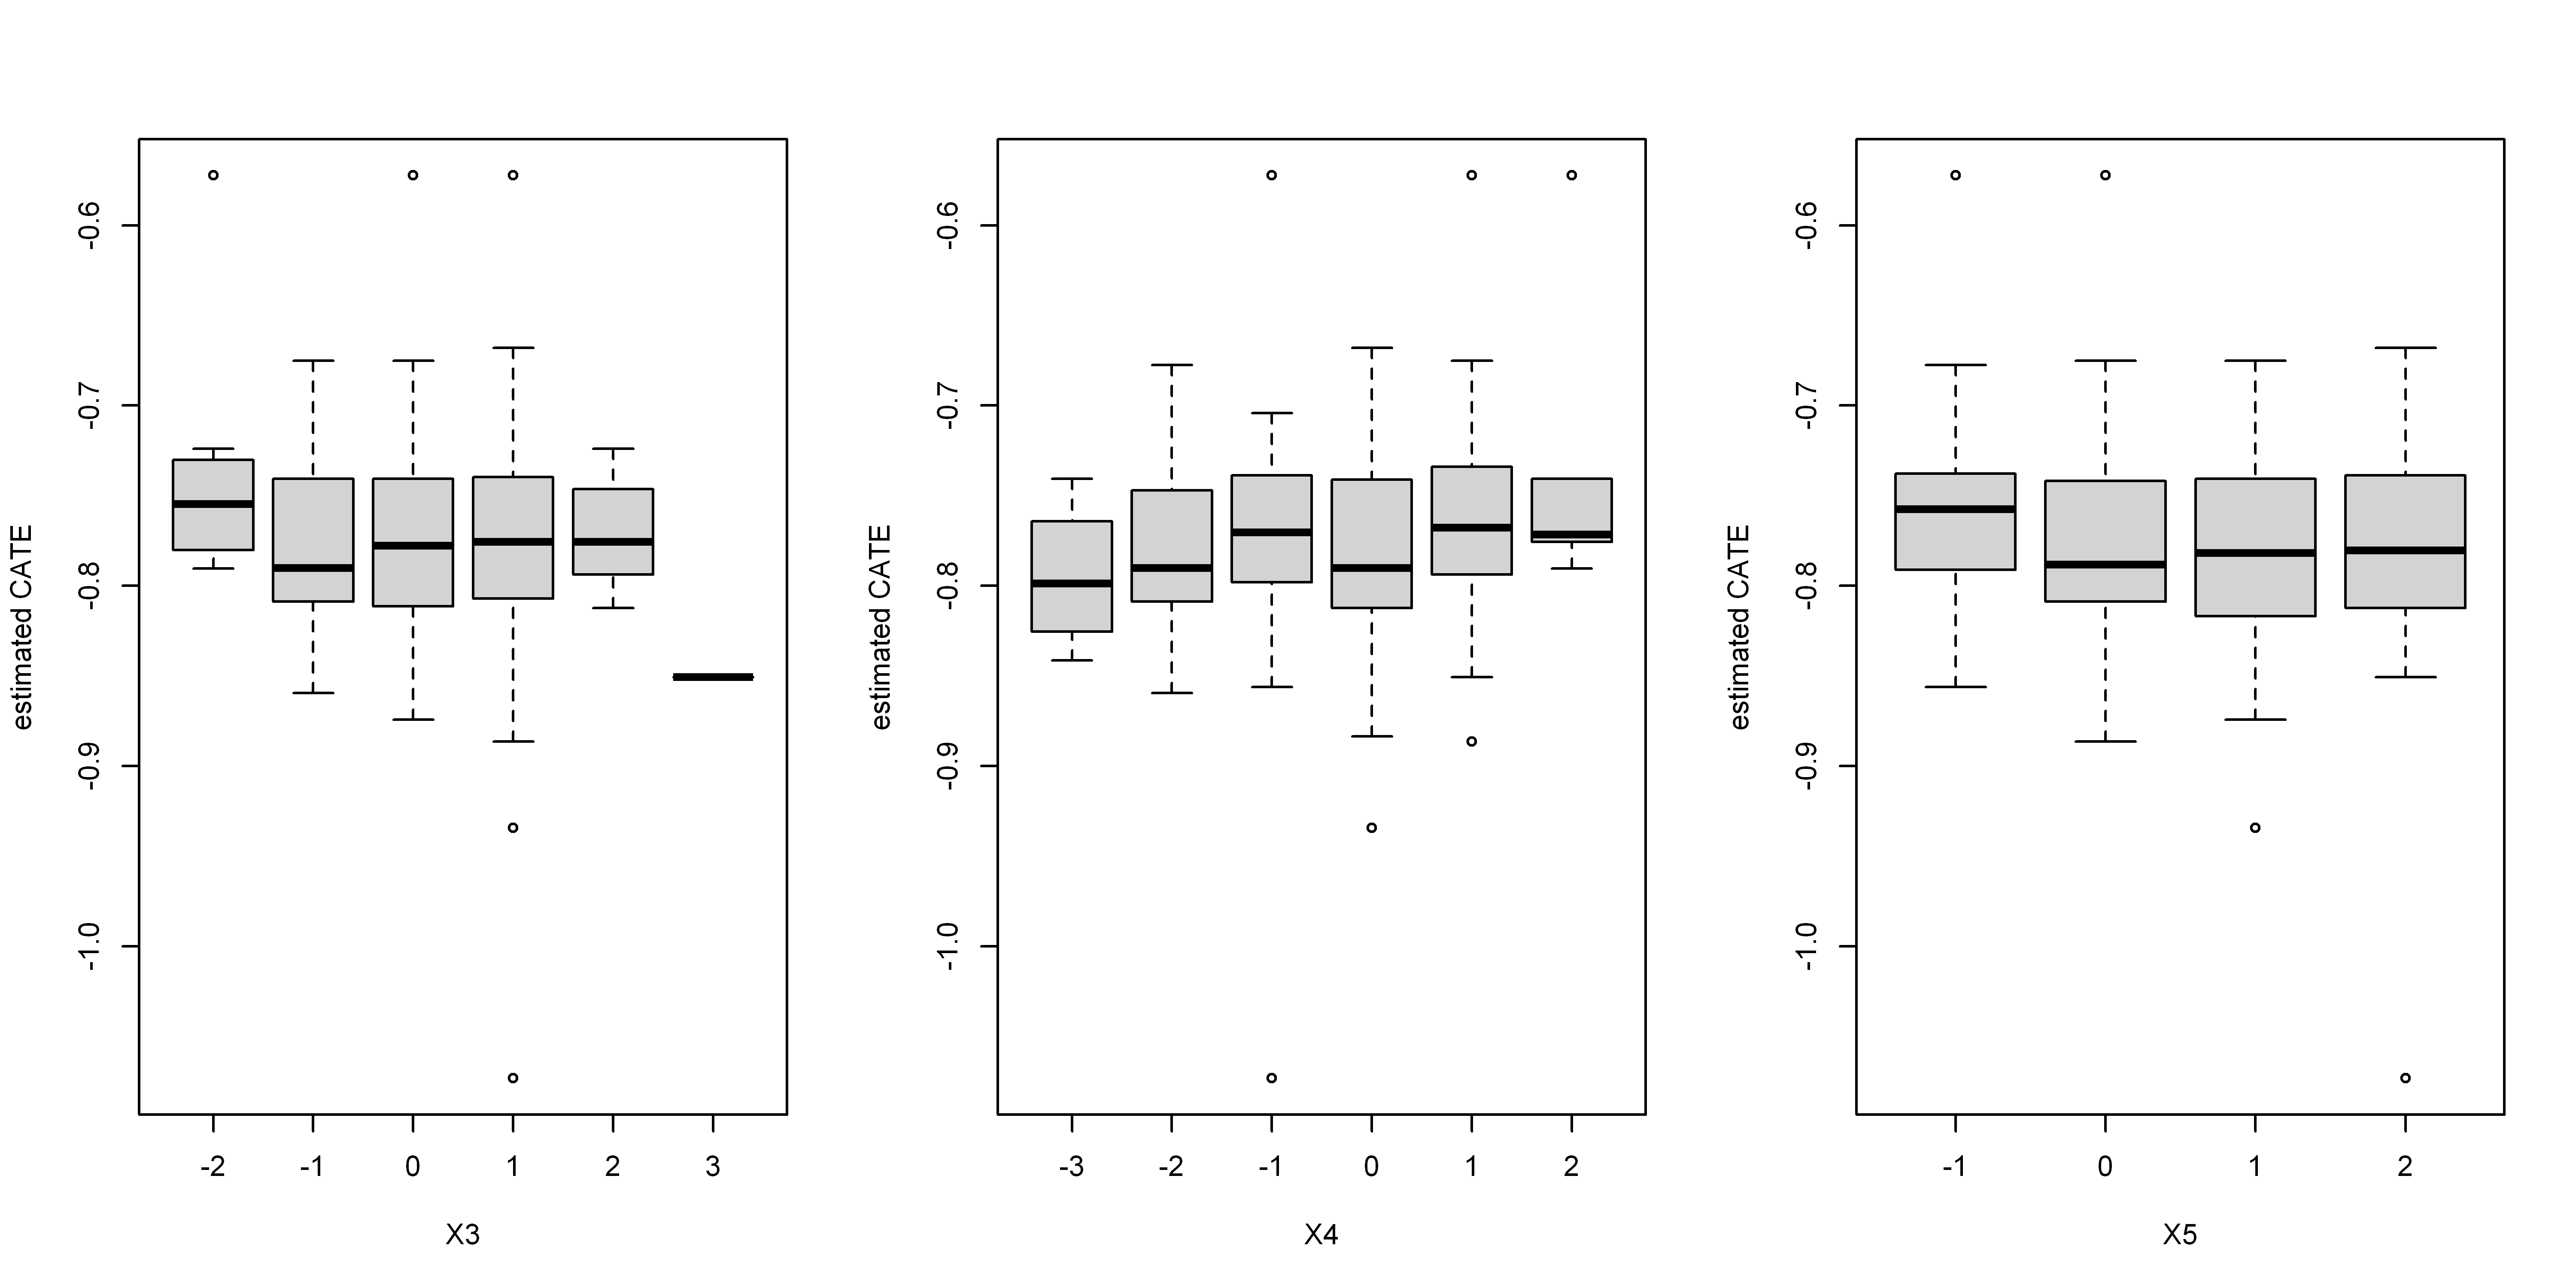

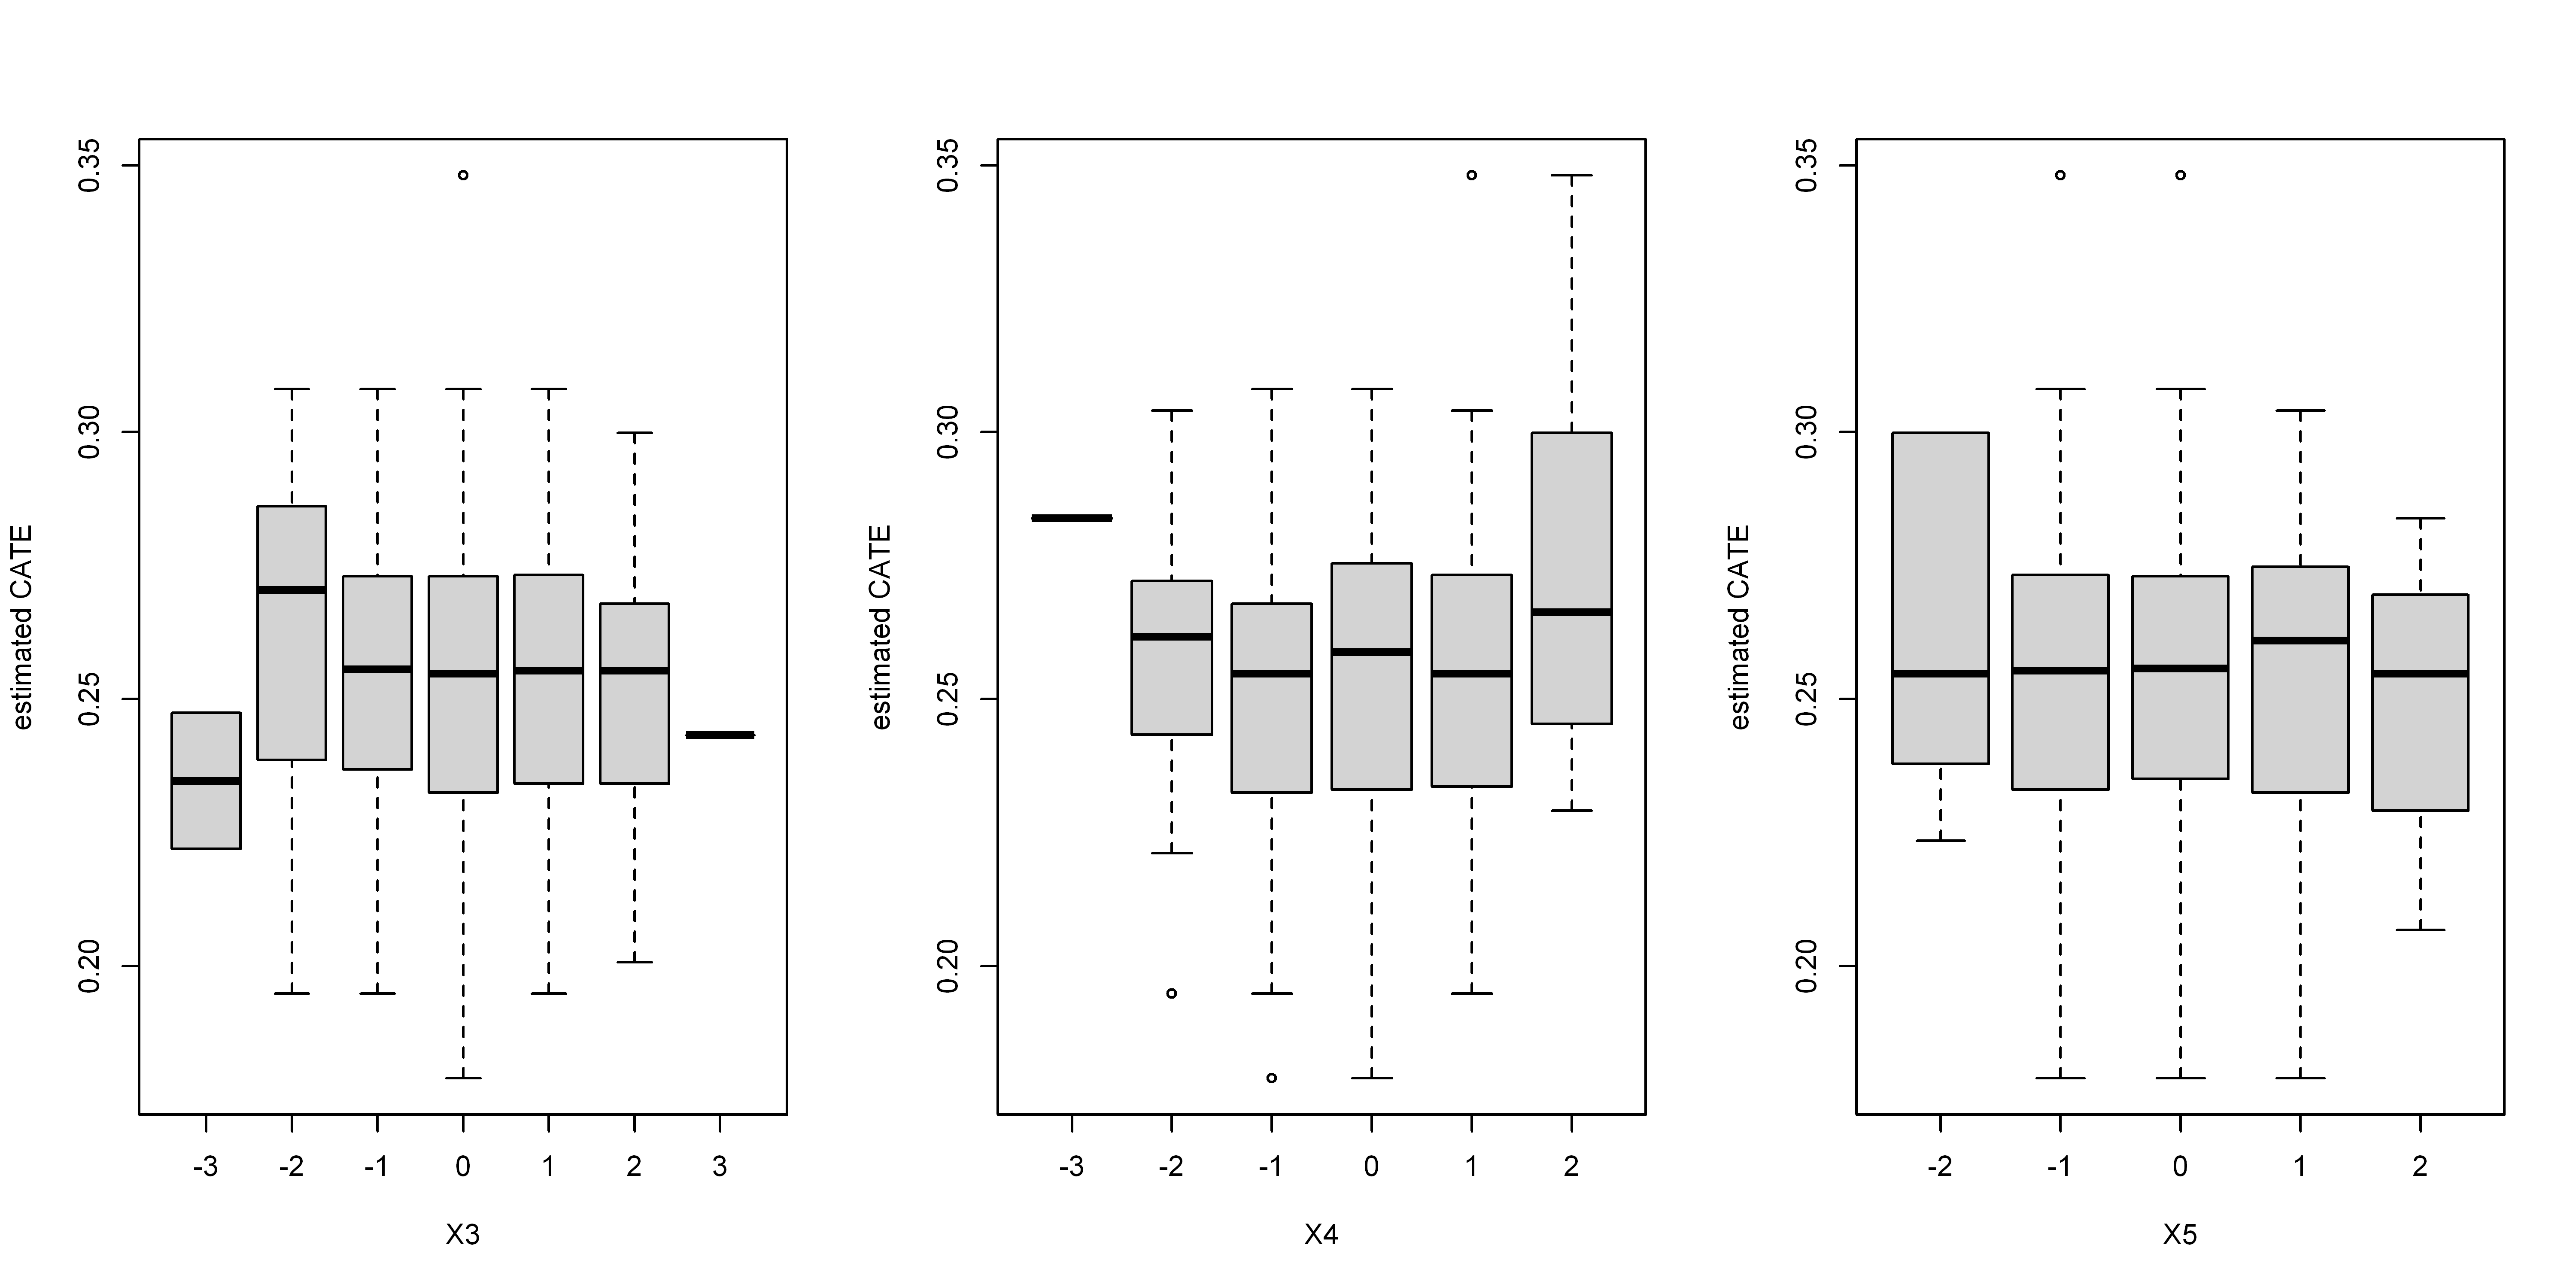

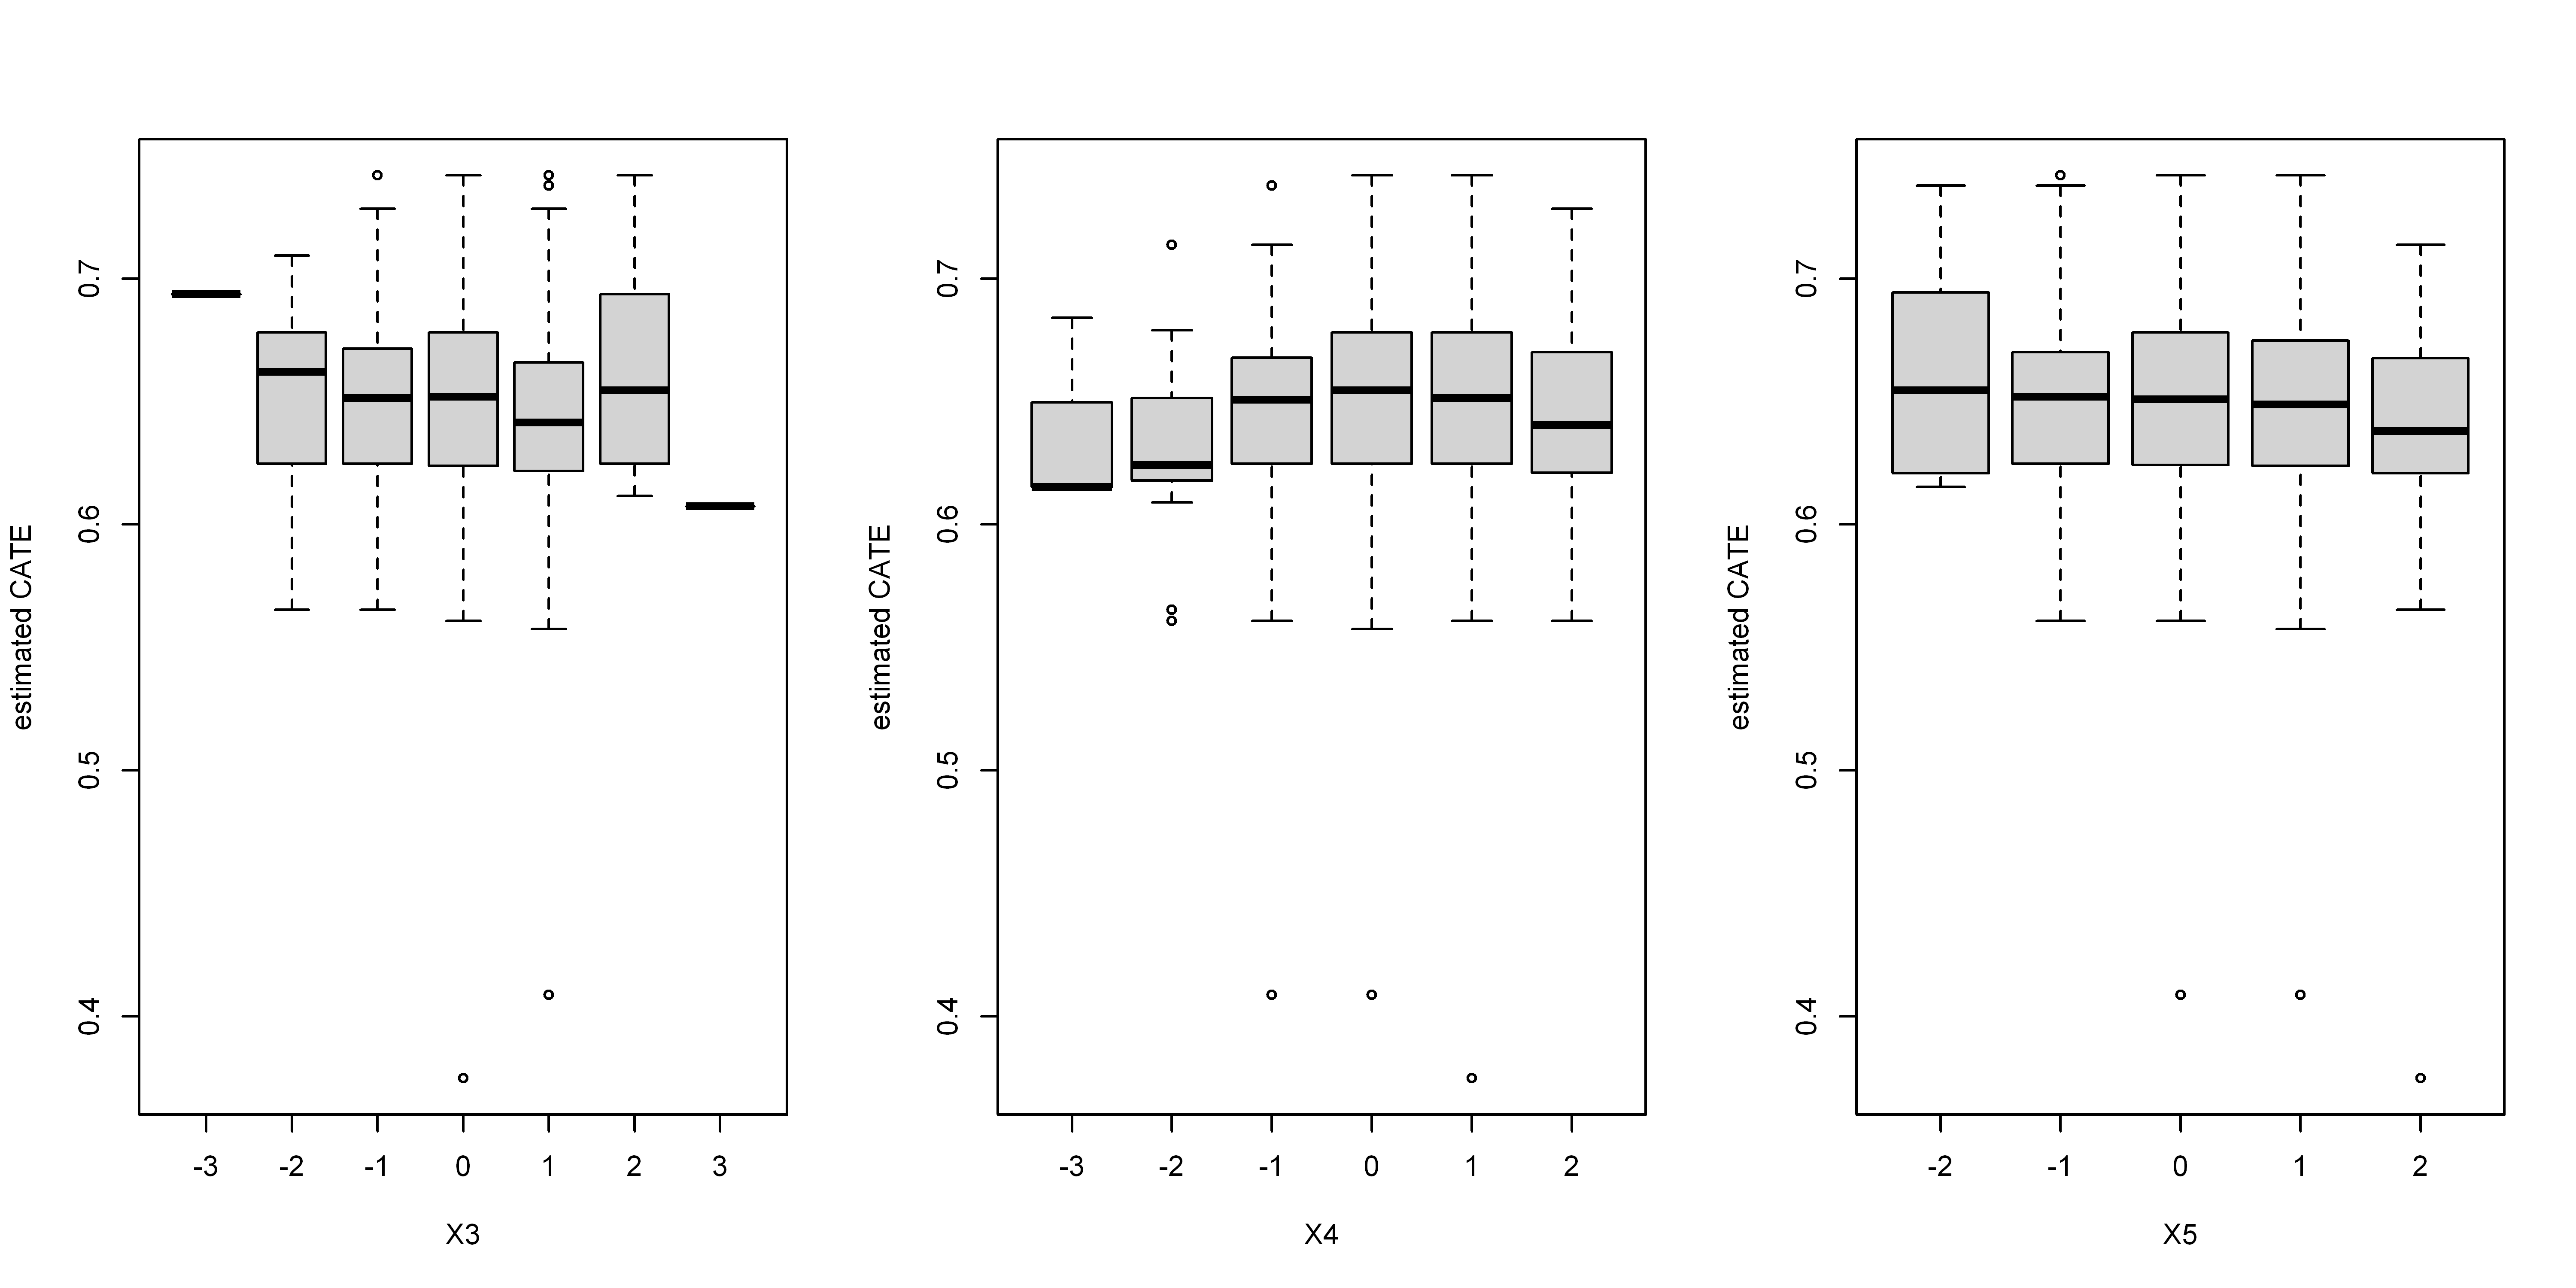

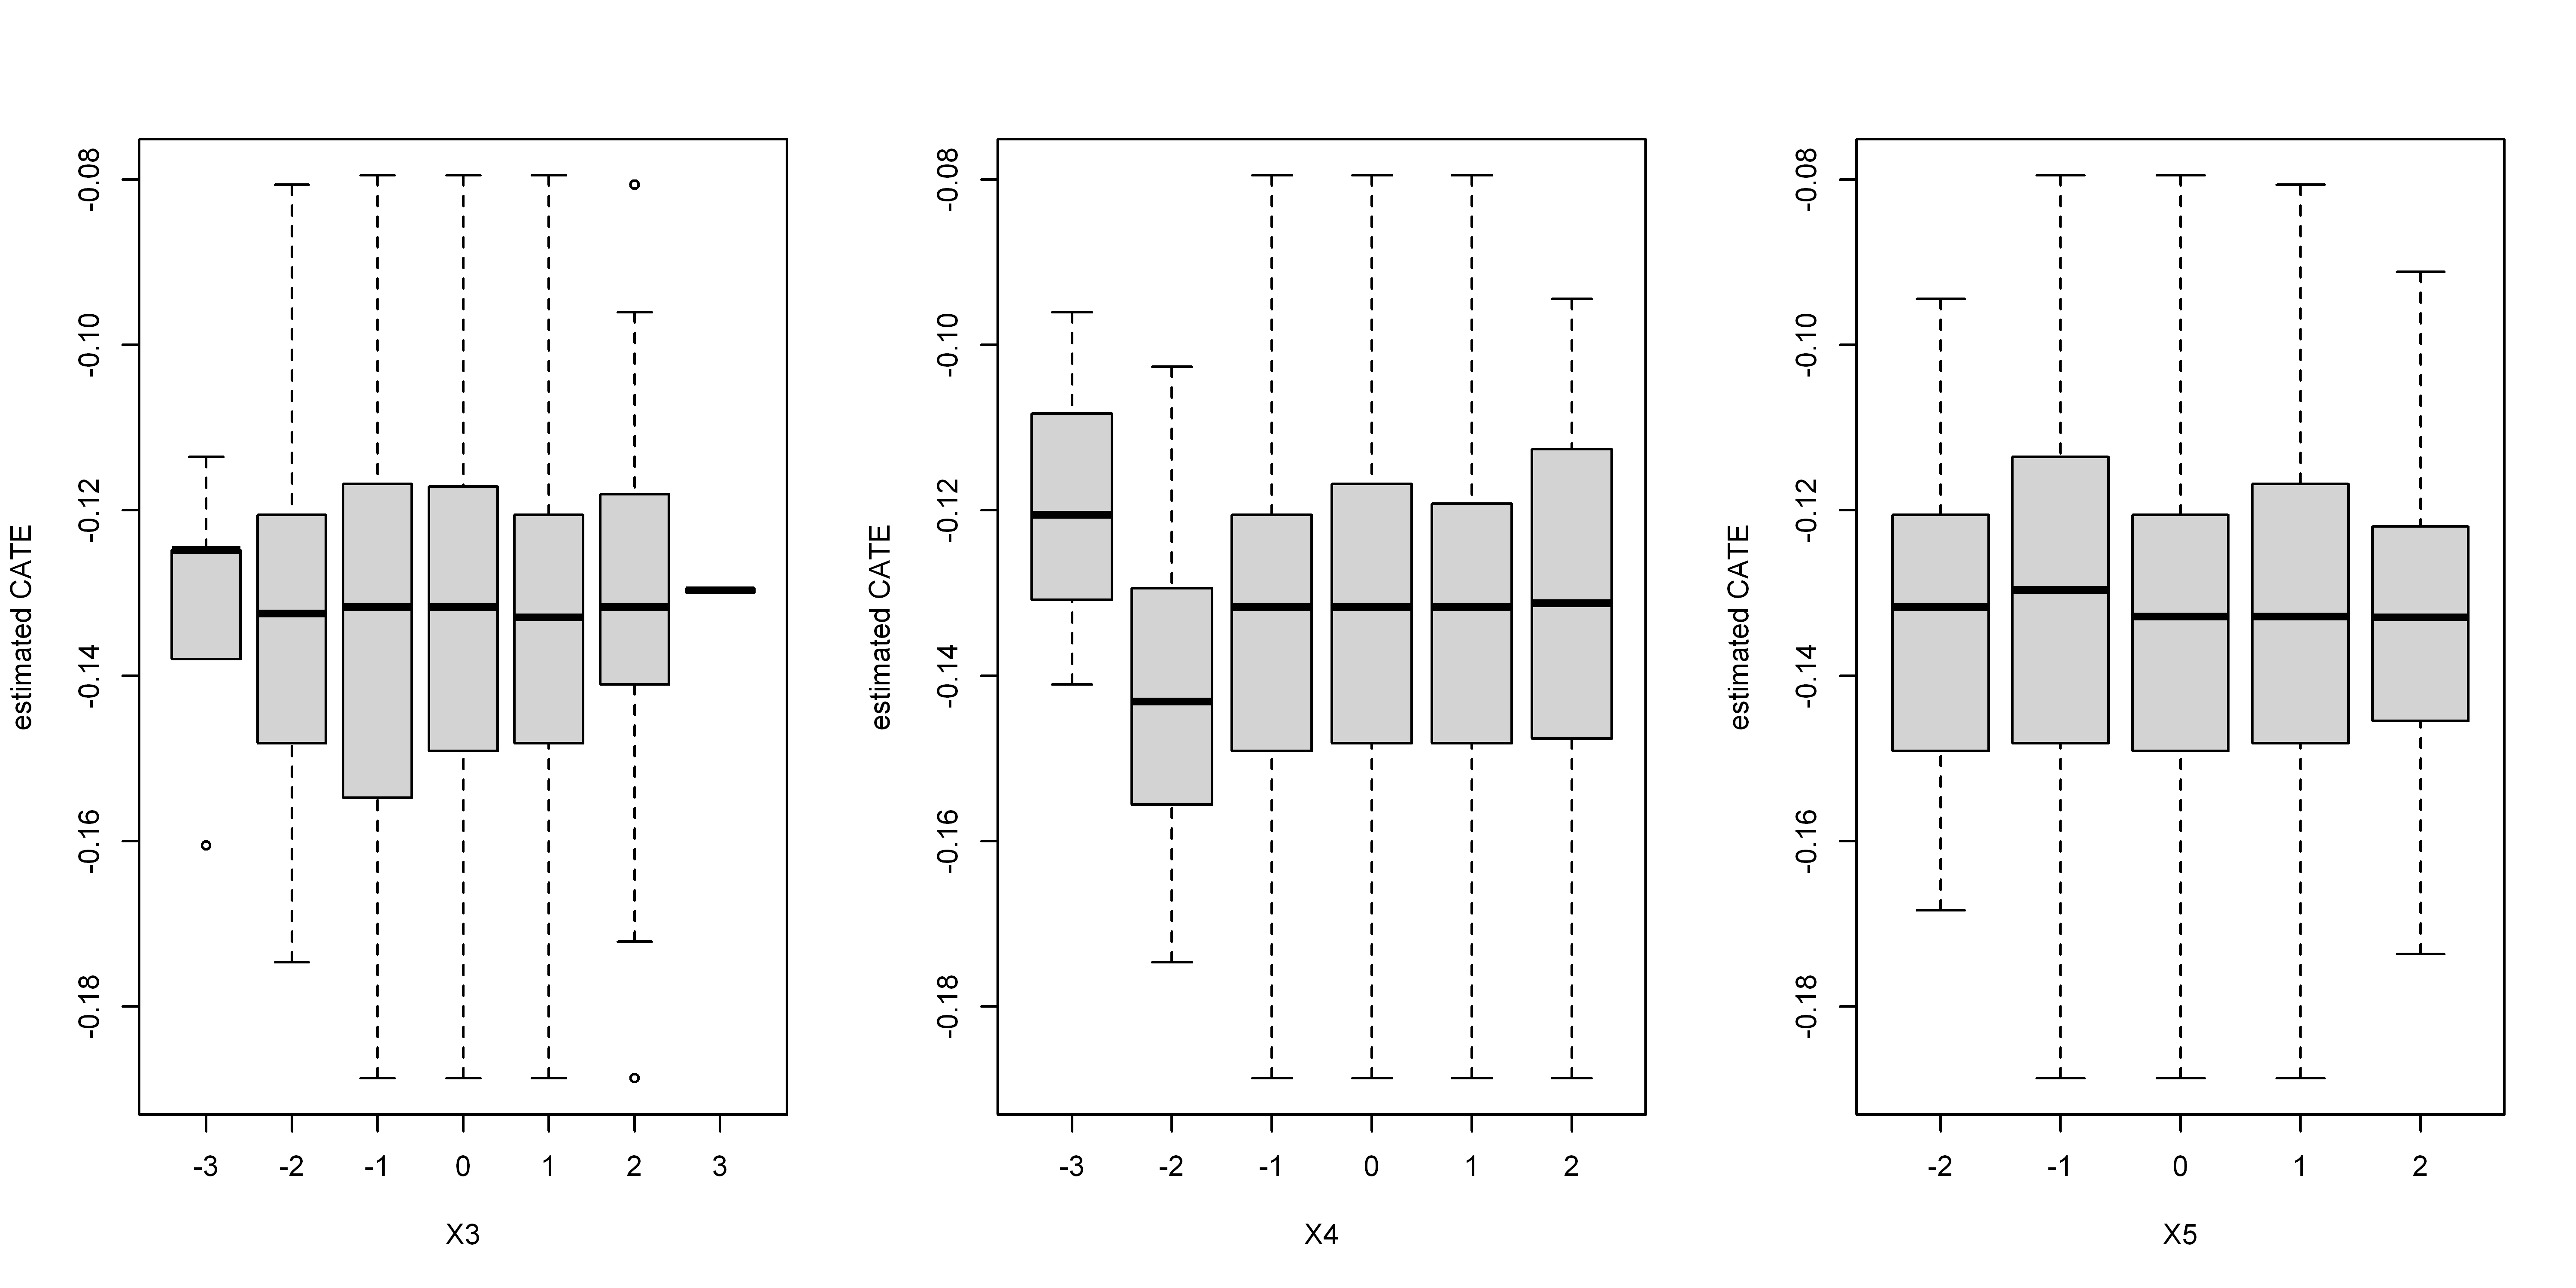

In [24]:
set.seed(57) 

for (sample_size in c(200, 400, 600, 1000)) {
    row <- row + 1
    data.all <- dgp2(sample_size)

    X <- data.all[, c("X1", "X2", "X3", "X4", "X5")]
    Y <- data.all$Y
    W <- data.all$W
    school.id <- as.numeric(data.all$schoolid)

    Y.forest <- regression_forest(X, Y, clusters = school.id, equalize.cluster.weights = TRUE)
    Y.hat <- predict(Y.forest)$predictions
    W.forest <- regression_forest(X, W, clusters = school.id, equalize.cluster.weights = TRUE)
    W.hat <- predict(W.forest)$predictions

    cf <- causal_forest(X, Y, W,
                       Y.hat = Y.hat, W.hat = W.hat,
                       clusters = school.id,
                       equalize.cluster.weights = TRUE)
    tau.hat.cf <- predict(cf)$predictions
    
    options(repr.plot.res = 600, repr.plot.height = 5, repr.plot.width = 10)
    par("mfcol"=c(1, 3))
    boxplot(tau.hat.cf ~ round(X$X1), xlab = "X3", ylab = "estimated CATE")
    boxplot(tau.hat.cf ~ round(X$X2), xlab = "X4", ylab = "estimated CATE")
    boxplot(tau.hat.cf ~ round(X$X3), xlab = "X5", ylab = "estimated CATE")
}